In [1]:
import os
import re
import glob
import pickle
import pprint
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.special import softmax
pd.options.mode.chained_assignment = None  # default='warn'
from id_to_class import bdd100k_det as id2class
from id_to_class import bdd100k_det_name2RGB as name2RGB
from id_to_class import bdd100k_det_name2white as name2white

if 10 in id2class:
    del id2class[10]

class2id = {v: k for k, v in id2class.items()}
    
pd.options.mode.chained_assignment = None  # default='warn'


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']


pp = pprint.PrettyPrinter(indent=4)

# Read BDD100k csv to DataFrame

In [2]:
epos = list(range(1, 13))
m_names = ['val_split01', 'swin-t_val_split01']


source_csv_dirpath = './postprocessing/code/DataFrame/BDD100K'
tmp_figpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig'
default_csv_filepath = './postprocessing/code/DataFrame/BDD100K/FasterRCNN/default_val_s01.csv'


def convert_csv2np(df, colnames):

    for col in colnames:
        df[col] = df[col].apply(lambda x: np.asarray(x.split(';'), dtype=float))

    return df




def cls_to_probs(cls_scores):

    # print(f'[cls_to_probs] cls_score.shape={cls_score.shape}')

    probs = softmax(cls_scores, axis=0)
    # print('cls_score.shape=', cls_score.shape)
    # print(f'scores.shape={probs.shape}')
    # assert cls_scores.size(0) == gt_bboxes.size(0)

    # sanity check
    # close_to_1 = probs.sum(axis=1)
    # print(f'close_to_1={close_to_1}')

    return probs


def read_df_without_truelabels(csv_filepath, colnames):

    # ,imgpath,cls_score,prob,max_prob,bbox_gt,label_gt,label_gt_des,label_pred,label_pred_des,loss,PBNR_SConf,PBNR_NMargin,PBNR_CWE,CL_SConf,CL_NMargin,CL_CWE,ArgMax_SConf,ArgMax_NMargin,ArgMax_CWE,LRank
    df = pd.read_csv(csv_filepath, header=0, delimiter=',', index_col=0)
    df = convert_csv2np(df, colnames)

    for class_id, classname in id2class.items():
        df[classname] = df['prob'].apply(lambda x: x[class_id])

    # rename_mapper = {
    #     'CL_SConf': 'CL_SC',
    #     'CL_NMargin': 'CL_NM',
    #     'loss':''
    # }
    # df = df.rename(columns=rename_mapper, errors="raise")

    return df


colnames = ['cls_score', 'prob', 'bbox_gt']

m_dic = {m: {int(epo): None for epo in epos} for m in m_names}

for _, m_name in tqdm(enumerate(m_names)):
    for epo in epos:
        source_csv_filepath = f'{source_csv_dirpath}/{m_name}/epo{epo}.csv'
        m_dic[m_name][int(epo)] = read_df_without_truelabels(source_csv_filepath, colnames)
        # print('')


2it [00:07,  3.54s/it]


In [9]:
m_dic['val_split01'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# Model Performance

In [3]:
print(m_dic['swin-t_val_split01'][12]['cls_score'][0].shape)
print(m_dic['swin-t_val_split01'][12]['prob'][0].shape)
print(id2class)

(10,)
(10,)
{0: 'pedestrian', 1: 'rider', 2: 'car', 3: 'truck', 4: 'bus', 5: 'train', 6: 'motorcycle', 7: 'bicycle', 8: 'traffic light', 9: 'traffic sign'}


In [3]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, roc_auc_score, precision_recall_fscore_support

# csv_dirpath = './postprocessing/code/DataFrame/swedish'
tmp_figpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig'

# epos = list(range(10, 61, 10))
# nsplits = ['01']

# m_name = 'CNN2'
# m_name = 'TRANS'
# m_names = ['CNN2', 'TRANS']
# default_csv_filename = f'swe_global_issue.csv'


###############################################################
#                 Number of Detected data                     #
###############################################################
# default_df = pd.read_csv(f'{csv_dirpath}/{default_csv_filename}', index_col=0, header=0)

# is_issue_types = ['c_incorrect', 'c_correct', 'ambiguous']

# All methods
# methods = ['PBNR_NMargin','PBNR_SConf','PBNR_CWE','CL_NMargin','CL_SConf','CL_CWE','ArgMax_NMargin','ArgMax_SConf','ArgMax_CWE', 'LRank']

# Selected methods
# methods = ['PBNR_NMargin','PBNR_SConf', 'PBNR_CWE', 'LRank']

# colnames = ['Epoch', 'Class',
            # 'TP', 'FP', 'TN', 'FN',
            # 'Precision', 'Recall']

colnames = ['epoch', 'model', 'classname', 'precision_ma', 'recall_ma', 'f1_ma', 'precision_mi', 'recall_mi', 'f1_mi']


# if 6 in id2class.keys():
#     del id2class[6]

def gen_model_performance_df(m_names, m_dic, by_classes=False):
    
    dic = {m: None for m in m_names}

    for m_name in m_names:
        print(f'-----------------Model {m_name} -----------------')

        df = pd.DataFrame(columns=colnames)
        
        for epo in epos:
            # print(f'Processing epoch {epo}')
            epo_df = m_dic[m_name][epo]
            
            # cls_score =np.stack(epo_df['cls_score'].to_numpy(), axis=0)[:,:-1]

            # probs = cls_to_probs(cls_score)
            probs =np.stack(epo_df['prob'].to_numpy(), axis=0)
            # epo_df = epo_df.rename(columns={"classname": "Class"})

            classnames = [i for i in id2class.values()]
            class_df = epo_df.copy()

            if len(class_df) == 0:
                print(f'No data for {classname} in epoch {epo}')
    
            # labels_gt = class_df['label_gt'].to_numpy()
            labels_gt_des = class_df['label_gt_des'].tolist()
            labels_pred_des = class_df['label_pred_des'].tolist()

            if by_classes is False:
                precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels_gt_des, labels_pred_des, average='macro')

                precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(labels_gt_des, labels_pred_des, average='micro')

                assert precision_micro == recall_micro

                classname = 'all'
                row = [epo, m_name, classname, precision_macro, recall_macro, f1_macro, precision_micro, recall_micro, f1_micro]
                df = pd.concat([df, pd.DataFrame([row], columns=colnames)], ignore_index=True)

                # cm = confusion_matrix(labels_gt, labels_pred_des, labels=classnames)


            else:
                assert by_classes is True
                cm = multilabel_confusion_matrix(labels_gt_des, labels_pred_des, labels=classnames)

                auc_value = roc_auc_score(labels_gt, probs, multi_class='ovo', average='macro', labels=list(id2class.keys()))
                print(f'epoch={epo}, auc_value={auc_value}')

                for idx, classname in enumerate(classnames):
                    (tn, fp, fn, tp) = cm[idx].ravel()
                    precision, recall, TNR = 0, 0, 0

                    if tp+fp > 0:
                        precision = 100.0 * tp / (tp + fp)

                    if tp+fn > 0:
                        recall = 100.0 * tp / (tp + fn)

                    row = [epo, classname, 
                            tp, fp, tn, fn,
                            precision, recall]
                    
                    df = pd.concat([df, pd.DataFrame([row], columns=colnames)], ignore_index=True)


        dic[m_name] = df

        print(f'-----------------End of Epoch {epo}-----------------')

    return dic

epos = list(range(1, 13))
m_names = ['val_split01', 'swin-t_val_split01']

# cal_dic = gen_cal_df(m_names, methods, by_classes=False)
perform_dic = gen_model_performance_df(m_names, m_dic, by_classes=False)
# perform_byclass_dic = gen_model_performance_df(m_names, m_dic, by_classes=True)



-----------------Model val_split01 -----------------


/home/belay/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/belay/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/belay/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

-----------------End of Epoch 12-----------------
-----------------Model swin-t_val_split01 -----------------


/home/belay/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/belay/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/belay/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

-----------------End of Epoch 12-----------------


/home/belay/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
perform_dic['val_split01']['precision_mi'].mean()

0.9592870687408445

In [4]:
precision_macro_row = []
recall_macro_row = []
f1_macro_row = []
precision_micro_row = []
recall_micro_row = []
f1_micro_row = []

epos = list(range(1, 13))
m_names = ['val_split01', 'swin-t_val_split01']

for m_name in m_names:
    df = perform_dic[m_name].copy()
    print(f'-----------------Model {m_name} -----------------')
    precision_macro_str = f"{100*df['precision_ma'].values.mean():.1f}$\pm${100*df['precision_ma'].values.std():.1f}"
    precision_macro_row.append(precision_macro_str)
    recall_macro_str = f"{100*df['recall_ma'].values.mean():.1f}$\pm${100*df['recall_ma'].values.std():.1f}"
    recall_macro_row.append(recall_macro_str)
    f1_macro_str = f"{100*df['f1_ma'].values.mean():.1f}$\pm${100*df['f1_ma'].values.std():.1f}"
    f1_macro_row.append(f1_macro_str)

    precision_micro_str = f"{100*df['precision_mi'].values.mean():.1f}$\pm${100*df['precision_mi'].values.std():.1f}"
    precision_micro_row.append(precision_micro_str)

    recall_micro_str = f"{100*df['recall_mi'].values.mean():.1f}$\pm${100*df['recall_mi'].values.std():.1f}"
    recall_micro_row.append(recall_micro_str)
    f1_micro_str = f"{100*df['f1_mi'].values.mean():.1f}$\pm${100*df['f1_mi'].values.std():.1f}"
    f1_micro_row.append(f1_micro_str)

    print(f'Precision Micro: {precision_micro_str}')
    print(f'Recall Micro: {recall_micro_str}')
    print(f'F1 Micro: {f1_micro_str}')
    print(f'')

print(f'Micro Precision & {" & ".join(precision_micro_row)}\\\\')
print(f'Micro Recall & {" & ".join(recall_micro_row)}\\\\')
print(f'Micro F1 & {" & ".join(f1_micro_row)} \\\\* \midrule')

print(f'Macro Precision & {" & ".join(precision_macro_row)}\\\\')
print(f'Macro Recall & {" & ".join(recall_macro_row)}\\\\')
print(f'Macro F1 & {" & ".join(f1_macro_row)}\\\\')

-----------------Model val_split01 -----------------
Precision Micro: 95.9$\pm$0.6
Recall Micro: 95.9$\pm$0.6
F1 Micro: 95.9$\pm$0.6

-----------------Model swin-t_val_split01 -----------------
Precision Micro: 95.7$\pm$0.8
Recall Micro: 95.7$\pm$0.8
F1 Micro: 95.7$\pm$0.8

Micro Precision & 95.9$\pm$0.6 & 95.7$\pm$0.8\\
Micro Recall & 95.9$\pm$0.6 & 95.7$\pm$0.8\\
Micro F1 & 95.9$\pm$0.6 & 95.7$\pm$0.8 \\* \midrule
Macro Precision & 77.3$\pm$2.0 & 76.4$\pm$2.3\\
Macro Recall & 65.8$\pm$3.9 & 63.7$\pm$4.7\\
Macro F1 & 70.0$\pm$3.6 & 68.0$\pm$4.5\\


# Calculate AED Precsion Segment

In [5]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve


epos = list(range(1, 13))
m_names = ['val_split01', 'swin-t_val_split01']


###############################################################
#                 Number of Detected data                     #
###############################################################
# default_df = pd.read_csv(f'{csv_dirpath}/{default_csv_filename}', index_col=0, header=0)

# is_issue_types = ['c_incorrect', 'c_correct', 'ambiguous']

# All methods
# methods = ['PBNR_NMargin','PBNR_SConf','PBNR_CWE','CL_NMargin','CL_SConf','CL_CWE','ArgMax_NMargin','ArgMax_SConf','ArgMax_CWE', 'LRank']

# Selected methods
# methods = ['EN','REN']
methods = ['CL_SC', 'SC', 'LRank', 'CL_NM', 'NM']
# methods = ['CL_SC', 'SC', 'CL_RC', 'RC', 'LRank', 'CL_NM', 'NM', 'CL_EN', 'EN', 'CL_REN','REN', 'CL_CWE']
# methods = []


default_csv_filepath = './postprocessing/code/DataFrame/BDD100K/FasterRCNN/default_val_s01.csv'
default_df = pd.read_csv(default_csv_filepath, header=0, delimiter=',', index_col=0)

def cm_by_topn(epo_df, default_df):

    # if is_ambi is True:
    #     conditions = (default_df['c_incorrect'] == 'TRUE') | (default_df['ambiguous'] == 'TRUE') | (default_df['c_incorrect'] == 'TRUE')
    # else:
    #     conditions = (default_df['c_incorrect'] == 'TRUE') & (default_df['ambiguous'] == 'FALSE') & (default_df['bb_incorrect'] == 'FALSE')

    assert len(epo_df) == len(default_df), 'len of epo_df and default_df are not equal'

    total_idxs = default_df.index.to_numpy()

    # Not necessary to be equal
    # assert np.array_equal(epo_df.index.to_numpy(), total_idxs), 'index of epo_df and default_df are not equal'

    # relevant items = TP + FN
    # This is y_true, based on the error conditions (E and EA)
    # relevant_idxs = default_df.loc[conditions, :].index.tolist()

    tpfp_list = []
    precision_list = []

    tpfp_include_ambi_list = []
    precision_include_ambi_list = []

    for idx, row in default_df.iterrows():

        if row['c_incorrect'] == 'TRUE':
            tpfp_list.append('TP')
        elif row['c_incorrect'] == 'FALSE':
            tpfp_list.append('FP')
        else:
            assert row['c_incorrect'] == 'Not Detected'
            tpfp_list.append('TNFN')
        
        if row['c_incorrect'] == 'TRUE' or row['ambiguous'] == 'TRUE' or row['bb_incorrect'] == 'TRUE':
            tpfp_include_ambi_list.append('TP')
        elif row['c_incorrect'] == 'Not Detected':
            tpfp_include_ambi_list.append('TNFN')
        else:
            assert row['c_incorrect'] == 'FALSE'
            tpfp_include_ambi_list.append('FP')

        precision = tpfp_list.count('TP') / (tpfp_list.count('TP') + tpfp_list.count('FP'))
        precision_include_ambi = tpfp_include_ambi_list.count('TP') / (tpfp_include_ambi_list.count('TP') + tpfp_include_ambi_list.count('FP'))

        # assert precision == precision_include_ambi, f'precision and precision_include_ambi are not equal\nrow={row}\nprecision={precision}\nprecision_include_ambi={precision_include_ambi}'

        precision_list.append(precision)
        precision_include_ambi_list.append(precision_include_ambi)

    assert len(tpfp_list) == len(total_idxs)
    assert len(tpfp_include_ambi_list) == len(total_idxs)
    assert len(precision_list) == len(total_idxs)
    assert len(precision_include_ambi_list) == len(total_idxs)

    return precision_list, precision_include_ambi_list
    #     break

    # y_true = [True if idx in relevant_idxs else False for idx in total_idxs]

    # # retrieved items = TP + FP
    # # This is y_pred
    # retrived_idxs = default_df.loc[detected_idxs, :].index.tolist()
    # y_pred = [True if idx in retrived_idxs else False for idx in total_idxs]

    # cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    # precision = 100.0 * precision_score(y_true, y_pred, labels=[True, False])

    
    # return cm, precision
    

todo_list = set()
def gen_cal_df(m_names, methods, by_classes=False):
    
    cal_dic = {m: {epo:{method:{} for method in methods} for epo in epos} for m in m_names}
    cal_ambi_dic = {m: {epo:{method:{} for method in methods} for epo in epos} for m in m_names}
    # total_incorrects = {m: {} for m in m_names}

    for m_name in m_names:
        print(f'-----------------Model {m_name} -----------------')

        for epo in epos:
            # print(f'Processing epoch {epo}')

            epo_df = m_dic[m_name][epo].copy()

            # csv_filename = f'swe_{m_name}_epo{epo}.csv'
            # epo_df = pd.read_csv(f'{csv_dirpath}/{m_name}/{csv_filename}', index_col=0, header=0)
            # epo_df['prob'] = epo_df['prob'].apply(lambda x: np.asarray(x.split(';'), dtype=float))
            
            # accuracy for each method (without Lrank)
            for method in methods:

                top_percentage = 1.0
                # print(f'Processing method {method}')

                if by_classes is False:
                    classname = 'all'
                    # total_incorrects[m_name].update({classname: len(epo_df.loc[epo_df['c_incorrect']==True])})
                
                    if method == 'LRank':
                        # topn_thresh = int(round(len(epo_df.loc[epo_df['CL_SC'] != 999999]) * top_percentage))


                        # print(f'topNthresh={topNthresh} for LRank')
                        detected_df = epo_df.sort_values(by='loss', ascending=False)
                        epo_df.sort_values(by='loss', ascending=False, inplace=True)
                        # detected_df = lossrank_df[:topn_thresh]
                        # detected_df = epo_df.loc[epo_df[method] <= topNthresh]
                    
                    elif method  in ['NM', 'SC', 'EN']:
                        # cl_idxs = epo_df.loc[epo_df['CL_SC'] != 999999].index.values

                        detected_df = epo_df.sort_values(by=method, ascending=True)
                        epo_df.sort_values(by=method, ascending=True, inplace=True)

                    elif method  in ['REN', 'RC']:
                        # cl_idxs = epo_df.loc[epo_df['CL_SC'] != 999999].index.values

                        # For entropy and relative entropy
                        # higher the better
                        detected_df = epo_df.sort_values(by=method, ascending=False)
                        epo_df.sort_values(by=method, ascending=False, inplace=True)

                    else:
                        

                        detected_df = epo_df.loc[epo_df[method] != 999999].sort_values(by=method, ascending=True)
                        epo_df.sort_values(by=method, ascending=True, inplace=True)

                        # detected_df = epo_df.loc[epo_df[method] != 999999].sort_values(by=method, ascending=True)
                        # topn = int(round(len(detected_df) * top_percentage))
                        # detected_df = detected_df[:topn]

                    detected_idxs = detected_df.index.tolist()

                    ######################################
                    #                       Print TODO idxs list
                    ######################################
                    # # print(f'Method={method}')
                    # df_method_bool = default_df.loc[detected_idxs[:200]]['c_incorrect'] == 'Not Detected'
                    # todo_idxs = df_method_bool.index[df_method_bool==True].tolist()

                    # # print(f'len(todo_idxs)={len(todo_idxs)}')
                    # # print(todo_idxs)
                    # todo_list.update(todo_idxs)

                    topn = 200
                    is_ambi = False

                    # Already sorted by detected_idxs (by method)
                    cut_default_df = default_df.loc[detected_idxs[:200]]
                    cut_epo_df = epo_df.loc[detected_idxs[:200]]

                    precision, precision_include_ambi = cm_by_topn(cut_epo_df, cut_default_df)

                    # continue

                    cal_dic[m_name][epo][method].update({classname: precision})
                    cal_ambi_dic[m_name][epo][method].update({classname: precision_include_ambi})
                    
                    # # incorrects = epo_df.loc[detected_idxs, 'c_incorrect'].apply(lambda x: 'TP' if x is True else 'FP').values
                    # incorrects = epo_df['c_incorrect'].apply(lambda x: 'FN' if x is True else 'TN')
                    # true_labels_des = epo_df['true_label_des']
                    # labels_gt_des = epo_df['label_gt_des']
                    # labels_pred_des = epo_df['label_pred_des']
                    # incorrects_subset = incorrects[detected_idxs].apply(lambda x: 'TP' if x == 'FN' else 'FP')
                    # incorrects.update(incorrects_subset)


                    # # incorrects.loc[detected_idxs, 'c_incorrect'] = 'TP' if x == 'FN' else 'FP'

                    # cal_dic[m_name][epo][method].update({classname: incorrects})
                    # cal_dic[m_name][epo][method].update({'true_labels_des': true_labels_des})
                    # cal_dic[m_name][epo][method].update({'labels_gt_des': labels_gt_des})
                    # cal_dic[m_name][epo][method].update({'labels_pred_des': labels_pred_des})

                else:
                    assert by_classes is True

                    for classname in id2class.values():

                        class_df =epo_df.loc[epo_df['label_gt_des']==classname, :]

                        total_incorrects[m_name].update({classname: len(class_df.loc[class_df['c_incorrect']==True])})
                        # class_df =epo_df.loc[epo_df['label_gt_des']==classname, :]

                        if len(class_df) == 0:
                            print(f'No data for {classname} in epoch {epo}')
                
                        if method == 'LRank':
                            # topn_thresh = int(round(len(class_df.loc[class_df['CL_SC'] != 999999]) * top_percentage))


                            # print(f'topNthresh={topNthresh} for LRank')
                            detected_df = class_df.sort_values(by='loss', ascending=False)
                            class_df.sort_values(by='loss', ascending=False, inplace=True)

                            # detected_df = lossrank_df[:topn_thresh]
                            # detected_df = class_df.loc[class_df[method] <= topNthresh]
                        
                        elif method  in ['NM', 'SC', 'EN']:
                            # cl_idxs = class_df.loc[class_df['CL_SC'] != 999999].index.values

                            detected_df = class_df.sort_values(by=method, ascending=True)
                            class_df.sort_values(by=method, ascending=True, inplace=True)


                        elif method  in ['REN', 'RC']:
                            # cl_idxs = class_df.loc[class_df['CL_SC'] != 999999].index.values

                            detected_df = class_df.sort_values(by=method, ascending=False)
                            class_df.sort_values(by=method, ascending=False, inplace=True)


                        else:
                            detected_df = class_df.loc[class_df[method] != 999999].sort_values(by=method, ascending=True)
                            class_df.sort_values(by=method, ascending=True, inplace=True)

                            # topn = int(round(len(detected_df) * top_percentage))
                            # detected_df = detected_df[:topn]


                        detected_idxs = detected_df.index.tolist()

                        # incorrects = class_df.loc[detected_idxs, 'c_incorrect'].apply(lambda x: 'TP' if x is True else 'FP').values
                        # incorrects = class_df['c_incorrect'].apply(lambda x: 'FN' if x is True else 'TN')
                        # incorrects = incorrects[detected_idxs].apply(lambda x: 'TP' if x == 'FN' else 'FP')
                        incorrects = class_df['c_incorrect'].apply(lambda x: 'FN' if x is True else 'TN')
                        incorrects_subset = incorrects[detected_idxs].apply(lambda x: 'TP' if x == 'FN' else 'FP')
                        incorrects.update(incorrects_subset)

                        cal_dic[m_name][epo][method].update({classname: incorrects})


        # cal_dic[m_name] = df_cal

        print(f'-----------------End of Epoch {epo}-----------------')
        # print(f'len(todo_list)={len(todo_list)}')
        # print(todo_list)

    return cal_dic, cal_ambi_dic

topn_dic, topn_ambi_dic = gen_cal_df(m_names, methods, by_classes=False)

# not implemented for by_classes
# topn_byclass_dic = gen_cal_df(m_names, methods, by_classes=True)



-----------------Model val_split01 -----------------
-----------------End of Epoch 12-----------------
-----------------Model swin-t_val_split01 -----------------
-----------------End of Epoch 12-----------------


In [4]:
print(f'-------cal_dic-------')
print(topn_dic['val_split01'][5]['SC']['all'][:200])
print(f'-------cal_ambi_dic-------')
print(topn_ambi_dic['val_split01'][5]['SC']['all'][:200])

-------cal_dic-------
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 0.8888888888888888, 0.9, 0.9090909090909091, 0.9166666666666666, 0.9230769230769231, 0.9285714285714286, 0.9333333333333333, 0.9375, 0.9411764705882353, 0.9444444444444444, 0.9473684210526315, 0.95, 0.9523809523809523, 0.9545454545454546, 0.9565217391304348, 0.9583333333333334, 0.92, 0.9230769230769231, 0.9259259259259259, 0.9285714285714286, 0.9310344827586207, 0.9, 0.9032258064516129, 0.90625, 0.9090909090909091, 0.8823529411764706, 0.8857142857142857, 0.8888888888888888, 0.8918918918918919, 0.8947368421052632, 0.8717948717948718, 0.875, 0.8780487804878049, 0.8809523809523809, 0.8604651162790697, 0.8636363636363636, 0.8666666666666667, 0.8695652173913043, 0.8723404255319149, 0.875, 0.8775510204081632, 0.86, 0.8431372549019608, 0.8269230769230769, 0.8113207547169812, 0.7962962962962963, 0.8, 0.7857142857142857, 0.7894736842105263, 0.7931034482758621, 0.7796610169491526, 0.7833333333333333, 0.7868852459016393, 0.790322580

# Look into details (stacked bar with precision)
# AED Performance: P@K, R@K 

0it [00:00, ?it/s]

methods=['SC', 'CL_SC', 'NM', 'CL_NM']


/tmp/ipykernel_10862/3650408863.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


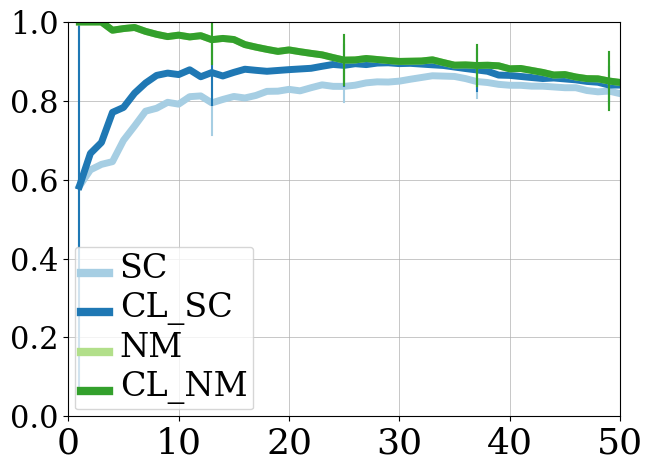

1it [00:08,  8.06s/it]

method=CL_SC, confident_joint_thresh=[1196]
method=CL_SC, confident_joint_thresh=[1081]
method=CL_SC, confident_joint_thresh=[817]
method=CL_SC, confident_joint_thresh=[867]
method=CL_SC, confident_joint_thresh=[791]
method=CL_SC, confident_joint_thresh=[792]
method=CL_SC, confident_joint_thresh=[855]
method=CL_SC, confident_joint_thresh=[737]
method=CL_SC, confident_joint_thresh=[533]
method=CL_SC, confident_joint_thresh=[520]
method=CL_SC, confident_joint_thresh=[477]
method=CL_SC, confident_joint_thresh=[444]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thre

/tmp/ipykernel_10862/3650408863.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


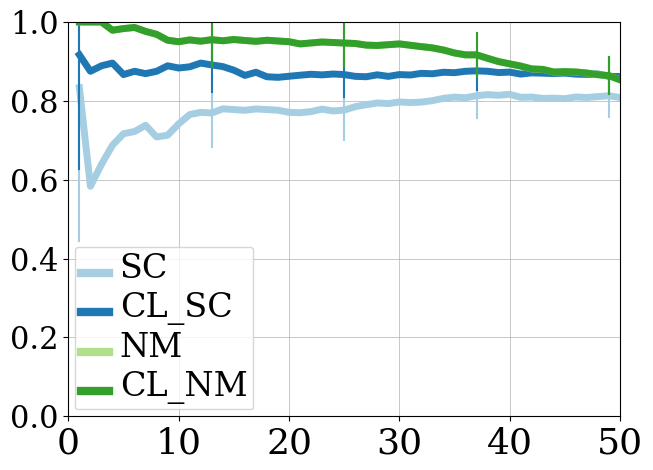

2it [00:16,  8.12s/it]

method=CL_SC, confident_joint_thresh=[659]
method=CL_SC, confident_joint_thresh=[494]
method=CL_SC, confident_joint_thresh=[477]
method=CL_SC, confident_joint_thresh=[458]
method=CL_SC, confident_joint_thresh=[430]
method=CL_SC, confident_joint_thresh=[433]
method=CL_SC, confident_joint_thresh=[396]
method=CL_SC, confident_joint_thresh=[441]
method=CL_SC, confident_joint_thresh=[445]
method=CL_SC, confident_joint_thresh=[343]
method=CL_SC, confident_joint_thresh=[343]
method=CL_SC, confident_joint_thresh=[344]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh=[None]
method=SC, confident_joint_thresh

In [6]:
from matplotlib.ticker import FuncFormatter
from statistics import mean



def plot_patk_all(tmp_df, methods, tmp_figpath, xaxis, yaxis, topn, show_total):
    sns.set_palette("Paired")
    methods = ['SC', 'CL_SC', 'NM', 'CL_NM']
    print(f'methods={methods}')
    colors = sns.color_palette("Paired", len(methods))
    class_colors = {k: colors[i] for i, k in enumerate(methods)}
    # print(f'class_colors={class_colors}')
    hue_order = methods


    ax = sns.lineplot(data=tmp_df, x=xaxis, y=yaxis,  hue="method", markersize=1, linewidth=5,hue_order=hue_order, palette=class_colors, errorbar='sd', err_style='bars',err_kws={'errorevery': int(topn/4)})
    ax.set_ylim(0,1)
    # ax.set_ylim(auto=True)
    ax.set_xlim(xmin=0, xmax=topn)

    leg = ax.legend()
    for i in leg.legendHandles:
        i.set_linewidth(6)
    
    plt.setp(ax.get_legend().get_texts(), fontsize=24)
    ax.set(xlabel='', ylabel = '')
    ax.tick_params(axis='x', labelsize=26)
    ax.tick_params(axis='y', labelsize=22)
    # ax.get_legend().set_visible(False)

    plt.grid(linewidth = 0.5)
    plt.tight_layout()
    plt.savefig(f'{tmp_figpath}', dpi=80)
    plt.show()

    ################### Area under Curve ###################
    # Compute AUC for each class
    unique_methods = tmp_df['method'].unique()
    auc_results = {k: {} for k in unique_methods}
    epos = list(range(1, 13))

    for method in unique_methods:
        epo_aucs = []
        # epo_cf_threshs = []
        for epo in epos:
            epo_df = tmp_df.loc[(tmp_df['method']==method)&(tmp_df['epoch']==epo)].sort_values(by='interval')
            auc = np.trapz(epo_df[yaxis], epo_df['interval'])
            confident_joint_thresh = epo_df['confident_joint_thresh'].unique()
            print(f'method={method}, confident_joint_thresh={confident_joint_thresh}')
            auc = auc/(1.0*len(epo_df['interval']))
            # epo_cf_threshs.append(confident_joint_thresh)
            epo_aucs.append(auc)

        # Normalize AUC by dividing it with the maximum possible AUC
        auc_dic = {'avg': np.average(epo_aucs),
                             'std': np.std(epo_aucs),
                             'aucs': epo_aucs,
                            #  'thresh_avg': np.average(epo_cf_threshs),
                            #  'thresh_std': np.std(epo_cf_threshs),
                            #  'thresh_aucs': epo_cf_threshs,
                             }
        auc_results[method].update(auc_dic)

    print('AUC Results')
    pp.pprint(auc_results)
    print('')

    return auc_results

############################################
##################  Per Class  ##################
start = time.time()
epos = list(range(1, 13))
m_names = ['val_split01', 'swin-t_val_split01']
methods = ['CL_SC',  'SC','CL_NM', 'NM']


topn = 50
show_total = True
cut_by_confident_joint = False
# cut_by_confident_joint = True   # never use

# Default to all
classname = 'all'
xaxis = 'interval'
# xaxis = 'interval_percent'
yaxis = 'patk_mi' # equal to patk_all
# yaxis = 'patk_ambi_mi' # equal to patk_all
# yaxis = 'patk'   # never use

# precision are top k here
colnames = ['epoch', 'model', 'method', 'interval', 'interval_percent', 'classname', 'patk_mi', 'patk_ambi_mi', 'confident_joint_thresh']

auc_dic = {m: {} for m in m_names}
for i, m_name in tqdm(enumerate(m_names)):

    tmp_df = pd.DataFrame(columns=colnames)

    for method in methods:

        for epo in epos:

            # print(f'Process {m_name} {method} {epo}')
            df = m_dic[m_name][epo].copy()
            patk_mi_list = topn_dic[m_name][epo][method][classname]
            patk_mi_ambi_list = topn_ambi_dic[m_name][epo][method][classname]

            if method[:3] == 'CL_':
                selected_idxs = df.loc[df[method] != 999999].index.values
                confident_joint_thresh = len(selected_idxs)
            else:
                confident_joint_thresh = None

            intervals = np.array(list(range(1,201)))
            intervals_percent = intervals / 100.0

            for patk_mi, patk_mi_ambi, interval, interval_percent in zip(patk_mi_list, patk_mi_ambi_list, intervals, intervals_percent):

                row =  [epo, m_name, method, interval, interval_percent, classname, patk_mi, patk_mi_ambi, confident_joint_thresh]

                tmp_df = pd.concat([tmp_df, pd.DataFrame([row], columns=colnames)], ignore_index=True)

    if cut_by_confident_joint is False:
        figdir = f'/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/BDD100K_rcnn/bdd100k_rcnn_all_{yaxis}'

        # process_interval_precision(tmp_df, figpath, grouped_filepath, yaxis, topn, cut_by_confident_joint, total_c_incorrect, show_total)
    
    if os.path.exists(figdir) is False:
        os.makedirs(figdir)
        
    tmp_figpath = f'{figdir}/{m_name}.png'
    auc_result = plot_patk_all(tmp_df, methods, tmp_figpath, xaxis, yaxis, topn, show_total)

    auc_dic.update({m_name: auc_result})
    print(f'---------------- end of {m_name} ----------------')


if topn is not None:
    auc_dic_path = './postprocessing/code/DataFrame/BDD100K/aed_auc'
    auc_filepath = f'{auc_dic_path}/top{topn}_{yaxis}.pkl'
else:
    assert topn == None
    auc_dic_path = './postprocessing/code/DataFrame/BDD100K/aed_auc'
    auc_filepath = f'{auc_dic_path}/cj_{yaxis}.pkl'

with open (auc_filepath, 'wb') as f:
    pickle.dump(auc_dic, f)

end = time.time()
duration = end-start
time_format = time.strftime("%H:%M:%S", time.gmtime(duration))
print(f'duration={time_format}')
print('')

# Show images / Save Single Image

In [4]:
from skimage.draw import polygon_perimeter
import cv2

def draw_bboxes(img, gt_bboxes, gt_labels, gt_labels_des, pred_labels, pred_labels_des, name2RGB, name2white, isshow, isfont):

    for idx, (gt_bbox, gt_label, gt_label_des, pred_label, pred_label_des) in enumerate(zip(gt_bboxes, gt_labels, gt_labels_des, pred_labels, pred_labels_des)):

        ymin, xmin, ymax, xmax = [int(i) for i in gt_bbox]
        
        # start = (xmin, ymin)
        # end = (xmax, ymax)
        r = [xmin, xmax, xmax, xmin, xmin]
        c = [ymax, ymax, ymin, ymin, ymax]
        rr, cc = polygon_perimeter(r, c, img.shape)
        # rr, cc = polygon_perimeter(start, end=end, shape=img.shape)
        rgb = name2RGB[gt_label_des]
        img[rr, cc ,0] = rgb[0]
        img[rr, cc ,1] = rgb[1]
        img[rr, cc ,2] = rgb[2]

        if isfont is True:
            font = cv2.FONT_HERSHEY_SIMPLEX
            text_org = (ymin, xmin-2)

            if gt_label_des == 'traffic sign':
                gt_label_des = 'sign'
            elif gt_label_des == 'traffic light':
                gt_label_des = 'light'

            labeltext = f'{gt_label_des}'
            cv2.putText(img, labeltext, text_org, font, 0.5, rgb, 1)

    # print(f'img.shape={img.shape}')
    # img = np.moveaxis(img, 0, -1)
    
    # dpi = 150
    # fig = plt.figure(dpi=dpi, figsize=(12,14))
    # plt.imshow(img)
    if isshow is True:
        dpi = 150
        fig = plt.figure(dpi=dpi, figsize=(7,9))
        plt.imshow(img)
    
    return img


def crop_bbox(xmin, ymin, xmax, ymax, img, img_shape, pad=0):
    img_xmax = img_shape[0]
    img_ymax = img_shape[1]
    xmin = int(xmin) - pad if int(xmin) - pad > 0 else 0
    ymin = int(ymin) - pad if int(ymin) - pad > 0 else 0
    xmax = int(xmax) + pad if int(xmin) + pad > 0 else img_xmax
    ymax = int(ymax) + pad if int(ymax) + pad > 0 else img_ymax

    # print(f'img.shape={img.shape}')
    cropped = img[xmin:xmax, ymin:ymax, :]
    # print(f'cropped.shape={cropped.shape}')
    return cropped
    

def crop_bboxes(img, img_shape, gt_bboxes, gt_labels, pad):
    bbox_imgs = []

    for idx, (bbox, labels) in enumerate(zip(gt_bboxes, gt_labels)):
        ymin, xmin, ymax, xmax = bbox
        
        bbox_img = crop_bbox(xmin, ymin, xmax, ymax, img, img_shape, pad)
        bbox_imgs.append(bbox_img)

    return bbox_imgs




# show particular image

Save to /home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/BDD100K_rcnn/single/pedestrian_b1d9e136-6c94ea3f_0_Predictive Probability.png


<Figure size 1050x600 with 0 Axes>

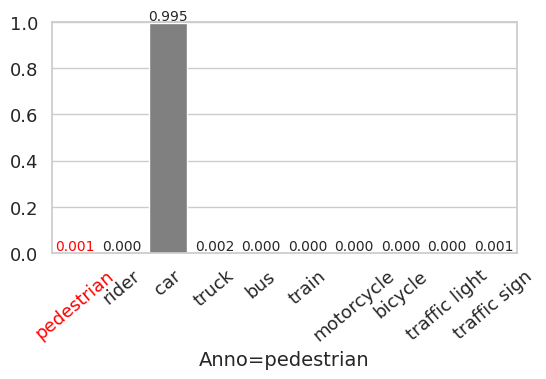

Save to /home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/BDD100K_rcnn/single/pedestrian_b1d9e136-6c94ea3f_0_Self-Confidence.png


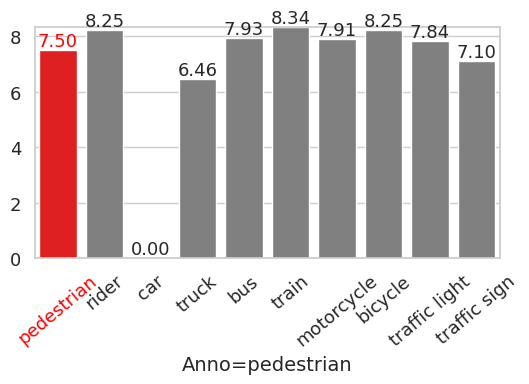

Save to /home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/BDD100K_rcnn/single/pedestrian_b1d9e136-6c94ea3f_0_Normalized Margin.png


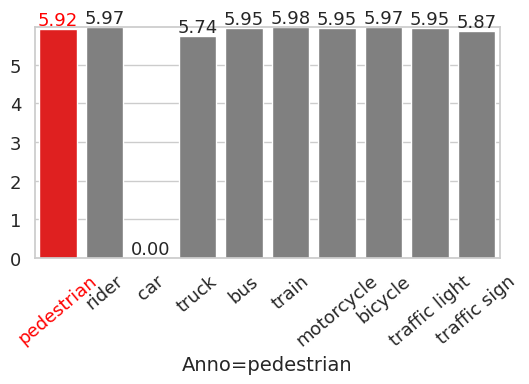

In [37]:


def draw_multirow_single(topn, df, yaxis, classname, classes, fig_path):

    sns.set_theme(style="whitegrid")

    df['maxprob'] = np.max(df['prob'])
    df['probnll'] =  -np.log(df['prob'])
    df['maxprobnll'] = np.max(df['probnll'])

    df['nm'] = cal_margin(df['prob'])
    df['nmnll'] = -np.log(df['nm'])
    df['maxnmnll'] = np.max(df['nmnll'])

    ylimit = None

    # pic_tuple = [4, None] # index and anno_bar
    # pic_tuple = [5, None] # index and anno_bar

    # for rank_i in [pic_tuple[0]]:

    item_df = df.copy()

    label_gt = item_df['label_gt']
    # pic_tuple[ 1] = label_gt
    label_gt_des = item_df['label_gt_des']
    label_pred = item_df['label_pred']
    label_pred_des = item_df['label_pred_des']

    maxprob_i = item_df['maxprob']
    # maxprob_i2 = class_df['maxprob']
    # assert maxprob_i == maxprob_i2, f'maxprob_i={maxprob_i}, maxprob_i2={maxprob_i2}'

    probnll = item_df['probnll']
    maxprobnll = np.max(df['maxprobnll'])
    # maxprobnll_i = item_df['maxprobnll']
    # maxprobnll_i2 = class_df['maxprobnll']
    # assert maxprobnll_i == maxprobnll_i2, f'maxprobnll_i={maxprobnll_i}, maxprobnll_i2={maxprobnll_i2}'

    nmnll = item_df['nmnll']
    maxnmnll = np.max(df['maxnmnll'])
    # maxnmnll_i = item_df['maxnmnll']
    # maxnmnll_i2 = class_df['maxnmnll']
    # assert maxnmnll_i == maxnmnll_i2, f'maxnmnll_i={maxnmnll_i}, maxnmnll_i2={maxnmnll_i2}'

    d = {'probnll': item_df['probnll'], 'prob': item_df['prob'], 'class': classes, 'nmnll': item_df['nmnll']}
    df = pd.DataFrame(data=d)
    colors = ['red' if cname == label_gt_des else 'gray' for cname in df['class']]

    plt.figure(figsize=(6, 3))

    if yaxis == 'Predictive Probability':
        ylimit = 1
        yname = yaxis
        yshortname = 'prob'
        labels_str = [f'{i:.3f}' for i in df['prob']]
        g=sns.barplot(df, x="class", y="prob", palette=colors)
        barfontsize = 10


    elif yaxis == 'Self-Confidence':
        ylimit = maxprobnll
        yshortname = 'probnll'
        yname = 'Negative Log of Self-Confidence'
        labels_str = [f'{i:.2f}' for i in df['probnll']]
        g=sns.barplot(df, x="class", y="probnll", palette=colors)
        barfontsize = 13


    elif yaxis == 'Normalized Margin':
        ylimit = maxnmnll
        yshortname = 'nmnll'
        yname = 'Negative Log of Normalized Margin'
        labels_str = [f'{i:.2f}' for i in df['nmnll']]
        g=sns.barplot(df, x="class", y="nmnll", palette=colors)
        barfontsize = 13

    red_i = label_gt
    for container in g.containers:
        tboxes = g.bar_label(container, labels=labels_str, label_type='edge', fontsize=barfontsize)
        tboxes[red_i].set_color('red')

    ######################
    g.set_ylim([0, ylimit])
    g.tick_params(axis='y', labelsize=13)
    g.tick_params(axis='x', labelsize=13)

    plt.gca().get_xticklabels()[red_i].set_color("red")
    # plt.gca().get_xticklabels()[8].set_color("red")
    plt.xticks(rotation=40, ha='center')
    g.set_xlabel(f'Anno={label_gt_des}', fontsize=14)
    g.set_ylabel(f'')
    # g.get_ylabel().set_visible(False)
    plt.savefig(f'{fig_path}', dpi=80, bbox_inches="tight")
    print(f'Save to {fig_path}')
    plt.show()


m_name = 'val_split01'
ranked_by = 'NM'
epo = 8
# classname = 'all'

# hack
classname = 'pedestrian'

epo_df = m_dic[m_name][epo].copy()
if classname != 'all':
    class_df = epo_df.loc[epo_df['label_gt_des']==classname]
else:
    class_df = epo_df


fig_dirpath = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/BDD100K_rcnn/single'

########################################
#                     Save single bbox images
########################################

# filename = 'b50ff9e2-ebb775d4'
filename = 'b1d9e136-6c94ea3f'
# filename = 'b4e3816e-6cd8a1fe'

target_cnt = 0
class_df = class_df.loc[class_df['imgpath'].str.contains(filename)]
# item_df = class_df.iloc[target_cnt]

for cnt, (bbox_idx, row) in enumerate(class_df.iterrows()):
    # print(f'cnt={cnt}')
    # if filename not in row['imgpath']:
    #     continue

    if cnt != target_cnt:
        continue

    img = np.array(Image.open(row['imgpath']))
    img_shape = img.shape

    dpi = 150
    fig = plt.figure(dpi=dpi, figsize=(7,4))
    isshow = False
    isfont = True
    img_with_bbox = draw_bboxes(img, [row['bbox_gt']], [row['label_gt']], [row['label_gt_des']], [row['label_pred']], [row['label_pred_des']], name2RGB, name2white, isshow, isfont)

    plt.imshow(img_with_bbox, cmap="gray")
    plt.axis('off')
    
    # bbox_img = crop_bboxes(img_with_bbox, img_shape, [row['bbox_gt']], [row['label_gt']], pad=15)[0]


    if not os.path.isdir(fig_dirpath):
        os.makedirs(fig_dirpath, exist_ok=True)

    imgpath = row['imgpath'].replace(f'{data_dirpath}/bdd100k/bdd100k_images_100k/images/100k/val/', '')
    imgname = imgpath.replace('.jpg', '').replace('/', '_')

    plt.savefig(f"{fig_dirpath}/{classname}_{imgname}_{cnt}.png", bbox_inches='tight')
    plt.clf()

    classes = list(id2class.values())

    yaxis = 'Predictive Probability'
    fig_path = f'{fig_dirpath}/{classname}_{imgname}_{cnt}_{yaxis}.png'
    draw_multirow_single(topn, row, yaxis, classname, classes, fig_path)

    yaxis = 'Self-Confidence'
    fig_path = f'{fig_dirpath}/{classname}_{imgname}_{cnt}_{yaxis}.png'
    draw_multirow_single(topn, row, yaxis, classname, classes, fig_path)

    yaxis = 'Normalized Margin'
    fig_path = f'{fig_dirpath}/{classname}_{imgname}_{cnt}_{yaxis}.png'
    draw_multirow_single(topn, row, yaxis, classname, classes, fig_path)

    # cnt += 1
    if cnt > target_cnt:
        break








# Save Single image

[f'{data_dirpath}/bdd100k/bdd100k_images_100k/images/100k/val/b5ecfd7e-fcdaceb0.jpg'
 f'{data_dirpath}/bdd100k/bdd100k_images_100k/images/100k/val/b50ff9e2-ebb775d4.jpg'
 f'{data_dirpath}/bdd100k/bdd100k_images_100k/images/100k/val/b5450d0c-ccc3fb86.jpg'
 f'{data_dirpath}/bdd100k/bdd100k_images_100k/images/100k/val/b24bdca1-e4f0c558.jpg'
 f'{data_dirpath}/bdd100k/bdd100k_images_100k/images/100k/val/b4561bec-26a99096.jpg'
 f'{data_dirpath}/bdd100k/bdd100k_images_100k/images/100k/val/b50ff9e2-ebb775d4.jpg']


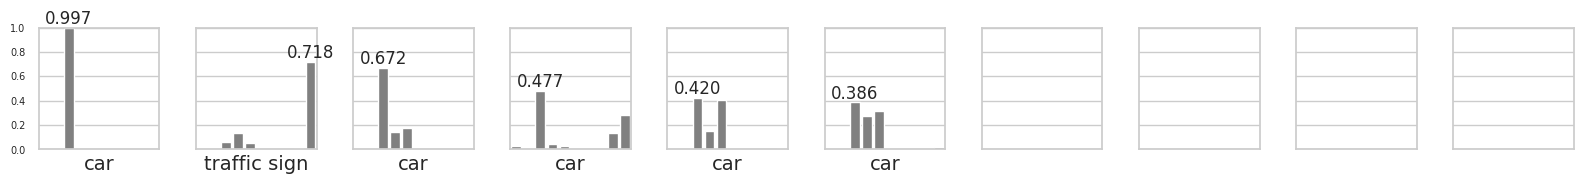

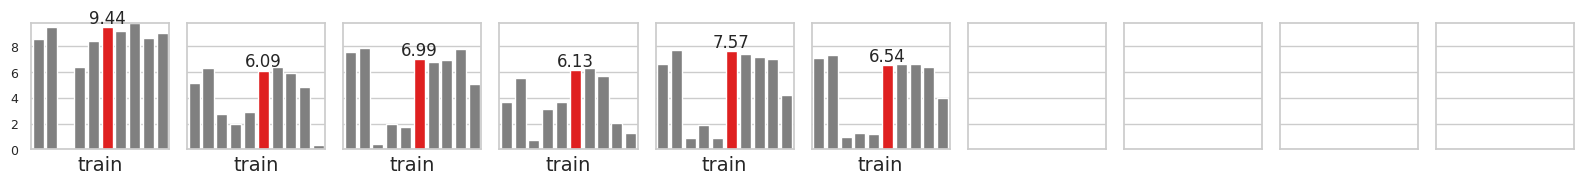

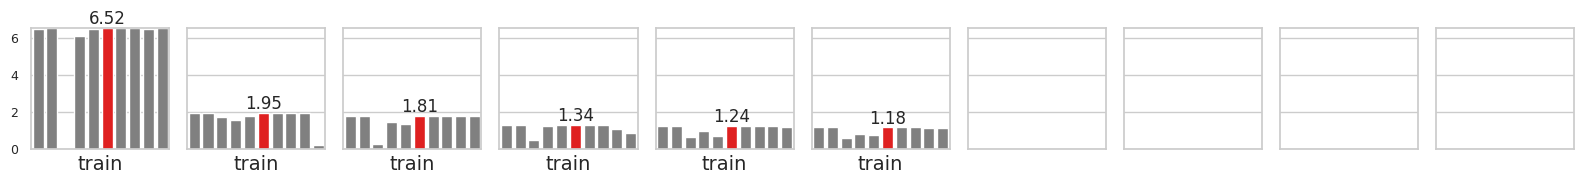

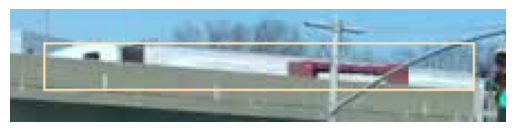

In [30]:
import warnings
warnings.filterwarnings('ignore')

m_names = ['val_split01', 'swin-t_val_split01']
m_name = 'val_split01'
epo = 9
start = 0
topn = 10
ranked_by = 'NM'
# classname = 'all'

# hack
classname = 'train'
# colnames = ["cls_score", "label_gt", "label_gt_des", "label_pred", "label_pred_des", "imgpath", "bbox_gt","prob", "CL_SC", "SC", "loss", "CL_NM", "NM"]

epo_df = m_dic[m_name][epo].copy()
if classname != 'all':
    class_df = epo_df.loc[epo_df['label_gt_des']==classname]
else:
    class_df = epo_df

# class_df = epo_df.loc[epo_df['label_gt_des']==classname]
class_df.sort_values(by=ranked_by, ascending=True, inplace=True)
# class_df = class_df.head(topn)
class_df = class_df.iloc[start:start+10]
print_str = class_df['imgpath'].values
print(print_str)

classes = list(id2class.values())

# print(f'{class_df["NM"]}')

# def draw_single_barplot(df, classes, yname, ylimit, colors, label_gt_des):
#     plt.figure(figsize=(6, 4))
#     colors = ['red' if cname == label_gt_des else 'gray' for cname in df['class']]
#     g=sns.barplot(df, x="class", y="nmnll", palette=colors)
#     labels_str = [f'{i:.2f}' for i in df['nmnll']]
#     # labels_str[label_gt] = f'{nmnll[label_gt]:.2f}'
#     for container in g.containers:
#         g.bar_label(container, labels=labels_str, label_type='edge')
#     ######################
#     g.set_ylim([0, ylimit])
#     g.tick_params(axis='y', labelsize=10)
#     g.tick_params(axis='x', labelsize=10)
#     plt.xticks(rotation=30, ha='center')
#     g.set_xlabel(f'Anno={label_gt_des}', fontsize=14)
#     g.set_ylabel(f'{yname}', fontsize=8)
#     plt.show()

def draw_multirow_single(topn, df, yaxis, classname, classes, fig_path):

    sns.set_theme(style="whitegrid")

    class_df['maxprob'] = class_df['prob'].apply(lambda x: np.max(x))
    class_df['probnll'] = class_df['prob'].apply(lambda x: -np.log(x))
    class_df['maxprobnll'] = class_df['probnll'].apply(lambda x: np.max(x))

    class_df['nm'] = class_df['prob'].apply(lambda x: cal_margin(x))
    class_df['nmnll'] = class_df['nm'].apply(lambda x: -np.log(x))
    class_df['maxnmnll'] = class_df['nmnll'].apply(lambda x: np.max(x))

    ylimit = None

    pic_tuple = [4, None] # index and anno_bar
    # pic_tuple = [5, None] # index and anno_bar

    for rank_i in [pic_tuple[0]]:

        item_df = class_df.iloc[rank_i]

        label_gt = item_df['label_gt']
        pic_tuple[ 1] = label_gt
        label_gt_des = item_df['label_gt_des']
        label_pred = item_df['label_pred']
        label_pred_des = item_df['label_pred_des']

        maxprob_i = item_df['maxprob']
        maxprob_i2 = class_df['maxprob'].iloc[rank_i]
        assert maxprob_i == maxprob_i2, f'maxprob_i={maxprob_i}, maxprob_i2={maxprob_i2}'

        probnll = item_df['probnll']
        maxprobnll = np.max(class_df['maxprobnll'])
        maxprobnll_i = item_df['maxprobnll']
        maxprobnll_i2 = class_df['maxprobnll'].iloc[rank_i]
        assert maxprobnll_i == maxprobnll_i2, f'maxprobnll_i={maxprobnll_i}, maxprobnll_i2={maxprobnll_i2}'

        nmnll = item_df['nmnll']
        maxnmnll = np.max(class_df['maxnmnll'])
        maxnmnll_i = item_df['maxnmnll']
        maxnmnll_i2 = class_df['maxnmnll'].iloc[rank_i]
        assert maxnmnll_i == maxnmnll_i2, f'maxnmnll_i={maxnmnll_i}, maxnmnll_i2={maxnmnll_i2}'

        d = {'probnll': item_df['probnll'], 'prob': item_df['prob'], 'class': classes, 'nmnll': item_df['nmnll']}
        df = pd.DataFrame(data=d)
        colors = ['red' if cname == label_gt_des else 'gray' for cname in df['class']]

        plt.figure(figsize=(6, 3))

        if yaxis == 'Predictive Probability':
            ylimit = 1
            yname = yaxis
            yshortname = 'prob'
            labels_str = [f'{i:.3f}' for i in df['prob']]
            g=sns.barplot(df, x="class", y="prob", palette=colors)
            barfontsize = 10


        elif yaxis == 'Self-Confidence':
            ylimit = maxprobnll
            yshortname = 'probnll'
            yname = 'Negative Log of Self-Confidence'
            labels_str = [f'{i:.2f}' for i in df['probnll']]
            g=sns.barplot(df, x="class", y="probnll", palette=colors)
            barfontsize = 13


        elif yaxis == 'Normalized Margin':
            ylimit = maxnmnll
            yshortname = 'nmnll'
            yname = 'Negative Log of Normalized Margin'
            labels_str = [f'{i:.2f}' for i in df['nmnll']]
            g=sns.barplot(df, x="class", y="nmnll", palette=colors)
            barfontsize = 13

        red_i = pic_tuple[1]
        for container in g.containers:
            tboxes = g.bar_label(container, labels=labels_str, label_type='edge', fontsize=barfontsize)
            tboxes[red_i].set_color('red')
        ######################
        g.set_ylim([0, ylimit])
        g.tick_params(axis='y', labelsize=13)
        g.tick_params(axis='x', labelsize=13)

        plt.gca().get_xticklabels()[red_i].set_color("red")
        # plt.gca().get_xticklabels()[8].set_color("red")
        plt.xticks(rotation=40, ha='center')
        g.set_xlabel(f'Anno={label_gt_des}', fontsize=14)
        g.set_ylabel(f'')
        # g.get_ylabel().set_visible(False)
        plt.savefig(f'{fig_dirpath}/{rank_i+1}th_{yshortname}.png', dpi=80, bbox_inches="tight")
        print(f'Save to {fig_dirpath}/{rank_i+1}_{yshortname}.png')
        plt.show()



def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_max(array, value):
    return np.max(array)

def cal_margin(arr):
    margins = []
    for i, prob in enumerate(arr):

        new_arr = np.delete(arr, i)
        next_prob = find_max(new_arr, value=prob)
        margin = ((prob - next_prob) +1)/2
        margins.append(margin)
    
    # print(f'margins={margins}')
    margins = np.absolute(margins)

    return margins

def draw_multirow(topn, df, yaxis, classname, classes, fig_path):
    fig, axes = plt.subplots(nrows=1, ncols=10, sharey=True, sharex=True, figsize=(16, 2))
    # fig, axes = plt.subplots(nrows=1, ncols=topn, sharey=True, sharex=True, figsize=(16, 2), constrained_layout=True)
    sns.set_theme(style="whitegrid")

    # fig.suptitle(f'{yaxis}', fontsize=12)


    class_df['maxprob'] = class_df['prob'].apply(lambda x: np.max(x))
    class_df['probnll'] = class_df['prob'].apply(lambda x: -np.log(x))
    class_df['maxprobnll'] = class_df['probnll'].apply(lambda x: np.max(x))

    class_df['nm'] = class_df['prob'].apply(lambda x: cal_margin(x))
    class_df['nmnll'] = class_df['nm'].apply(lambda x: -np.log(x))
    class_df['maxnmnll'] = class_df['nmnll'].apply(lambda x: np.max(x))

    ylimit = None

    rangemax = 10
    if len(class_df) < 10:
        rangemax = len(class_df)

    for rank_i, ax in zip(range(0, rangemax), axes.flatten()):

        item_df = class_df.iloc[rank_i]

        label_gt = item_df['label_gt']
        label_gt_des = item_df['label_gt_des']
        label_pred = item_df['label_pred']
        label_pred_des = item_df['label_pred_des']

        maxprob_i = item_df['maxprob']
        maxprob_i2 = class_df['maxprob'].iloc[rank_i]
        assert maxprob_i == maxprob_i2, f'maxprob_i={maxprob_i}, maxprob_i2={maxprob_i2}'

        probnll = item_df['probnll']
        maxprobnll = np.max(class_df['maxprobnll'])
        maxprobnll_i = item_df['maxprobnll']
        maxprobnll_i2 = class_df['maxprobnll'].iloc[rank_i]
        assert maxprobnll_i == maxprobnll_i2, f'maxprobnll_i={maxprobnll_i}, maxprobnll_i2={maxprobnll_i2}'

        nmnll = item_df['nmnll']
        maxnmnll = np.max(class_df['maxnmnll'])
        maxnmnll_i = item_df['maxnmnll']
        maxnmnll_i2 = class_df['maxnmnll'].iloc[rank_i]
        assert maxnmnll_i == maxnmnll_i2, f'maxnmnll_i={maxnmnll_i}, maxnmnll_i2={maxnmnll_i2}'

        d = {'probnll': item_df['probnll'], 'prob': item_df['prob'], 'class': classes, 'nmnll': item_df['nmnll']}
        df = pd.DataFrame(data=d)
        colors = ['red' if cname == label_gt_des else 'gray' for cname in df['class']]

        if yaxis == 'Predictive Probability':
            ax.set_ylim([0, 1])
            g1 = sns.barplot(df, x="class", y="prob", ax=ax, palette=colors)

            labels_str = ['']*len(classes)
            labels_str[label_pred] = f'{maxprob_i:.3f}'
            for container in g1.containers:
                ax.bar_label(container, labels=labels_str, label_type='edge')

            ax.tick_params(axis='y', labelsize=7)
            ax.set_xlabel(label_pred_des, fontsize=14)

            # if rank_i in [4, 5]:
            #     yname = 'Predictive Probability'
            #     draw_single_barplot(df, classes,yname, ylimit, colors, label_gt_des)

        elif yaxis == 'Self-Confidence':
            ylimit = maxprobnll
            ax.set_ylim([0, ylimit])
            g2 = sns.barplot(df, x="class", y="probnll", ax=ax, palette=colors)

            ######################
            # add bar label
            labels_str = ['']*len(classes)
            labels_str[label_gt] = f'{probnll[label_gt]:.2f}'
            for container in g2.containers:
                ax.bar_label(container, labels=labels_str, label_type='edge')
            ######################
            ax.tick_params(axis='y', labelsize=9)
            ax.set_xlabel(label_gt_des, fontsize=14)

            # if rank_i in [4, 5]:
            #     yname = 'Negative Log of Self-Confidence'
            #     draw_single_barplot(df, classes,yname, ylimit, colors, label_gt_des)


        elif yaxis == 'Normalized Margin':
            ylimit = maxnmnll
            ######################
            # add bar label
            g3=sns.barplot(df, x="class", y="nmnll", ax=ax, palette=colors)
            labels_str = ['']*len(classes)
            labels_str[label_gt] = f'{nmnll[label_gt]:.2f}'
            for container in g3.containers:
                ax.bar_label(container, labels=labels_str, label_type='edge')
            ######################
            ax.set_ylim([0, ylimit])
            ax.tick_params(axis='y', labelsize=9)
            ax.set_xlabel(label_gt_des, fontsize=14)

            # if rank_i in [4, 5]:
            #     yname = 'Negative Log of Normalized Margin'
            #     draw_single_barplot(df, classes,yname, ylimit, colors, label_gt_des)
        
        # if rank_i < topn:
        # print(f'probnll={probnll[class2id[classname]]}, prob={prob[class2id[classname]]}, nm={nm[class2id[classname]]}')

        
        ax.set(ylabel = '')
        # ax.tick_params(axis='x', labelsize=26)
        
        # ax.get_legend().set_visible(False)
        ax.set_xticks([])
        # ax.set_yticks([])

    plt.tight_layout()
    plt.savefig(f'{fig_path}', dpi=110)
    plt.show()

fig_dirpath = f'/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/BDD100K_rcnn/perclass_{classname}_{ranked_by}'

if not os.path.isdir(fig_dirpath):
    os.makedirs(fig_dirpath, exist_ok=True)

yaxis = 'Predictive Probability'
fig_path = f'{fig_dirpath}/{classname}_prob.png'
draw_multirow(topn, class_df, yaxis, classname, classes, fig_path)
# draw_multirow_single(topn, class_df, yaxis, classname, classes, fig_dirpath)

yaxis = 'Self-Confidence'
fig_path = f'{fig_dirpath}/{classname}_SC.png'
draw_multirow(topn, class_df, yaxis, classname, classes, fig_path)
# draw_multirow_single(topn, class_df, yaxis, classname, classes, fig_dirpath)

yaxis = 'Normalized Margin'
fig_path = f'{fig_dirpath}/{classname}_NM.png'
draw_multirow(topn, class_df, yaxis, classname, classes, fig_path)
# draw_multirow_single(topn, class_df, yaxis, classname, classes, fig_dirpath)

########################################
#                     Save single bbox images
########################################
cnt = 0
for bbox_idx, row in class_df.iterrows():
    img = np.array(Image.open(row['imgpath']))
    img_shape = img.shape

    isshow = False
    isfont = False
    img_with_bbox = draw_bboxes(img, [row['bbox_gt']], [row['label_gt']], [row['label_gt_des']], [row['label_pred']], [row['label_pred_des']], name2RGB, name2white, isshow, isfont)

    bbox_img = crop_bboxes(img_with_bbox, img_shape, [row['bbox_gt']], [row['label_gt']], pad=15)[0]

    plt.imshow(bbox_img, cmap="gray")
    plt.axis('off')
    

    if not os.path.isdir(fig_dirpath):
        os.makedirs(fig_dirpath, exist_ok=True)

    imgpath = row['imgpath'].replace(f'{data_dirpath}/bdd100k/bdd100k_images_100k/images/100k/val/', '')
    imgname = imgpath.replace('.jpg', '').replace('/', '_')

    plt.savefig(f"{fig_dirpath}/{classname}_{cnt}_{imgname}.png", bbox_inches='tight')
    

    # print(f'bbox_idx={bbox_idx}, classname={classname}')
    cnt += 1

    if cnt > topn:
        break



#     bdd100k_det = {
#     0: "pedestrian",
#     1: "rider",
#     2: "car",
#     3: "truck",
#     4: "bus",
#     5: "train",
#     6: "motorcycle",
#     7: "bicycle",
#     8: "traffic light",
#     9: "traffic sign",
#     10: "bg",
# }

# shift_det = {
#     0: "pedestrian",
#     1: "car",
#     2: "truck",
#     3: "bus",
#     4: "motorcycle",
#     5: "bicycle",
#     6: "bg"
# }

# peak_mapper = {
#     "pedestrian": "bicycle",
#     "car": "bus",
#     "truck": "car",
#     "bus": "truck",
#     "motorcycle": "bicycle",
#     "bicycle": "motorcycle",
# }


# T-Test

In [8]:
# auc_patk_dic = auc_dic
import scipy
from scipy.stats import ttest_ind, combine_pvalues

m_names = ['val_split01', 'swin-t_val_split01']
import scipy
from scipy.stats import ttest_ind, combine_pvalues


# auc_patk_dic_filepath = './postprocessing/code/DataFrame/BDD100K/aed_auc/cj_patk_mi.pkl'
auc_patk_dic_filepath = './postprocessing/code/DataFrame/BDD100K/aed_auc/top200_patk_mi.pkl'

with open(auc_patk_dic_filepath, 'rb') as f:
    auc_patk_dic = pickle.load(f)


auc_dic = auc_patk_dic

def compare_effectiveness_cl(m_names, methods):
    t_values = []
    p_values = []

    for m_name in m_names:
        # df = perform_dic[m_name].copy()

        for (cl, rank) in methods:
            a=auc_dic[m_name][cl]['aucs']
            b=auc_dic[m_name][rank]['aucs']

            result = scipy.stats.ttest_ind(a, b, axis=0, alternative='two-sided')
            t_values.append(result.statistic)
            p_values.append(result.pvalue)
            # print(f'{m_name}, {cl}, {rank}, t-value={result.statistic[0]}, p-value={result.pvalue[0]}')
    combined_pvalue = np.average(p_values)
    # print(f'{m_name}, combined_pvalue={combined_pvalue[0]}, combined p-value={combined_pvalue[1]}')

    return t_values, p_values, combined_pvalue

print(f'----- Self-Confidence -----')
methods = [('SC', 'CL_SC')]
t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
print(f'Combined p-value={combined_pvalue}')



tvalue_latex = ' & '.join([f'{i:.2f}' for i in t_values])
pvalue_latex = ' & '.join([f'{i:.2f}' for i in p_values])
print(f't-values = {tvalue_latex}')
print(f'p-values = {pvalue_latex}')


print(' ')
print(f'----- Normalized Margin -----')
methods = [('NM', 'CL_NM')]
t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
print(f'Combined p-value={combined_pvalue}')



tvalue_latex = ' & '.join([f'{i:.2f}' for i in t_values])
pvalue_latex = ' & '.join([f'{i:.2f}' for i in p_values])
print(f't-values = {tvalue_latex}')
print(f'p-values = {pvalue_latex}')

----- Self-Confidence -----
Combined p-value=0.3198567630955753
t-values = -0.80 & -1.30
p-values = 0.43 & 0.21
 
----- Normalized Margin -----
Combined p-value=0.8888153885823409
t-values = -0.19 & -0.09
p-values = 0.85 & 0.93


#  Correlation between Model performance and AED performance
## All epoch, to use more sample points

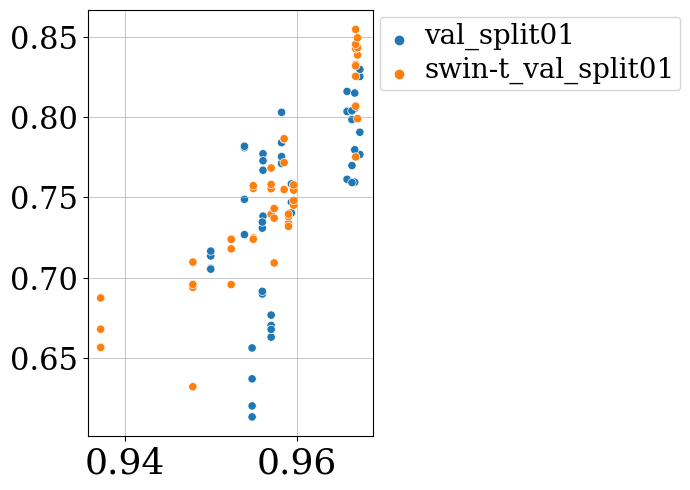


----- ('val_split01', 'SC') -----
Sample size = 12
pearsonr=PearsonRResult(statistic=0.6156049529388103, pvalue=0.033089173809886616)
spearmanr=SignificanceResult(statistic=0.7692307692307694, pvalue=0.0034464502618274493)
----- ('val_split01', 'CL_SC') -----
Sample size = 12
pearsonr=PearsonRResult(statistic=0.5877519720941, pvalue=0.04445580397905102)
spearmanr=SignificanceResult(statistic=0.6923076923076924, pvalue=0.012593030496094107)
----- ('val_split01', 'NM') -----
Sample size = 12
pearsonr=PearsonRResult(statistic=0.6834892329320821, pvalue=0.014264721473509233)
spearmanr=SignificanceResult(statistic=0.7272727272727274, pvalue=0.007355028857805126)
----- ('val_split01', 'CL_NM') -----
Sample size = 12
pearsonr=PearsonRResult(statistic=0.709095685132644, pvalue=0.009817074876215326)
spearmanr=SignificanceResult(statistic=0.7132867132867133, pvalue=0.009201779777634755)
----- ('swin-t_val_split01', 'SC') -----
Sample size = 12
pearsonr=PearsonRResult(statistic=0.884372697074078

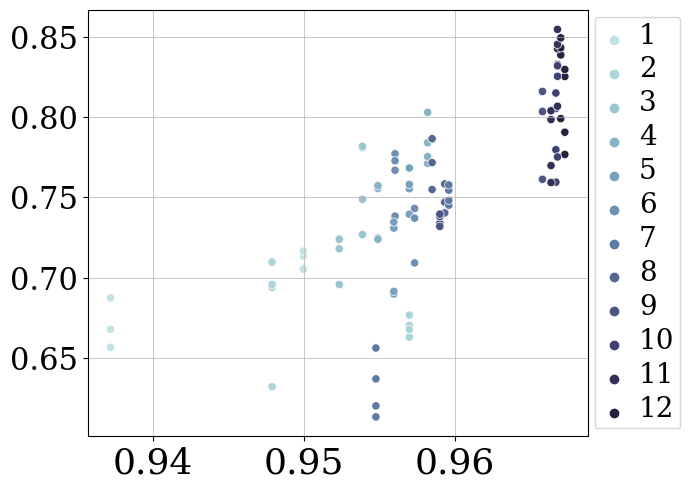


----- (1, 'SC') -----
Sample size = 2
pearsonr=PearsonRResult(statistic=1.0, pvalue=1.0)
spearmanr=SignificanceResult(statistic=0.9999999999999999, pvalue=nan)
----- (1, 'CL_SC') -----
Sample size = 2
pearsonr=PearsonRResult(statistic=1.0, pvalue=1.0)
spearmanr=SignificanceResult(statistic=0.9999999999999999, pvalue=nan)
----- (1, 'NM') -----
Sample size = 2
pearsonr=PearsonRResult(statistic=1.0, pvalue=1.0)
spearmanr=SignificanceResult(statistic=0.9999999999999999, pvalue=nan)
----- (1, 'CL_NM') -----
Sample size = 2
pearsonr=PearsonRResult(statistic=1.0, pvalue=1.0)
spearmanr=SignificanceResult(statistic=0.9999999999999999, pvalue=nan)
----- (2, 'SC') -----
Sample size = 2
pearsonr=PearsonRResult(statistic=1.0, pvalue=1.0)
spearmanr=SignificanceResult(statistic=0.9999999999999999, pvalue=nan)
----- (2, 'CL_SC') -----
Sample size = 2
pearsonr=PearsonRResult(statistic=-1.0, pvalue=1.0)
spearmanr=SignificanceResult(statistic=-0.9999999999999999, pvalue=nan)
----- (2, 'NM') -----
Sample

{(1, 'SC'): [PearsonRResult(statistic=1.0, pvalue=1.0),
  SignificanceResult(statistic=0.9999999999999999, pvalue=nan)],
 (1, 'CL_SC'): [PearsonRResult(statistic=1.0, pvalue=1.0),
  SignificanceResult(statistic=0.9999999999999999, pvalue=nan)],
 (1, 'NM'): [PearsonRResult(statistic=1.0, pvalue=1.0),
  SignificanceResult(statistic=0.9999999999999999, pvalue=nan)],
 (1, 'CL_NM'): [PearsonRResult(statistic=1.0, pvalue=1.0),
  SignificanceResult(statistic=0.9999999999999999, pvalue=nan)],
 (2, 'SC'): [PearsonRResult(statistic=1.0, pvalue=1.0),
  SignificanceResult(statistic=0.9999999999999999, pvalue=nan)],
 (2, 'CL_SC'): [PearsonRResult(statistic=-1.0, pvalue=1.0),
  SignificanceResult(statistic=-0.9999999999999999, pvalue=nan)],
 (2, 'NM'): [PearsonRResult(statistic=-1.0, pvalue=1.0),
  SignificanceResult(statistic=-0.9999999999999999, pvalue=nan)],
 (2, 'CL_NM'): [PearsonRResult(statistic=-1.0, pvalue=1.0),
  SignificanceResult(statistic=-0.9999999999999999, pvalue=nan)],
 (3, 'SC'): [P

In [10]:
from scipy.stats import pearsonr, spearmanr
from scipy.stats import ttest_ind

m_names = ['val_split01', 'swin-t_val_split01']
methods = ['SC', 'CL_SC', 'NM','CL_NM']

# auc_patk_dic_filepath = './postprocessing/code/DataFrame/BDD100K/aed_auc/cj_patk_mi.pkl'
auc_patk_dic_filepath = './postprocessing/code/DataFrame/BDD100K/aed_auc/top200_patk_mi.pkl'


columns = ['epoch', 'model_precision', 'aed_patk', 'aed_method', 'noise_pattern']


with open(auc_patk_dic_filepath, 'rb') as f:
    auc_patk_dic = pickle.load(f)


auc_dic = auc_patk_dic

precision_mi_list = []
method_auc ={m: [] for m in methods}
correlation_df = pd.DataFrame(columns=columns)

for m_name in m_names:
    model_perf_df = perform_dic[m_name].copy()

    precision_ma = model_perf_df['precision_ma'].values.tolist()
    recall_ma = model_perf_df['recall_ma'].values.tolist()
    # f1_ma = df['f1_ma'].values.tolist()

    precision_mi = model_perf_df['precision_mi'].values.tolist()
    recall_mi = model_perf_df['recall_mi'].values.tolist()
    # f1_mi = df['f1_mi'].values.tolist()

    precision_mi_list.extend(precision_mi)

    auc_result = auc_dic[m_name]

    for method in methods:
        aed_patk = auc_patk_dic[m_name][method]['aucs']
        # aed_ratk = auc_ratk_dic[m_name][method]['aucs']
        # aed_patk = [i[0] for i in aed_patk]
        # aed_ratk = [i[0] for i in aed_ratk]
        method_list = [method]*len(aed_patk)
        noise_pattern_list = [m_name]*len(aed_patk)
        epos = list(range(1, len(aed_patk)+1))

        method_auc[method].extend(method * len(aed_patk))

        row_df = pd.DataFrame(list(zip(epos, precision_mi, aed_patk, method_list, noise_pattern_list)), columns=columns)
        correlation_df = pd.concat([correlation_df, row_df], ignore_index=True)
    
    print('')



def cal_correlation(stat, model_perf_list, method_auc):
    if stat == 'spearmanr':
        sc = spearmanr(model_perf_list, method_auc['SC'], alternative='two-sided')
        cl_sc = spearmanr(model_perf_list, method_auc['CL_SC'], alternative='two-sided')
        nm = spearmanr(model_perf_list, method_auc['NM'], alternative='two-sided')
        cl_nm = spearmanr(model_perf_list, method_auc['CL_NM'], alternative='two-sided')

    elif stat == 'pearsonr':
        sc = pearsonr(model_perf_list, method_auc['SC'], alternative='two-sided')
        cl_sc = pearsonr(model_perf_list, method_auc['CL_SC'], alternative='two-sided')
        nm = pearsonr(model_perf_list, method_auc['NM'], alternative='two-sided')
        cl_nm = pearsonr(model_perf_list, method_auc['CL_NM'], alternative='two-sided')


    print(f'{stat}')
    print(f'SC={sc}')
    print(f'CL_SC={cl_sc}')
    print(f'NM={nm}')
    print(f'CL_NM={cl_nm}')


# df = pd.DataFrame({'model_precision': precision_mi_list, 'SC': method_auc['SC'], 'CL_SC': method_auc['CL_SC'], 'NM': method_auc['NM'], 'CL_NM': method_auc['CL_NM']})

# df = pd.melt(df, id_vars=['model_precision'], value_vars=['SC', 'CL_SC', 'NM', 'CL_NM'])

def draw_scatterplot(df, xaxis, yaxis, hue, is_range01):
    plt.figure(figsize=(7, 5))

    if hue == 'epoch' :
        hue_order = df['epoch'].unique().tolist()
        palette_colors = sns.color_palette("ch:start=.2,rot=-.3", len(hue_order))
        palette_dict = {l: color for l, color in zip(hue_order, palette_colors)}
        ax = sns.scatterplot(df, x=xaxis, y=yaxis, hue=hue, hue_order=hue_order, palette=palette_dict)

    elif hue == 'noise_pattern':
        hue_order = m_names
        ax = sns.scatterplot(df, x=xaxis, y=yaxis, hue=hue, hue_order=hue_order)
    else:
        ax = sns.scatterplot(df, x=xaxis, y=yaxis, hue=hue)

    if is_range01 is True:
        plt.xlim(0, 1)
        plt.ylim(0, 1)

    ax.legend(bbox_to_anchor=(1, 1))

    plt.setp(ax.get_legend().get_texts(), fontsize=20)
    ax.set(xlabel='', ylabel = '')
    ax.tick_params(axis='x', labelsize=26)
    ax.tick_params(axis='y', labelsize=22)
    # ax.get_legend().set_visible(False)

    plt.grid(linewidth = 0.5)
    plt.tight_layout()
    # plt.savefig(f'{tmp_figpath}', dpi=80)
    plt.show()
    
    category_aed_methods = pd.api.types.CategoricalDtype(categories=methods, ordered=True)
    df['aed_method'] = df['aed_method'].astype(category_aed_methods)

    grouped_df = None
    if hue == 'noise_pattern':
        category_hue = pd.api.types.CategoricalDtype(categories=m_names, ordered=True)
        df[hue] = df[hue].astype(category_hue)
        grouped_df = df.groupby([hue, 'aed_method'])
        print('')

    elif hue == 'epoch':
        category_hue = pd.api.types.CategoricalDtype(categories=list(range(1, 9)), ordered=True)
        df[hue] = df[hue].astype(category_hue)
        grouped_df = df.groupby([hue, 'aed_method'])
        print('')
    else:
        grouped_df = df.groupby([hue])


    corr_dic = {}
    for name, group in grouped_df:
        print(f'----- {name} -----')
        corr_a = group[xaxis]
        corr_b = group[yaxis]

        print(f'Sample size = {len(corr_a)}')

        pear_cc = pearsonr(corr_a, corr_b, alternative='two-sided')
        spear_cc = spearmanr(corr_a, corr_b, alternative='two-sided')
        print(f'pearsonr={pear_cc}')
        print(f'spearmanr={spear_cc}')
        corr_dic.update({name: [pear_cc, spear_cc]})

    return corr_dic



def print_latex(corr_dic, col_order, row_order):

    for row in row_order:
        print(f'----- {row} -----')
        pear_t_str = ''
        pear_p_str = ''
        spear_t_str = ''
        spear_p_str = ''

        cnt = 0
        pear_p_list = []
        spear_p_list = []

        for col in col_order:
            pear_cc = corr_dic[(col, row)][0]
            pear_t_str += f' & {pear_cc.statistic:.2f}'
            pear_p_str += f' & {pear_cc.pvalue:.2f}'
            pear_p_list.append(pear_cc.pvalue)

            spear_cc = corr_dic[(col, row)][1]
            spear_t_str += f' & {spear_cc.statistic:.2f}'
            spear_p_str += f' & {spear_cc.pvalue:.2f}'
            spear_p_list.append(spear_cc.pvalue)

            cnt+=1
            if cnt == 2:
                pear_avg = np.average(pear_p_list)
                spear_avg = np.average(spear_p_list)
                print(f'Combined pearsonr p-value={pear_avg:.3f}')
                print(f'Combined spearmanr p-value={spear_avg:.3f}')
                pear_p_list = []
                spear_p_list = []
                cnt = 0


        # row_str += '\\\\'
        print(f'pear_t_str={pear_t_str}')
        print(f'pear_p_str={pear_p_str}')
        print(f'spear_t_str={spear_t_str}')
        print(f'spear_p_str={spear_p_str}')



########################################################

correlation_pair = 'precision'
# correlation_pair = 'recall'

if correlation_pair == 'precision':
    xaxis = 'model_precision'
    yaxis = 'aed_patk'
elif correlation_pair == 'recall':
    xaxis = 'model_recall'
    yaxis = 'aed_ratk'


# is_range01 = True
# hue = 'aed_method'
# draw_scatterplot(correlation_df, xaxis, yaxis, hue, is_range01)

is_range01 = False
hue = 'noise_pattern'

corr_dic = draw_scatterplot(correlation_df, xaxis, yaxis, hue, is_range01)
col_order = m_names
row_order = ['SC', 'CL_SC', 'NM', 'CL_NM']
print_latex(corr_dic, col_order, row_order)

is_range01 = False
hue = 'epoch'
draw_scatterplot(correlation_df, xaxis, yaxis, hue, is_range01)





In [20]:
# from scipy.stats import pearsonr, spearmanr
# from scipy.stats import ttest_ind

# m_names = ['val_split01', 'swin-t_val_split01']
# methods = ['CL_SC',  'SC','CL_NM', 'NM']

# # epo = 8

# auc_patk_dic_filepath = './postprocessing/code/DataFrame/BDD100K/aed_auc/cj_patk_mi.pkl'

# with open(auc_patk_dic_filepath, 'rb') as f:
#     auc_patk_dic = pickle.load(f)


# precision_mi_list = []
# method_auc ={m: [] for m in methods}

# for m_name in m_names:
#     df = perform_dic[m_name].copy()

#     precision_ma = df['precision_ma'].values
#     recall_ma = df['recall_ma'].values
#     f1_ma = df['f1_ma'].values

#     precision_mi = df['precision_mi'].values
#     recall_mi = df['recall_mi'].values
#     # f1_mi = df['f1_mi'].values

#     precision_mi_list.extend(precision_mi)

#     auc_result = auc_dic[m_name]

#     for method in methods:
#         aed_patk = auc_patk_dic[m_name][method]['aucs']
#         method_auc[method].extend(aed_patk)




# def cal_correlation(stat, model_perf_list, method_auc):
#     if stat == 'spearmanr':
#         sc = spearmanr(model_perf_list, method_auc['SC'], alternative='two-sided')
#         cl_sc = spearmanr(model_perf_list, method_auc['CL_SC'], alternative='two-sided')
#         nm = spearmanr(model_perf_list, method_auc['NM'], alternative='two-sided')
#         cl_nm = spearmanr(model_perf_list, method_auc['CL_NM'], alternative='two-sided')

#     elif stat == 'pearsonr':
#         sc = pearsonr(model_perf_list, method_auc['SC'], alternative='two-sided')
#         cl_sc = pearsonr(model_perf_list, method_auc['CL_SC'], alternative='two-sided')
#         nm = pearsonr(model_perf_list, method_auc['NM'], alternative='two-sided')
#         cl_nm = pearsonr(model_perf_list, method_auc['CL_NM'], alternative='two-sided')

#     print(f'{stat}')
#     print(f'SC={sc}')
#     print(f'CL_SC={cl_sc}')
#     print(f'NM={nm}')
#     print(f'CL_NM={cl_nm}')


# stat = 'pearsonr'
# cal_correlation(stat, precision_mi_list, method_auc)

# stat = 'spearmanr'
# cal_correlation(stat, precision_mi_list, method_auc)


pearsonr
SC=PearsonRResult(statistic=0.7844470166814204, pvalue=5.703749087122142e-06)
CL_SC=PearsonRResult(statistic=0.7268415634761156, pvalue=5.750761022988717e-05)
NM=PearsonRResult(statistic=0.7689982904129691, pvalue=1.129449069909278e-05)
CL_NM=PearsonRResult(statistic=0.7883336645634453, pvalue=4.761492685020908e-06)
spearmanr
SC=SignificanceResult(statistic=0.8747282254201968, pvalue=2.2762930104472866e-08)
CL_SC=SignificanceResult(statistic=0.8142671496701184, pvalue=1.2874440559104319e-06)
NM=SignificanceResult(statistic=0.7933885048067821, pvalue=3.7438157593942343e-06)
CL_NM=SignificanceResult(statistic=0.7981731942546301, pvalue=2.963538498565316e-06)


#  Correlation between Model performance and AED performance
## Fixed epoch, sample points too little to calculate

In [15]:
# from scipy.stats import pearsonr, spearmanr
# from scipy.stats import ttest_ind

# m_names = ['val_split01', 'swin-t_val_split01']
# methods = ['CL_SC',  'SC','CL_NM', 'NM']

# epo = 8

# auc_patk_dic_filepath = './postprocessing/code/DataFrame/BDD100K/aed_auc/cj_patk_mi.pkl'

# with open(auc_patk_dic_filepath, 'rb') as f:
#     auc_patk_dic = pickle.load(f)


# precision_mi_list = []
# method_auc ={m: [] for m in methods}

# for m_name in m_names:
#     df = perform_dic[m_name].copy()

#     precision_ma = df['precision_ma'].values[epo-1]
#     recall_ma = df['recall_ma'].values[epo-1]
#     f1_ma = df['f1_ma'].values[epo-1]

#     precision_mi = df['precision_mi'].values[epo-1]
#     recall_mi = df['recall_mi'].values[epo-1]
#     # f1_mi = df['f1_mi'].values

#     precision_mi_list.append(precision_mi)

#     auc_result = auc_dic[m_name]

#     for method in methods:
#         aed_patk = auc_patk_dic[m_name][method]['aucs'][epo-1]
#         method_auc[method].append(aed_patk)




# def cal_correlation(stat, model_perf_list, method_auc):
#     if stat == 'spearmanr':
#         sc = spearmanr(model_perf_list, method_auc['SC'], alternative='two-sided')
#         cl_sc = spearmanr(model_perf_list, method_auc['CL_SC'], alternative='two-sided')
#         nm = spearmanr(model_perf_list, method_auc['NM'], alternative='two-sided')
#         cl_nm = spearmanr(model_perf_list, method_auc['CL_NM'], alternative='two-sided')

#     elif stat == 'pearsonr':
#         sc = pearsonr(model_perf_list, method_auc['SC'], alternative='two-sided')
#         cl_sc = pearsonr(model_perf_list, method_auc['CL_SC'], alternative='two-sided')
#         nm = pearsonr(model_perf_list, method_auc['NM'], alternative='two-sided')
#         cl_nm = pearsonr(model_perf_list, method_auc['CL_NM'], alternative='two-sided')

#     print(f'{stat}')
#     print(f'SC={sc}')
#     print(f'CL_SC={cl_sc}')
#     print(f'NM={nm}')
#     print(f'CL_NM={cl_nm}')


# stat = 'pearsonr'
# cal_correlation(stat, precision_mi_list, method_auc)

# stat = 'spearmanr'
# cal_correlation(stat, precision_mi_list, method_auc)


pearsonr
SC=PearsonRResult(statistic=-1.0, pvalue=1.0)
CL_SC=PearsonRResult(statistic=-1.0, pvalue=1.0)
NM=PearsonRResult(statistic=-1.0, pvalue=1.0)
CL_NM=PearsonRResult(statistic=-1.0, pvalue=1.0)
spearmanr
SC=SignificanceResult(statistic=-0.9999999999999999, pvalue=nan)
CL_SC=SignificanceResult(statistic=-0.9999999999999999, pvalue=nan)
NM=SignificanceResult(statistic=-0.9999999999999999, pvalue=nan)
CL_NM=SignificanceResult(statistic=-0.9999999999999999, pvalue=nan)


#  Normalized Margin is better

In [8]:

import scipy
from scipy.stats import ttest_ind, combine_pvalues


m_names = ['val_split01', 'swin-t_val_split01']
methods = ['SC', 'CL_SC', 'NM','CL_NM']

# auc_patk_dic_filepath = './postprocessing/code/DataFrame/BDD100K/aed_auc/cj_patk_mi.pkl'
auc_patk_dic_filepath = './postprocessing/code/DataFrame/BDD100K/aed_auc/top200_patk_mi.pkl'



with open(auc_patk_dic_filepath, 'rb') as f:
    auc_patk_dic = pickle.load(f)


auc_dic = auc_patk_dic

def compare_effectiveness_cl(m_names, methods):
    t_values = []
    p_values = []

    for m_name in m_names:
        # df = perform_dic[m_name].copy()

        for (cl, rank) in methods:
            a=auc_dic[m_name][cl]['aucs']
            b=auc_dic[m_name][rank]['aucs']

            result = scipy.stats.ttest_ind(a, b, axis=0, alternative='two-sided')
            t_values.append(result.statistic)
            p_values.append(result.pvalue)
            # print(f'{m_name}, {cl}, {rank}, t-value={result.statistic[0]}, p-value={result.pvalue[0]}')

    # combined_pvalue = combine_pvalues(p_values,  method='fisher')
    combined_pvalue = np.average(p_values)
    # print(f'{m_name}, combined_pvalue={combined_pvalue[0]}, combined p-value={combined_pvalue[1]}')

    return t_values, p_values, combined_pvalue

# t_list = []
# p_list = []
print(f'----- SC vs NM -----')
methods = [('SC', 'NM')]
m_names = ['val_split01', 'swin-t_val_split01']
t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
t_str = ' & '.join([f"{i:.2f}" for i in t_values])
p_str = ' & '.join([f"{i:.2f}" for i in p_values])
print(f"t_values={t_str}")
print(f"p_values={p_str}")
print(f'Combined p-value={combined_pvalue}')

# t_list = []
# p_list = []
print(f'----- CL_SC vs CL_NM  -----')
methods = [('CL_SC', 'CL_NM')]
m_names = ['val_split01', 'swin-t_val_split01']
t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
t_str = ' & '.join([f"{i:.2f}" for i in t_values])
p_str = ' & '.join([f"{i:.2f}" for i in p_values])
print(f"t_values={t_str}")
print(f"p_values={p_str}")
print(f'Combined p-value={combined_pvalue}')

# print(f'----- SC vs NM asymmetric noise -----')
# methods = [('SC', 'NM')]
# m_names = ['ass20', 'ass10', 'ass5', 'ass1']
# t_values, p_values, combined_pvalue = compare_effectiveness_cl(m_names, methods)
# t_list.extend(t_values)
# p_list.extend(p_values)
# print(f'Combined p-value={combined_pvalue}')

# tvalue_latex = ' & '.join([f'{i:.2f}' for i in t_list])
# pvalue_latex = ' & '.join([f'{i:.2f}' for i in p_list])
# print(f't-values = {tvalue_latex}')
# print(f'p-values = {pvalue_latex}')



----- SC vs NM -----
t_values=-0.55 & -1.19
p_values=0.59 & 0.25
Combined p-value=0.4172779037048067
----- CL_SC vs CL_NM  -----
t_values=-0.10 & -0.01
p_values=0.92 & 0.99
Combined p-value=0.9540099704458367


In [10]:
import scipy
from scipy.stats import ttest_ind
from scipy.stats import pearsonr

methods = ['CL_SC',  'SC','CL_NM', 'NM']

for m_name in m_names:
    df = perform_dic[m_name].copy()

    precision_ma = df['precision_ma'].values
    recall_ma = df['recall_ma'].values
    f1_ma = df['f1_ma'].values

    precision_mi = df['precision_mi'].values
    # recall_mi = df['recall_mi'].values
    # f1_mi = df['f1_mi'].values

    auc_result = auc_dic[m_name]

    for method in methods:
        y = auc_result[method]['aucs']
        precision_ma_pcc = pearsonr(precision_ma, y)
        recall_ma_pcc = pearsonr(recall_ma, y)
        f1_ma_pcc = pearsonr(f1_ma, y)
        print(f'{m_name} {method} precision_ma_pcc={precision_ma_pcc}, recall_ma_pcc={recall_ma_pcc}, f1_ma_pcc={f1_ma_pcc}')

    print('')

val_split01 CL_SC precision_ma_pcc=PearsonRResult(statistic=0.28547893892811893, pvalue=0.3684101526907621), recall_ma_pcc=PearsonRResult(statistic=0.48000946637263536, pvalue=0.11426082659839883), f1_ma_pcc=PearsonRResult(statistic=0.48178570347660743, pvalue=0.11273426512623314)
val_split01 SC precision_ma_pcc=PearsonRResult(statistic=0.32717406051563735, pvalue=0.29924170474830347), recall_ma_pcc=PearsonRResult(statistic=0.5083335345992079, pvalue=0.0915090478344532), f1_ma_pcc=PearsonRResult(statistic=0.5121445571471434, pvalue=0.08870190394890055)
val_split01 CL_NM precision_ma_pcc=PearsonRResult(statistic=0.27306410486918065, pvalue=0.39048853477157375), recall_ma_pcc=PearsonRResult(statistic=0.6039023967055751, pvalue=0.03757512773678159), f1_ma_pcc=PearsonRResult(statistic=0.5661812289211652, pvalue=0.05497434626854758)
val_split01 NM precision_ma_pcc=PearsonRResult(statistic=0.2473867388032746, pvalue=0.43821770181769076), recall_ma_pcc=PearsonRResult(statistic=0.5764325518364

# Confident Learning Q and C matrix

-----------------Model val_split01 -----------------
-----------------Epoch 1 -----------------
-----------------Model val_split01 -----------------
-----------------Epoch 2 -----------------
-----------------Model val_split01 -----------------
-----------------Epoch 3 -----------------
-----------------Model val_split01 -----------------
-----------------Epoch 4 -----------------
-----------------Model val_split01 -----------------
-----------------Epoch 5 -----------------
-----------------Model val_split01 -----------------
-----------------Epoch 6 -----------------
-----------------Model val_split01 -----------------
-----------------Epoch 7 -----------------
-----------------Model val_split01 -----------------
-----------------Epoch 8 -----------------
-----------------Model val_split01 -----------------
-----------------Epoch 9 -----------------
-----------------Model val_split01 -----------------
-----------------Epoch 10 -----------------
-----------------Model val_split01 ----

/tmp/ipykernel_30425/3158780180.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(12, 4))


-----------------Model val_split01 -----------------
-----------------Epoch 12 -----------------
-----------------Model swin-t_val_split01 -----------------
-----------------Epoch 1 -----------------
-----------------Model swin-t_val_split01 -----------------
-----------------Epoch 2 -----------------
-----------------Model swin-t_val_split01 -----------------
-----------------Epoch 3 -----------------
-----------------Model swin-t_val_split01 -----------------
-----------------Epoch 4 -----------------
-----------------Model swin-t_val_split01 -----------------
-----------------Epoch 5 -----------------
-----------------Model swin-t_val_split01 -----------------
-----------------Epoch 6 -----------------
-----------------Model swin-t_val_split01 -----------------
-----------------Epoch 7 -----------------
-----------------Model swin-t_val_split01 -----------------
-----------------Epoch 8 -----------------
-----------------Model swin-t_val_split01 -----------------
-----------------Ep

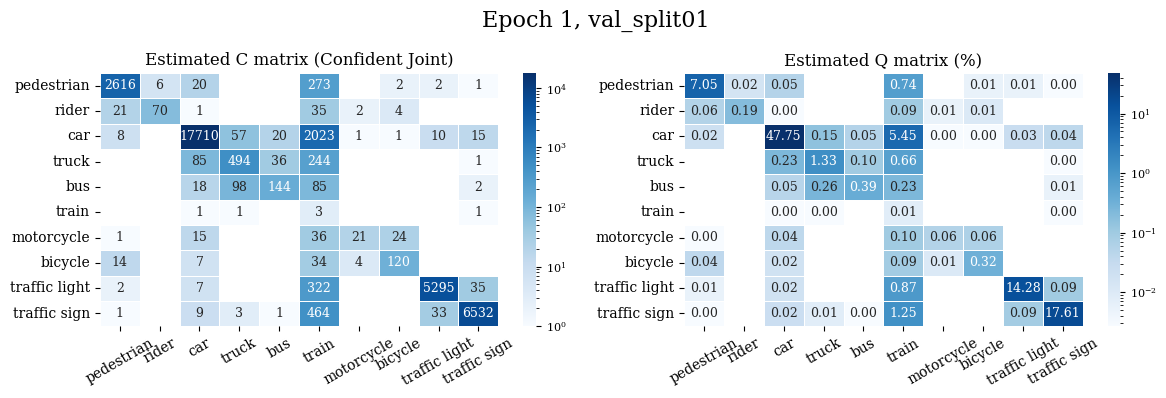

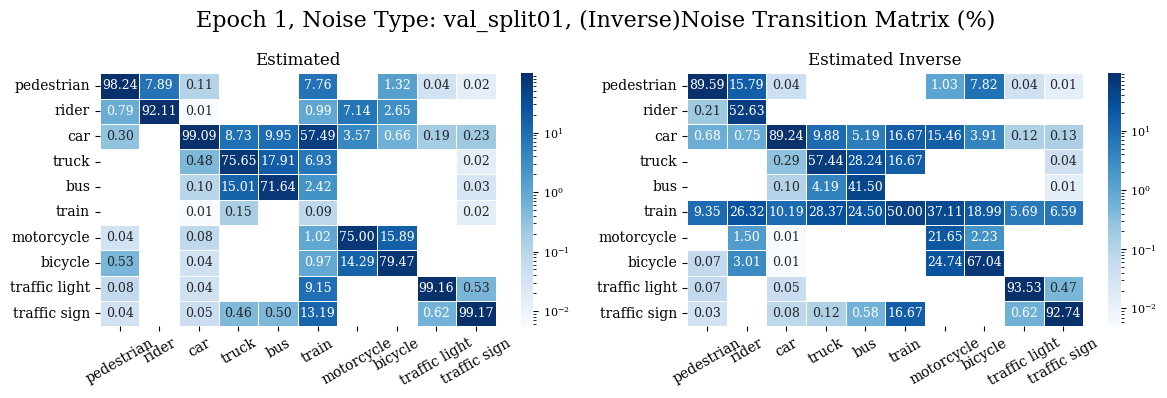

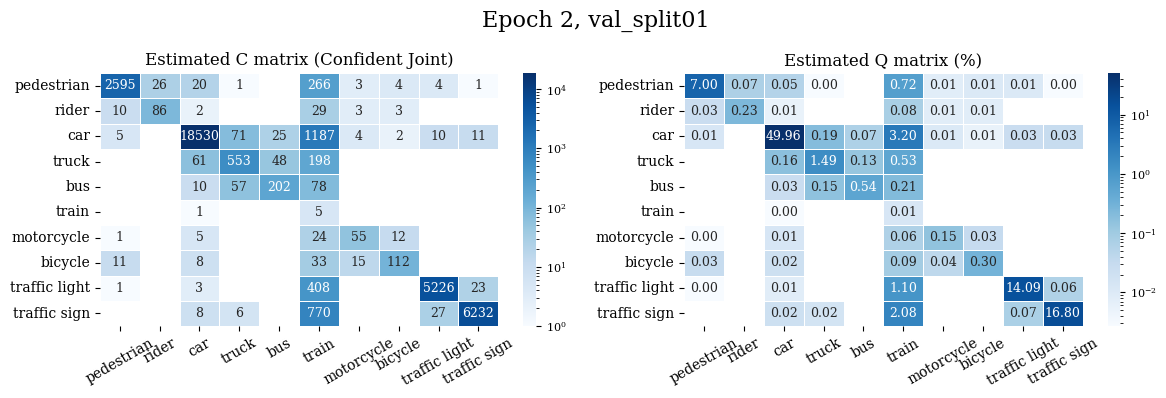

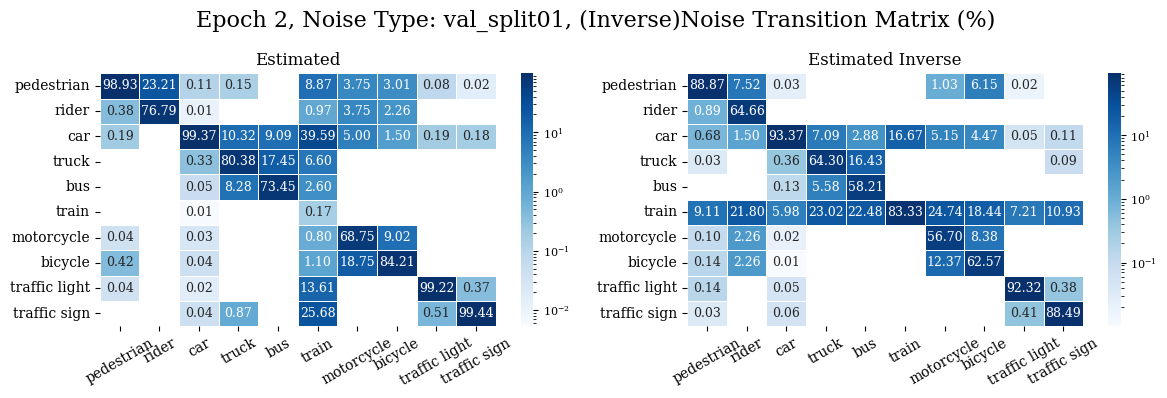

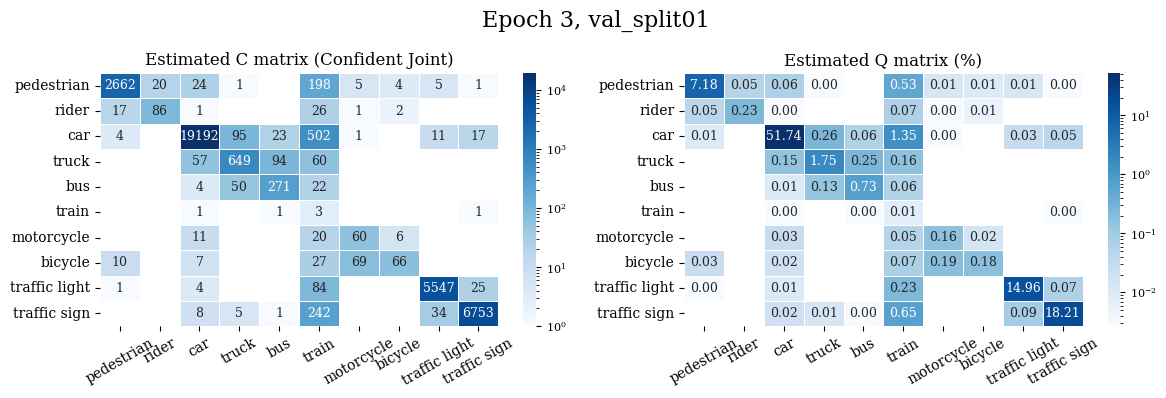

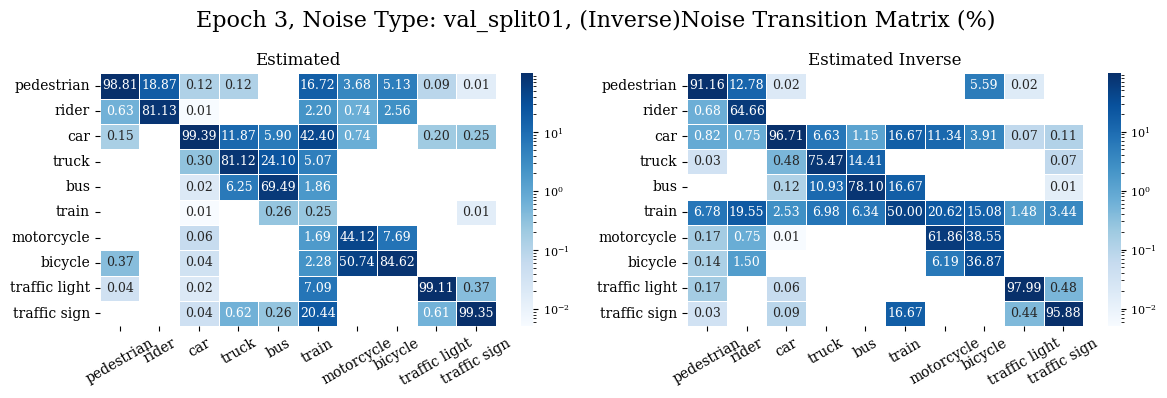

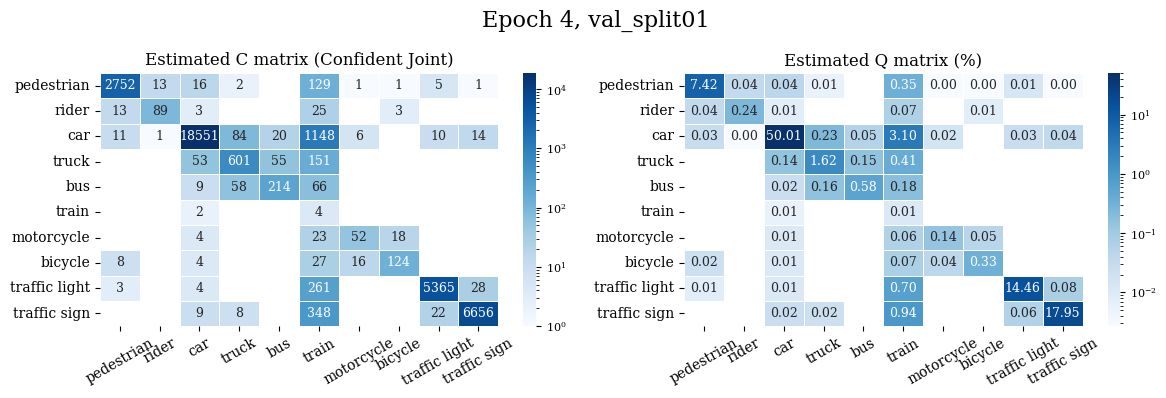

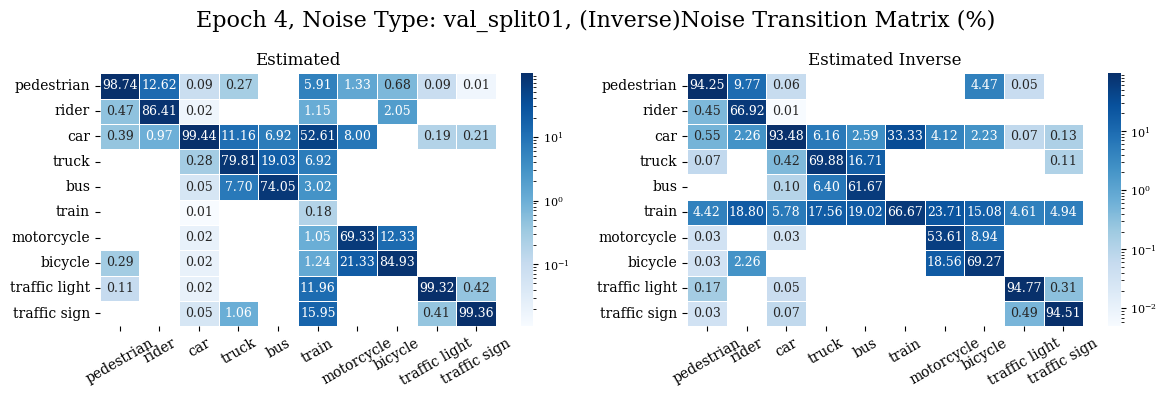

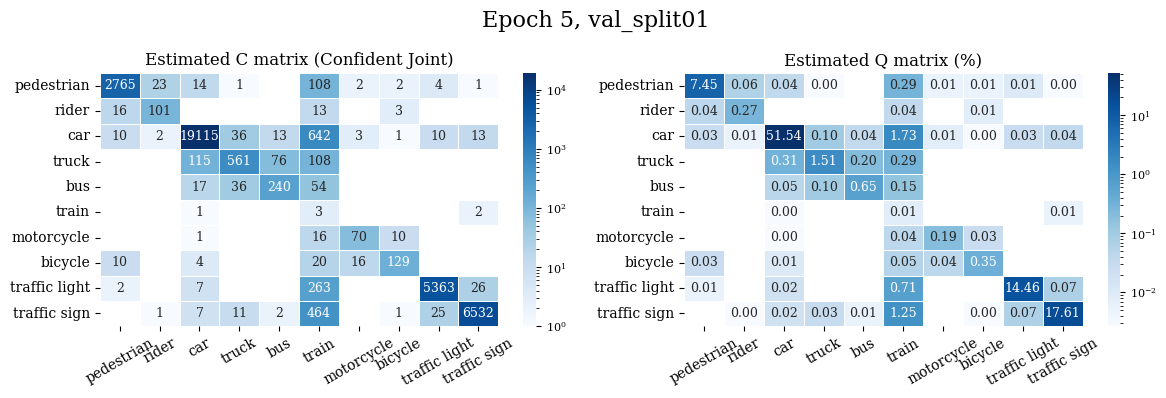

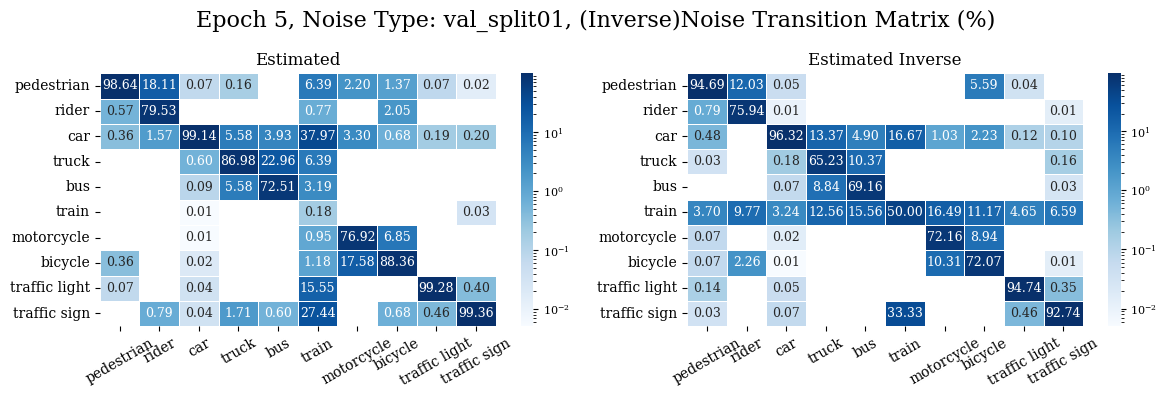

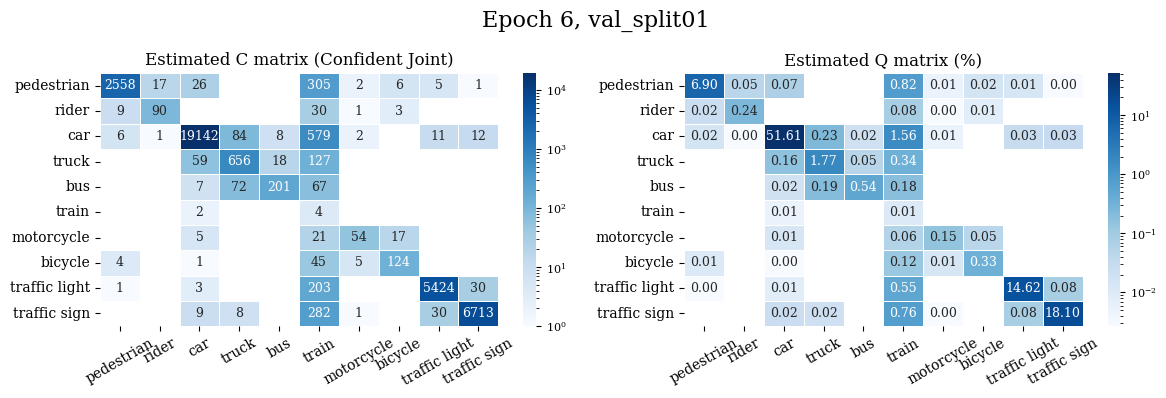

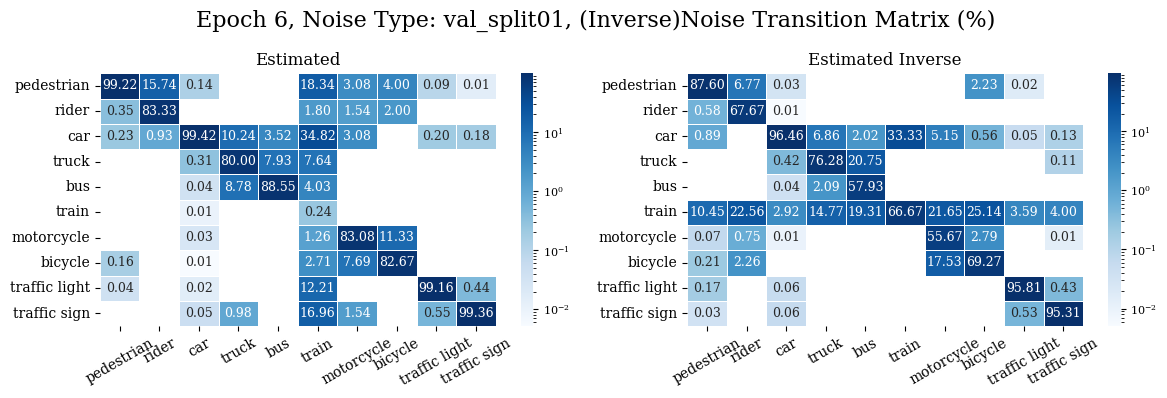

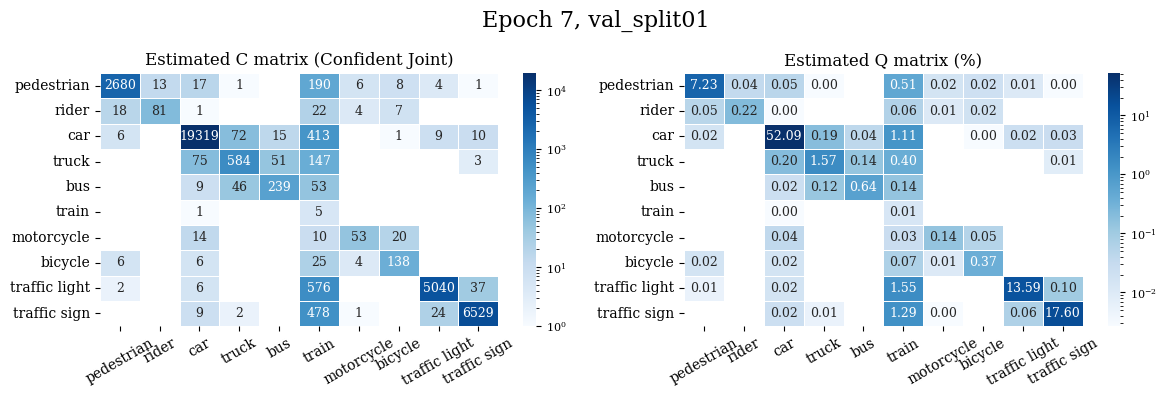

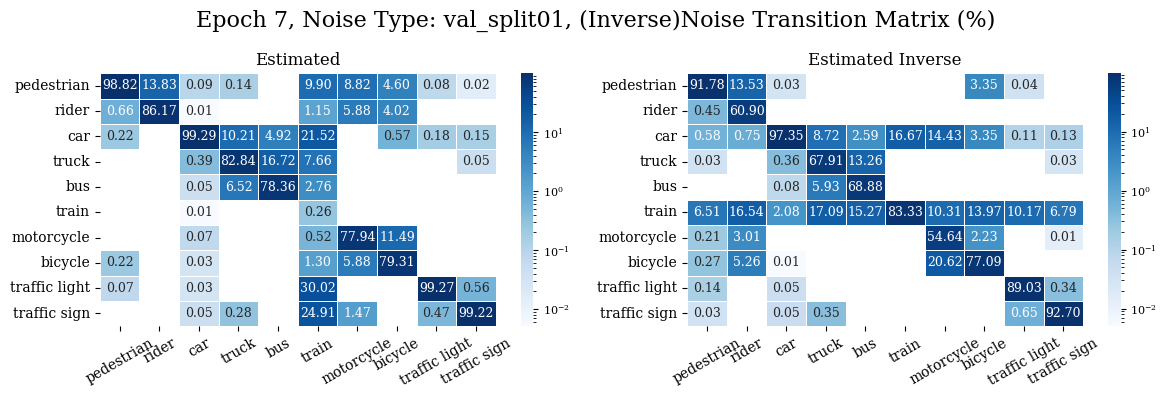

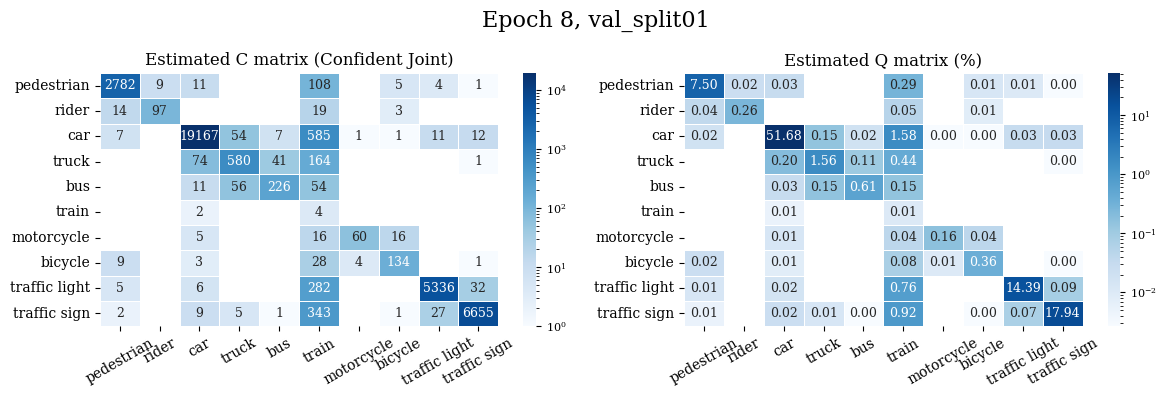

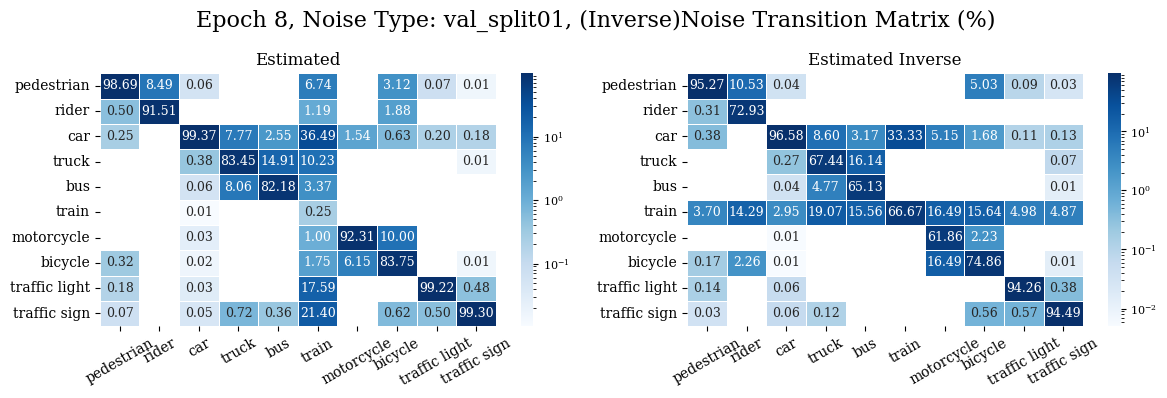

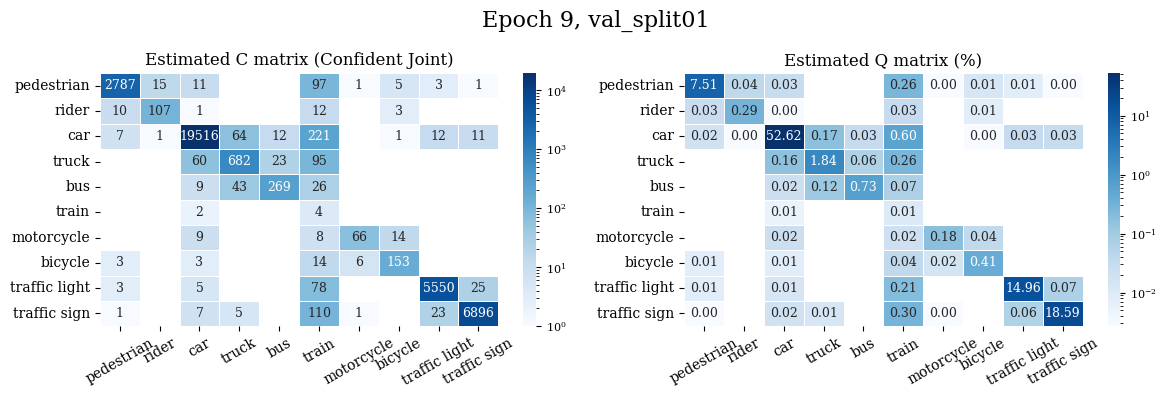

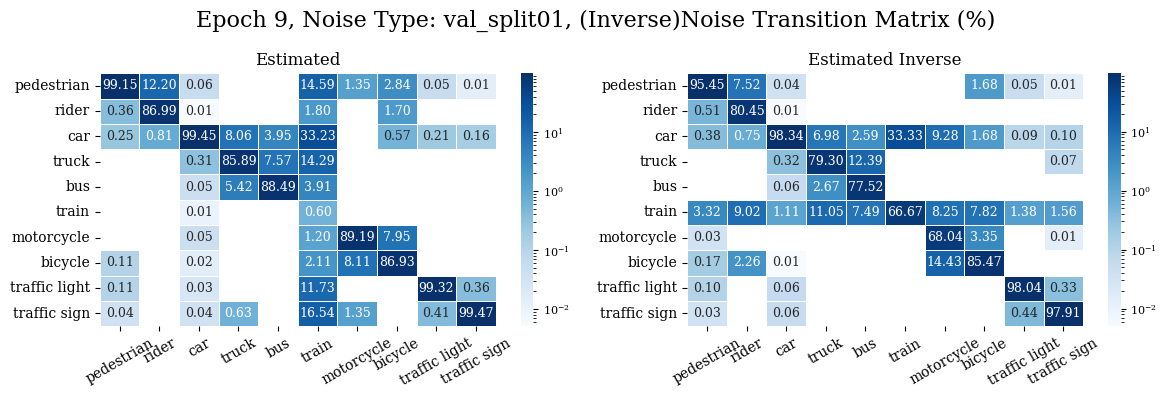

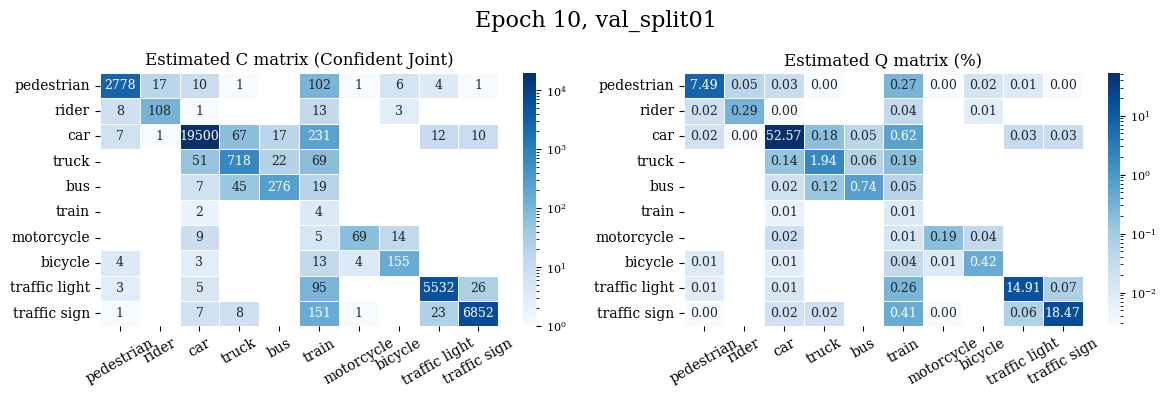

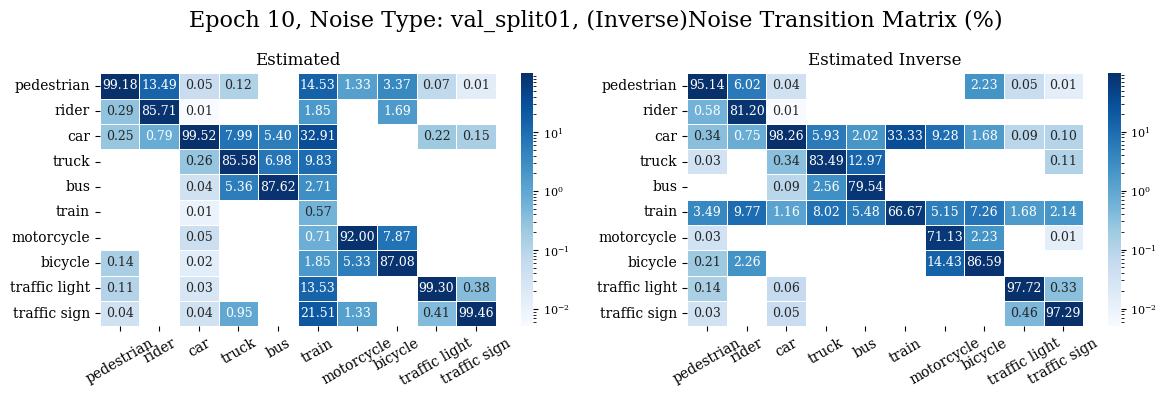

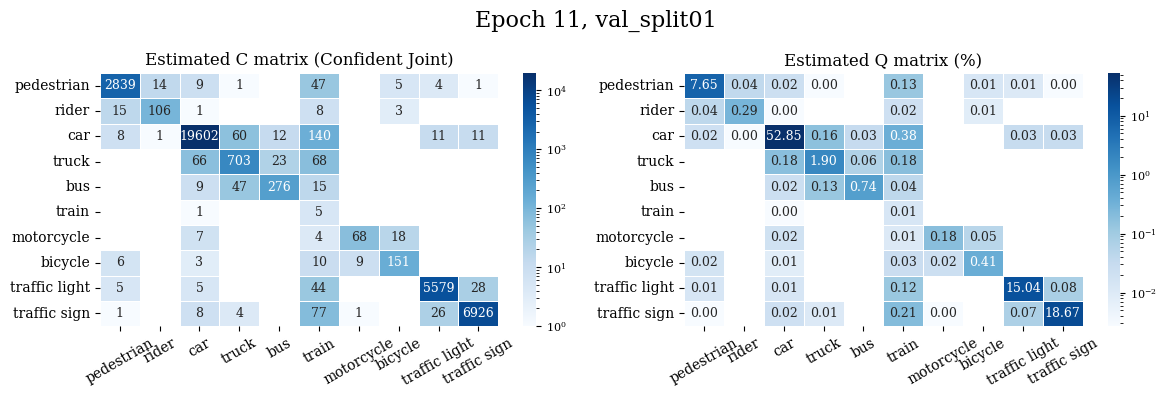

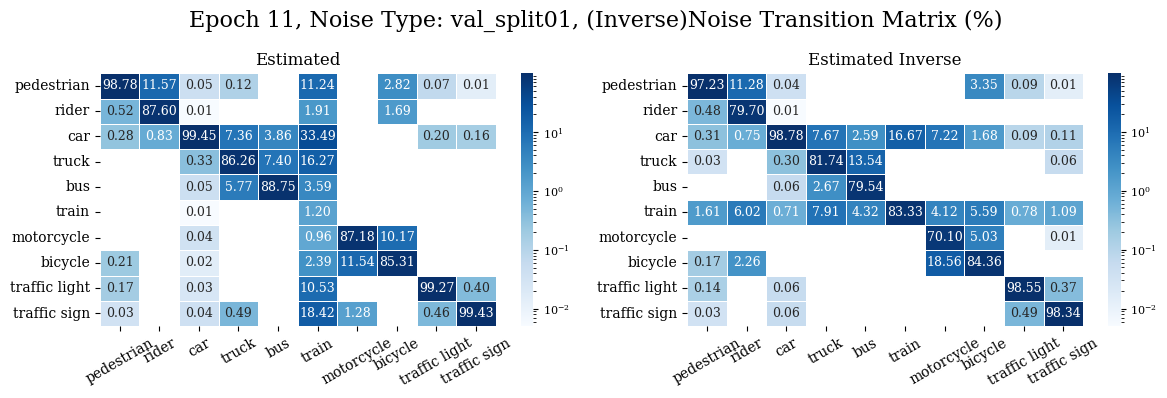

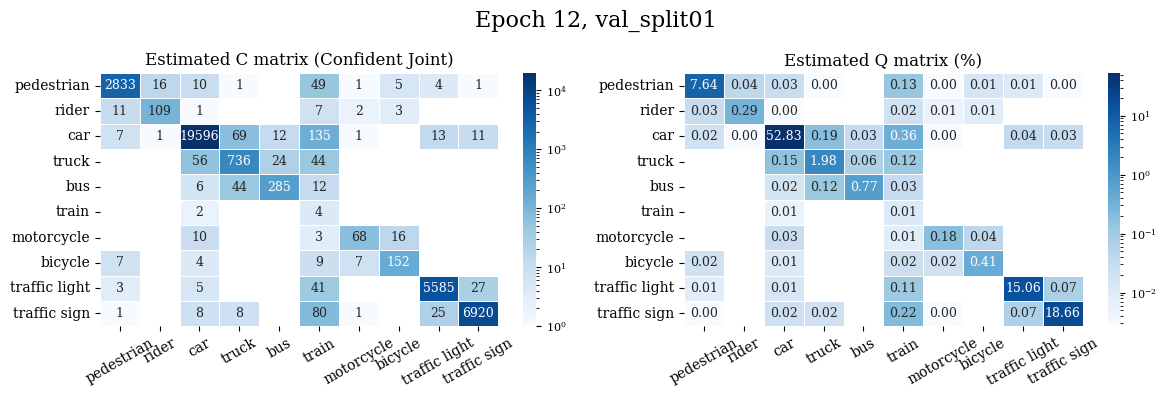

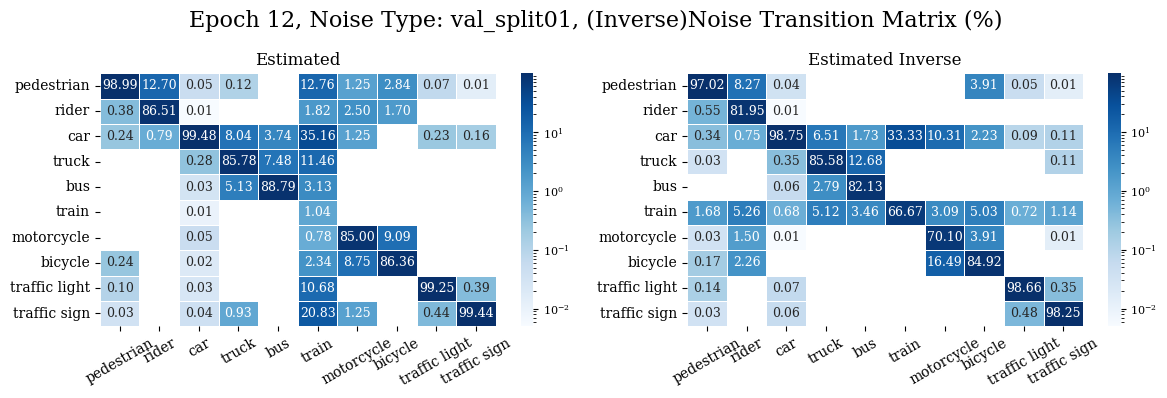

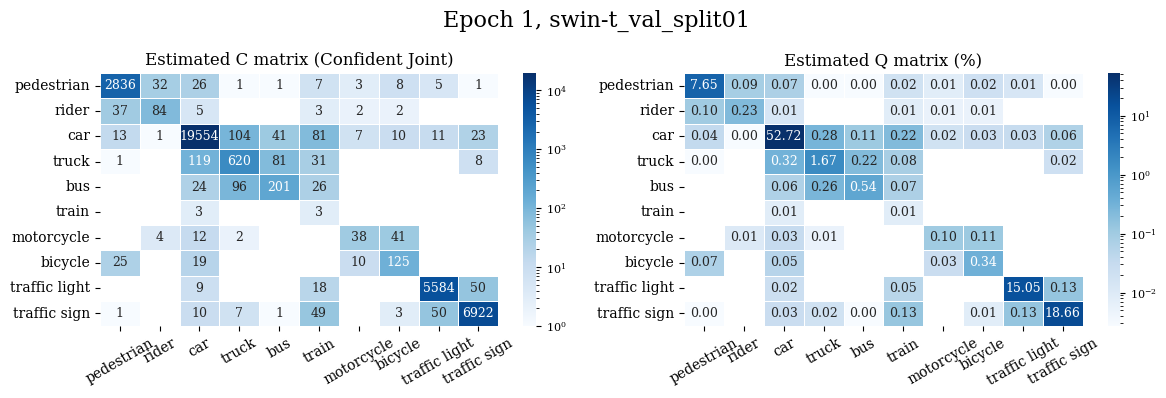

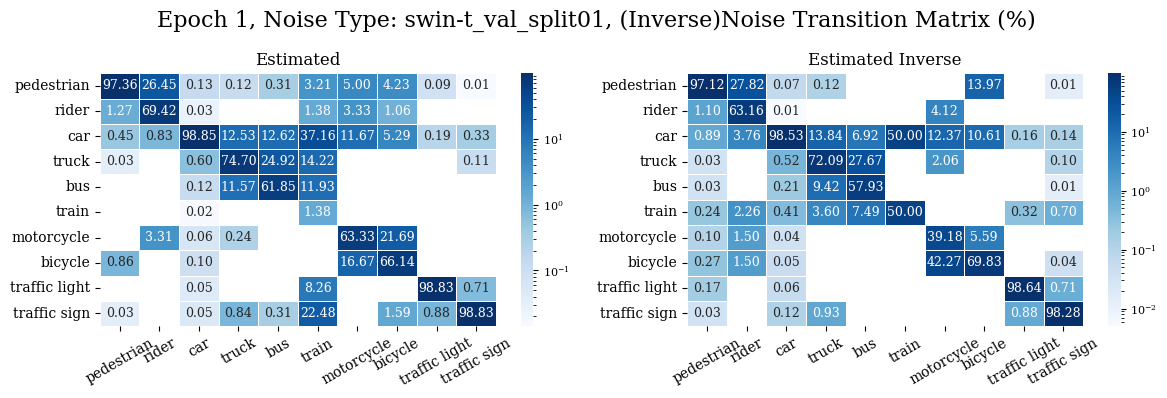

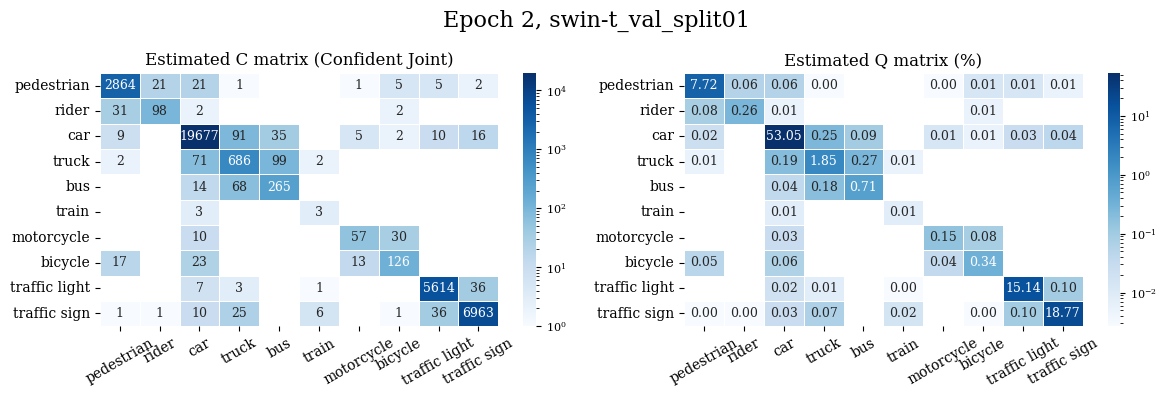

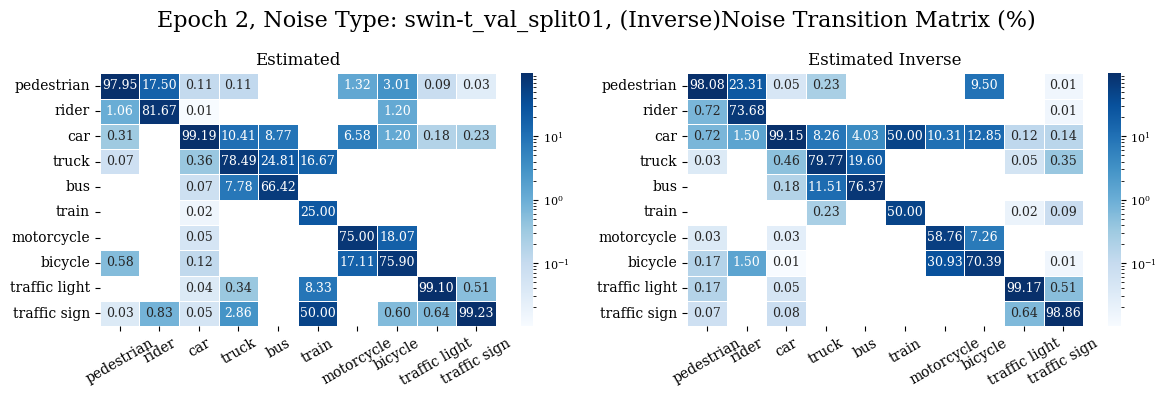

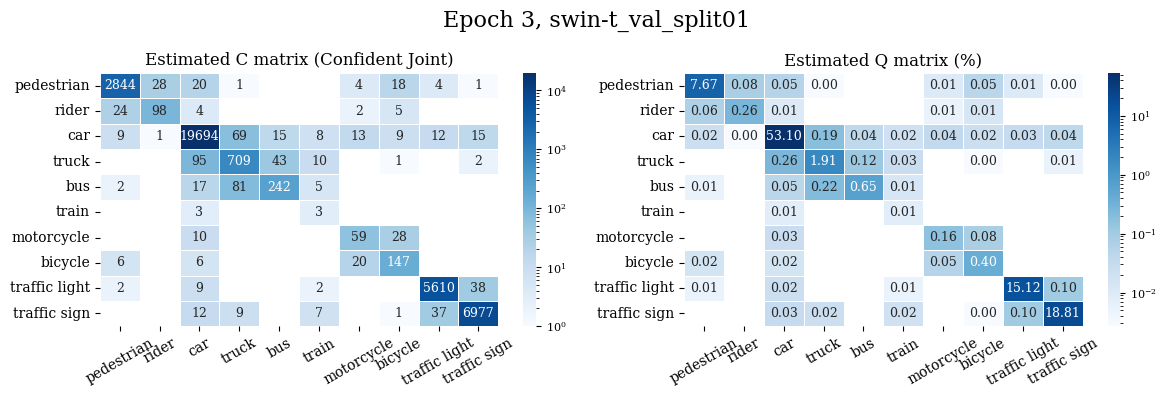

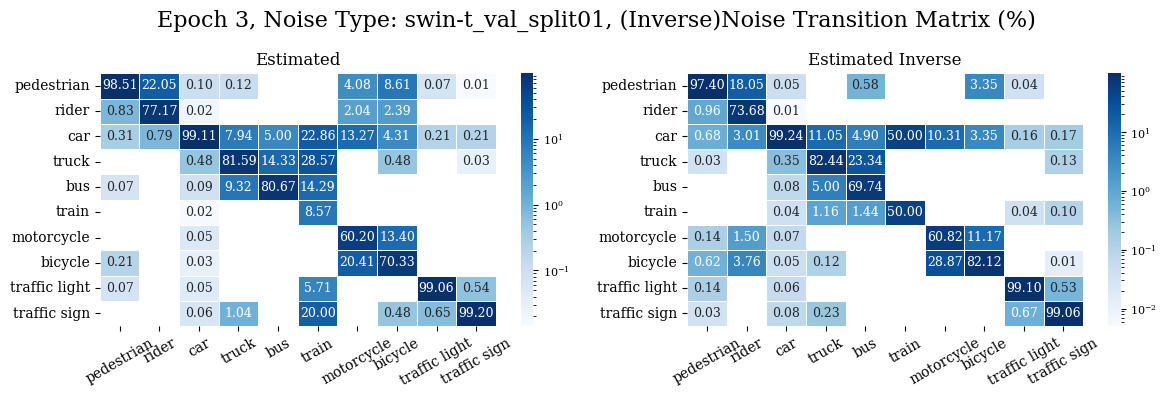

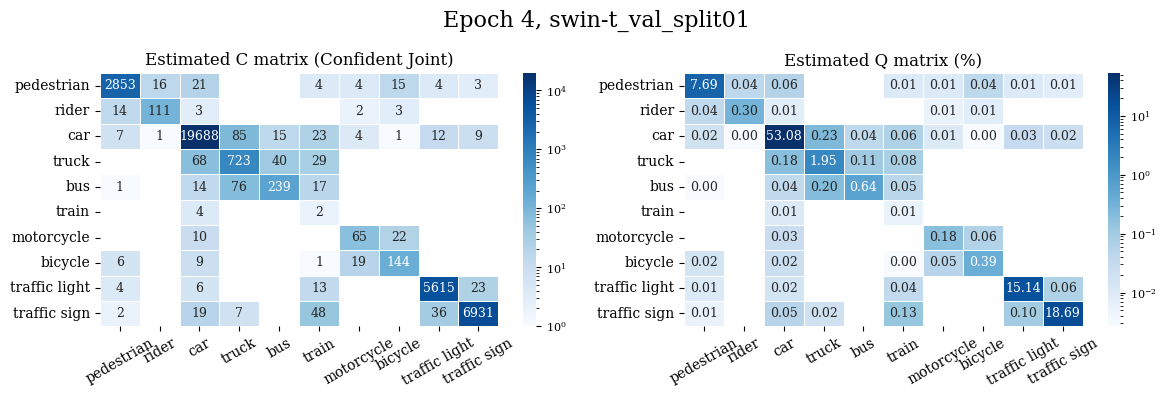

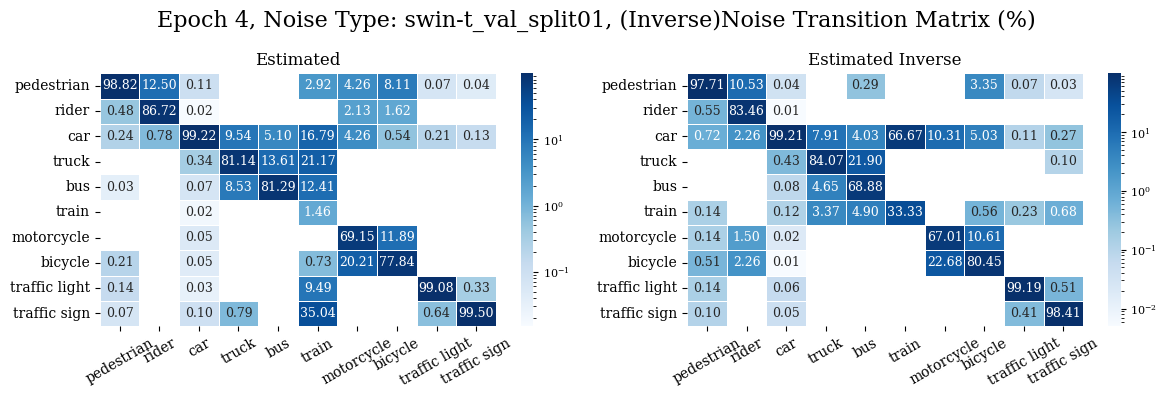

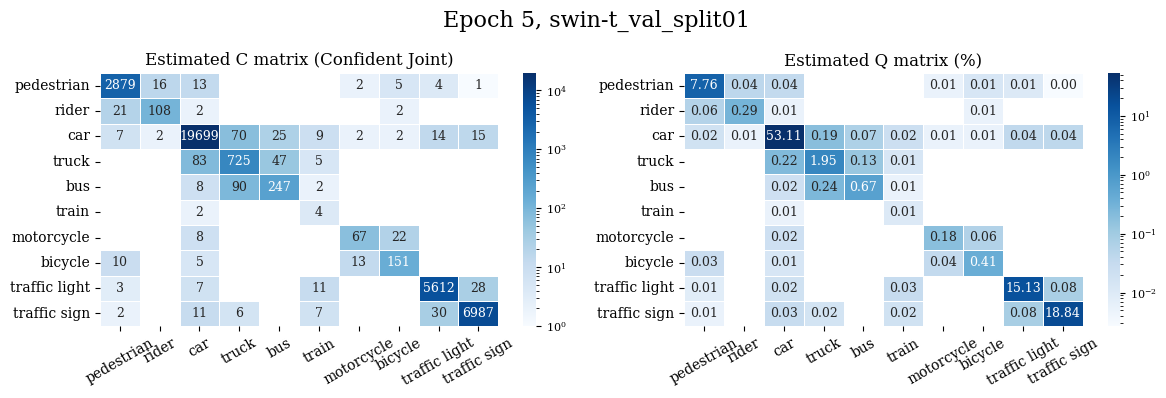

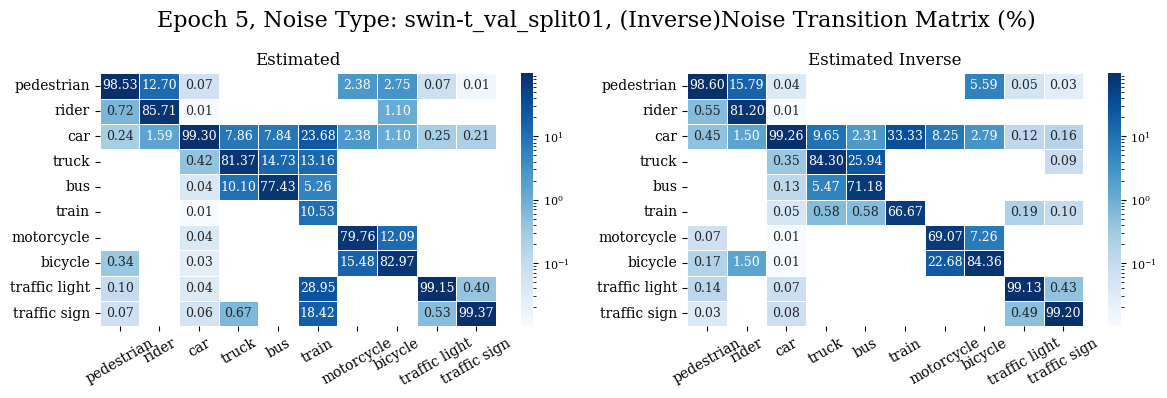

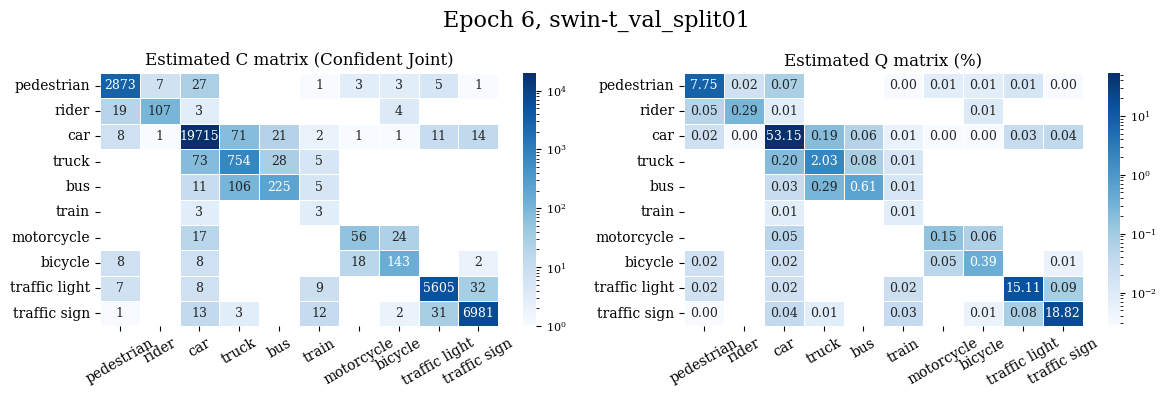

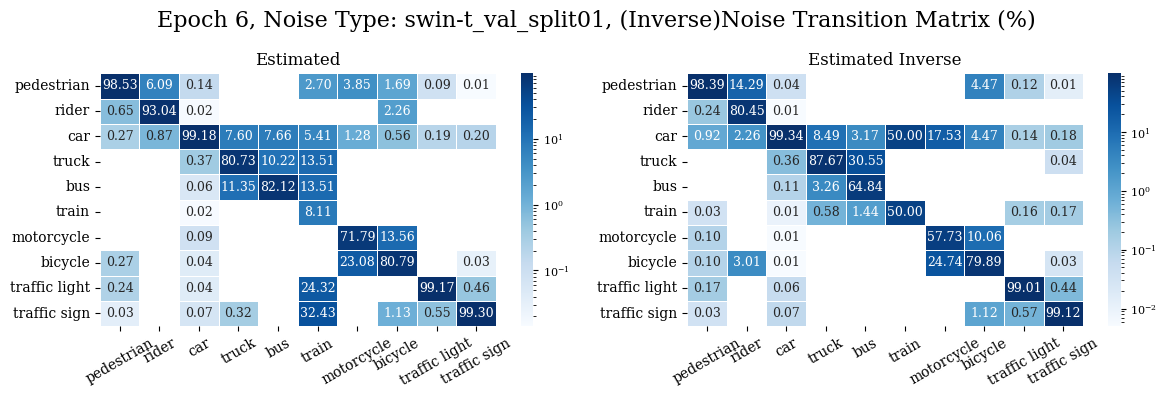

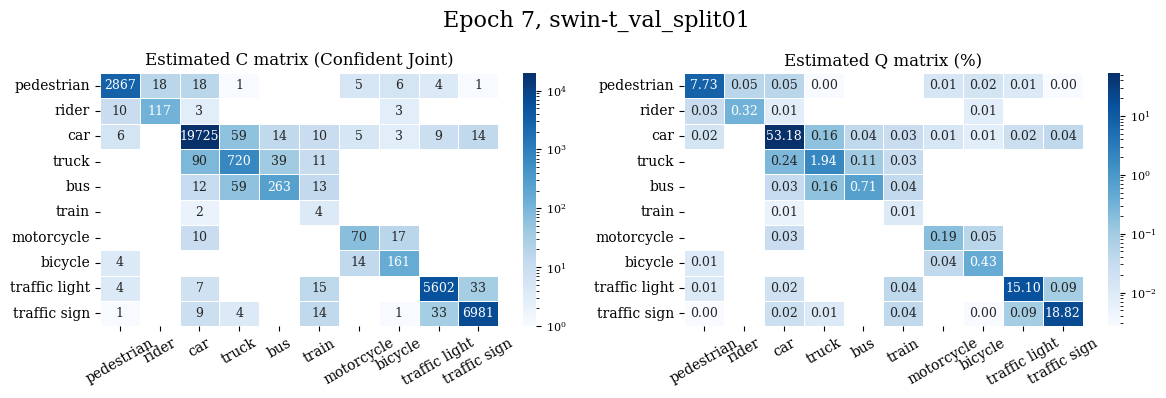

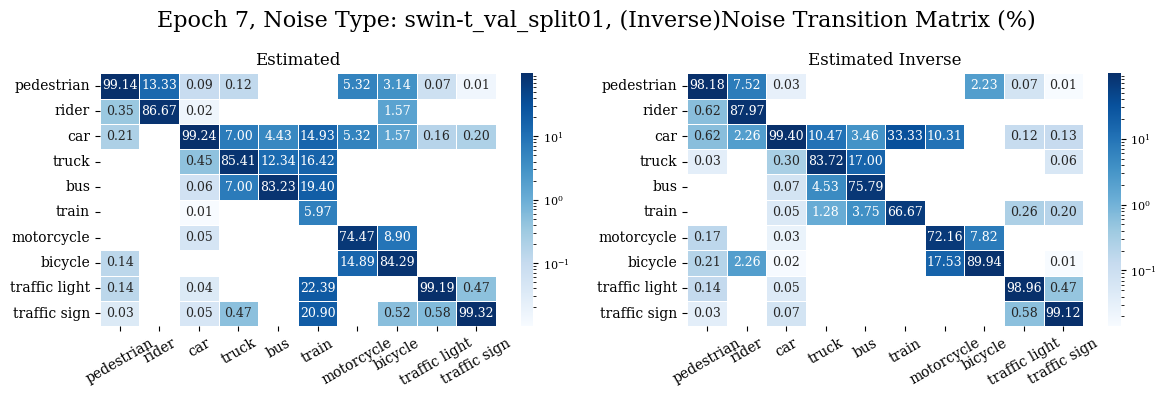

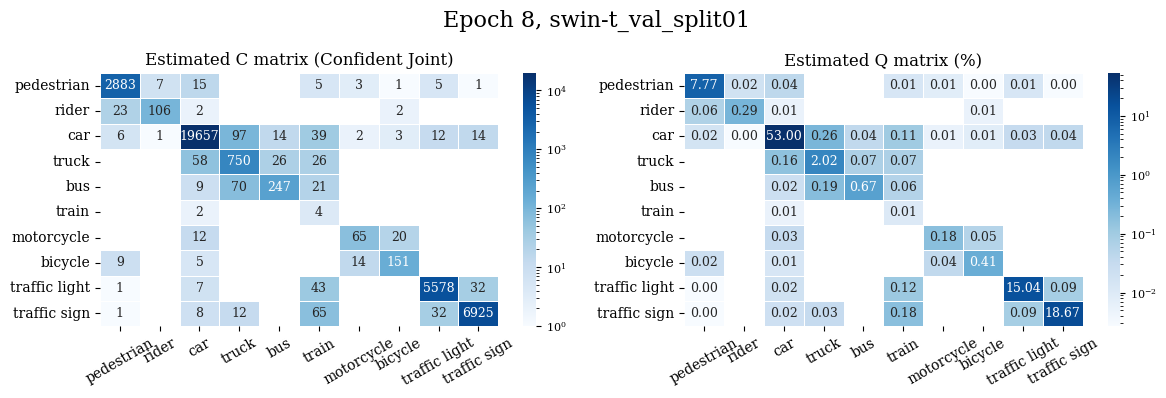

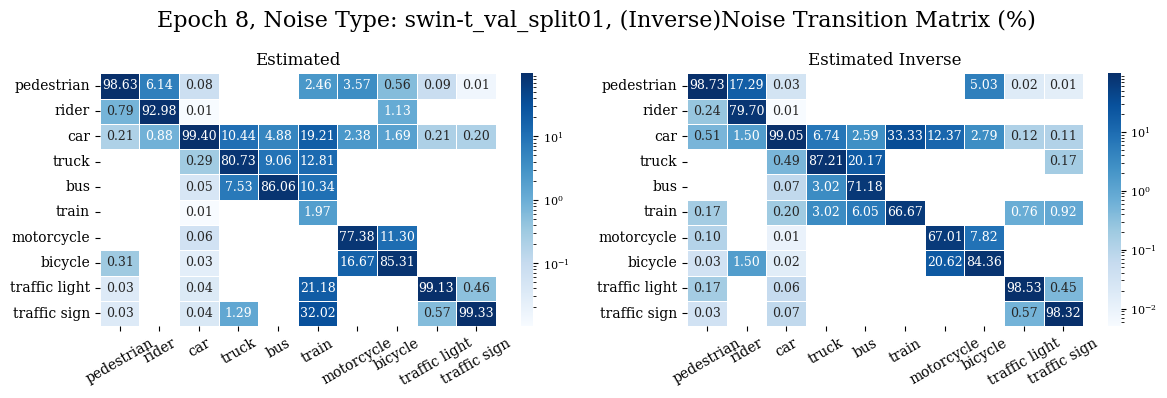

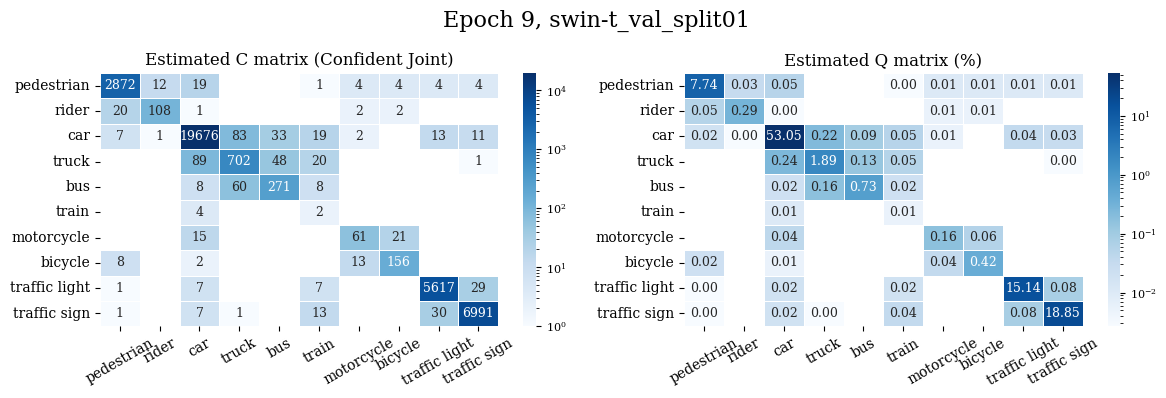

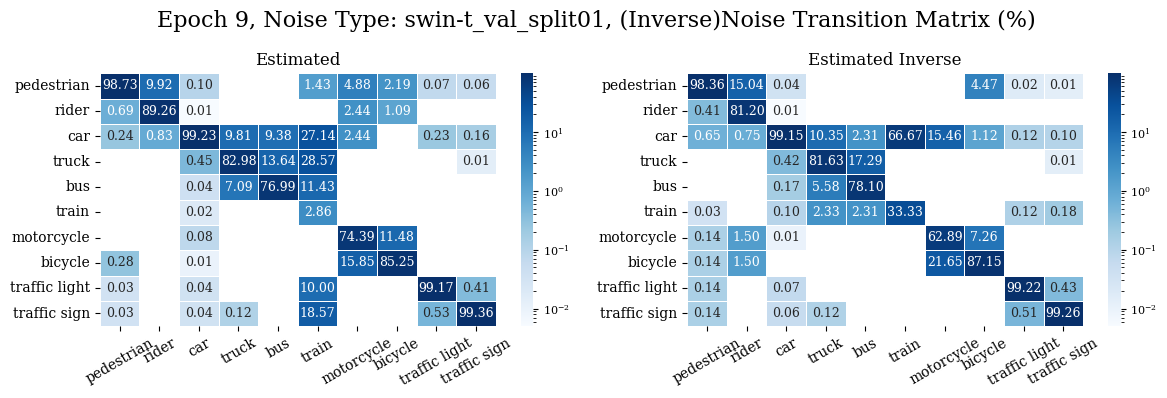

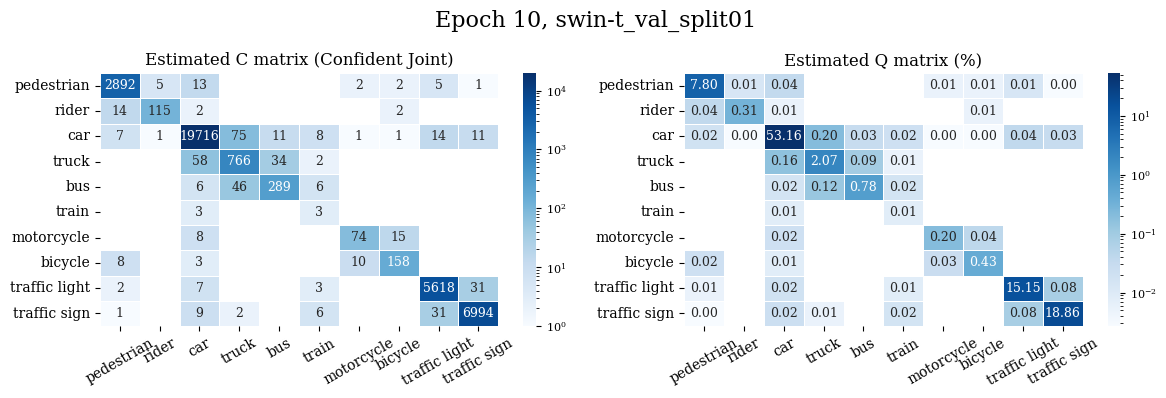

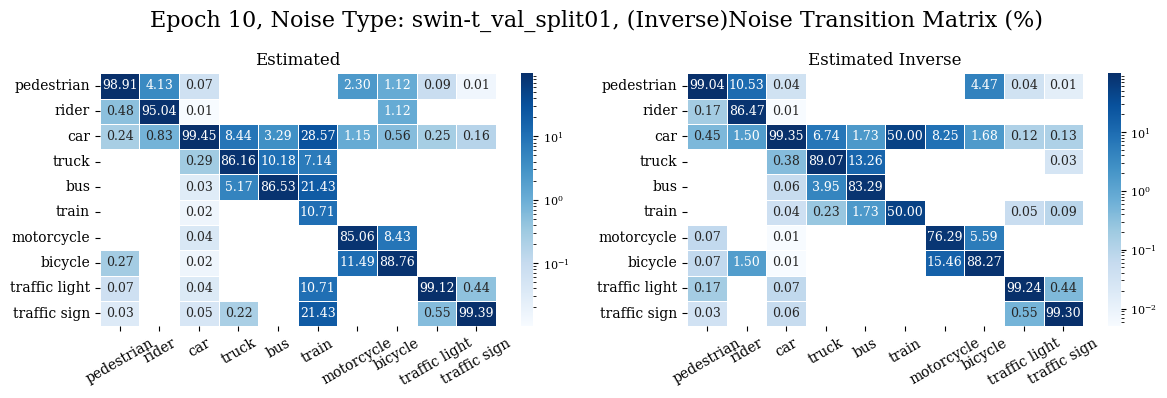

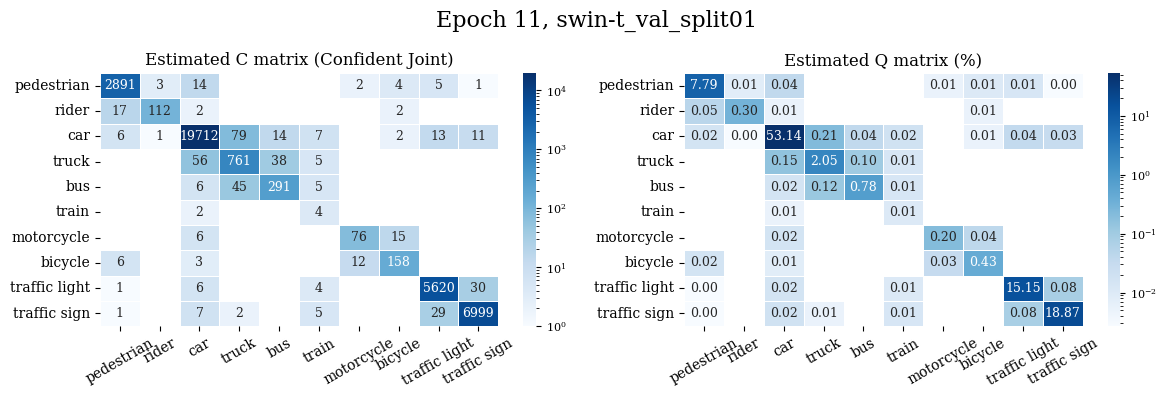

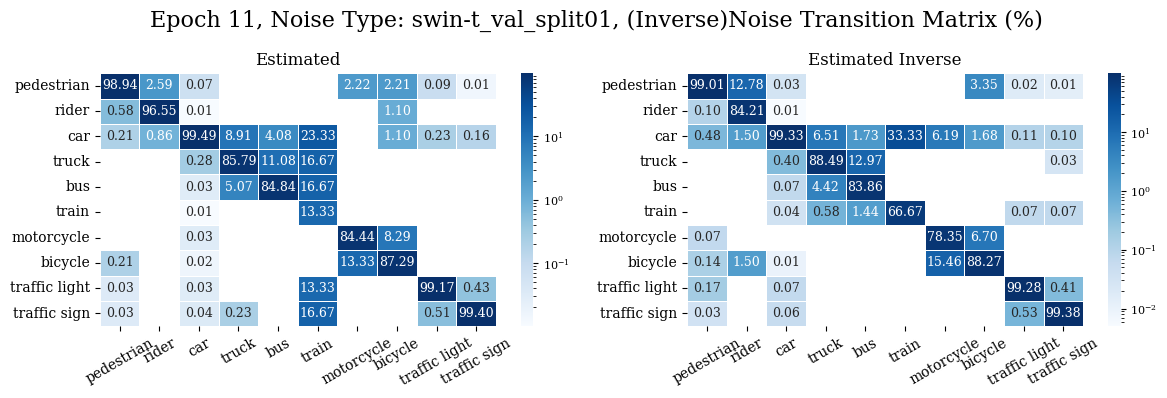

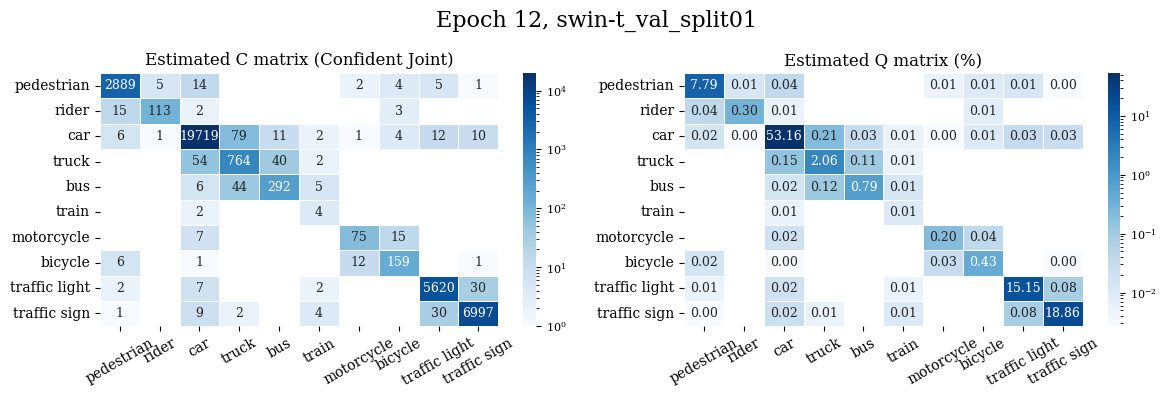

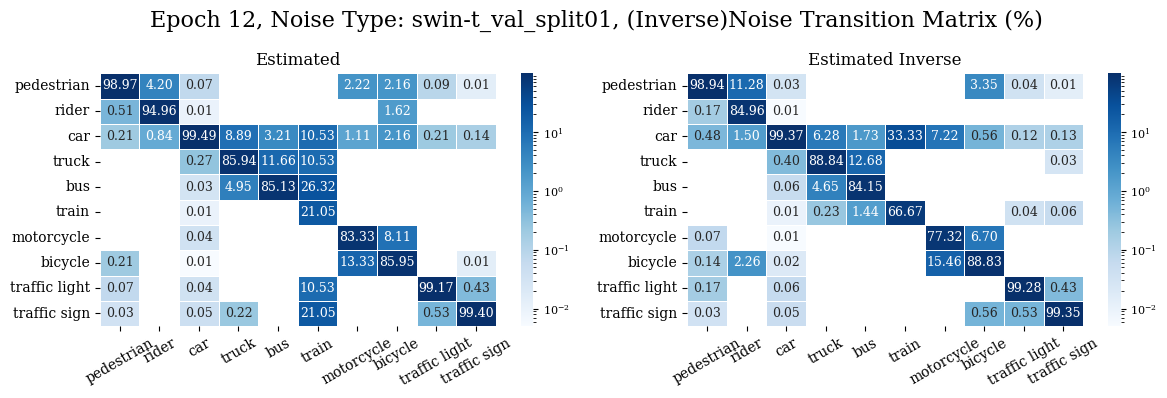

In [5]:
from sklearn.metrics import mean_squared_error
from scipy.special import softmax
from matplotlib.colors import LogNorm, Normalize

from cleanlab.count import get_confident_thresholds, estimate_joint, compute_confident_joint, estimate_latent, estimate_noise_matrices, calibrate_confident_joint, estimate_py_and_noise_matrices_from_probabilities

import math

def cls_to_probs(cls_scores):

    # print(f'[cls_to_probs] cls_score.shape={cls_score.shape}')

    probs = softmax(cls_scores, axis=1)
    # print('cls_score.shape=', cls_score.shape)
    # print(f'scores.shape={probs.shape}')
    # assert cls_scores.size(0) == gt_bboxes.size(0)

    # sanity check
    # close_to_1 = probs.sum(axis=1)
    # print(f'close_to_1={close_to_1}')

    return probs

def gen_heat(mat, q_mat, toptitle, title1, title2, fig_filepath, islog, fmt1, fmt2):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(12, 4))
    fig.suptitle(toptitle, fontsize=16)

    # sns.set_color_codes("pastel")
    # sns.set(font_scale=1.4)
    if islog:
        g1 = sns.heatmap(mat, ax=ax1, annot=True, linewidth=.5, fmt=fmt1, cmap="Blues", xticklabels=id2class.values(), yticklabels=id2class.values(), norm=LogNorm(), annot_kws={"size": 9})
    else:
        g1 = sns.heatmap(mat, ax=ax1, annot=True, linewidth=.5, fmt=fmt1, cmap="Blues", xticklabels=id2class.values(), yticklabels=id2class.values(), norm=Normalize(), annot_kws={"size": 9})

    g1.set_title(title1, fontdict={'size': 12})
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30, fontsize=10)
    g1.set_yticklabels(g1.get_yticklabels(), fontsize=10)
    g1.collections[0].colorbar.ax.tick_params(labelsize=8)

    # q_mat = mat / np.sum(mat)
    # q_mat = estimate_joint

    if q_mat is not None:
        g2 = sns.heatmap(q_mat, ax=ax2, annot=True, linewidth=.5, fmt=fmt2, cmap="Blues", xticklabels=id2class.values(), yticklabels=id2class.values(), norm=LogNorm(), annot_kws={"size": 9})
        # , mask=np.eye(6)
        # , norm=LogNorm()
        g2.set_title(title2, fontdict={'size': 12})
        g2.set_xticklabels(g2.get_xticklabels(), rotation=30, fontsize=10)
        g2.set_yticklabels(g2.get_yticklabels(), fontsize=10)
        g2.collections[0].colorbar.ax.tick_params(labelsize=8)

    
    fig.tight_layout(pad=1.0)
    plt.savefig(f'{fig_filepath}', bbox_inches='tight', dpi=300)
    # plt.show()


    return q_mat


def gen_plain_c_mat(labels_true, labels_gt, id2class):

    c_mat = np.zeros((len(id2class), len(id2class)))

    for true_label, label_gt in zip(labels_true, labels_gt):
        c_mat[true_label][label_gt] += 1

    return c_mat



def gen_one_hot(labels):
    n_values = np.max(labels) + 1
    return np.eye(n_values)[labels]




######################################################
# Fixed epoch 
###################################################### 

# target_epo = 8

colnames = ['Noise Type', 'Epoch', 'RMSE']
df_rmse = pd.DataFrame(columns=colnames)

m_names = ['val_split01', 'swin-t_val_split01']
mat_dic = {m: {} for m in m_names}
epos = list(range(1, 13))



for m_name in m_names:

    ide_q_li = []
    est_q_li = []
    q_rmse_li = []

    ide_t_li = []
    est_t_li = []

    # if m_name != 'ass5':
    #     continue
    
    ######################################################
    # Fixed Noise Type 
    ###################################################### 

    for target_epo in epos:
        fig_dirpath = f'/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig_bdd100k_mat/epo{target_epo}'

        if os.path.exists(fig_dirpath) is False:
            os.makedirs(fig_dirpath)

        print(f'-----------------Model {m_name} -----------------')
        print(f'-----------------Epoch {target_epo} -----------------')
        # m_name = 'uni20'

        df = m_dic[m_name][target_epo]
        # m_name = target_epo

        labels_gt = df['label_gt'].to_numpy()
        probs_gt = gen_one_hot(labels_gt)

        # No bg prob
        probs = np.stack(df['prob'].to_numpy(), axis=0)
        # probs = np.stack(df['prob'].to_numpy(), axis=0)[:, :-1]
        # cls_scores = np.stack(df['cls_score'].to_numpy(), axis=0)[:, :-1]

        c_mat = compute_confident_joint(labels_gt, probs)

        q_mat = estimate_joint(labels_gt, probs, confident_joint=c_mat)
        title1 = 'Estimated C matrix (Confident Joint)'
        title2 = 'Estimated Q matrix (%)'

        toptitle = f'Epoch {target_epo}, {m_name}'

        _ = gen_heat(c_mat, 100*q_mat, toptitle, title1, title2, f'{fig_dirpath}/{m_name}_estimated_C_and_Q.png',  islog=True, fmt1='g', fmt2='.2f')
        est_q_li.append(q_mat)


        prior, noise_mat, inverse_noise_mat, c_mat = estimate_py_and_noise_matrices_from_probabilities(labels_gt, probs)
        toptitle = f'Epoch {target_epo}, Noise Type: {m_name}, (Inverse)Noise Transition Matrix (%)'
        # title1 = 'Ideal'
        title1= 'Estimated'
        title2 = 'Estimated Inverse'
        _ = gen_heat(100*noise_mat, 100*inverse_noise_mat, toptitle, title1, title2, f'{fig_dirpath}/{m_name}_noise_transition.png',  islog=True, fmt1='.2f', fmt2='.2f')
        # ide_t_li.append(noise_mat_gt2)
        # est_t_li.append(noise_mat)


        # toptitle = f'Epoch {target_epo}, Noise Type: {m_name}, Inverse Noise Transition Matrix (%)'
        # title1 = 'Ideal'
        # title2 = 'Estimated'
        # _ = gen_heat(100*inverse_noise_mat_gt2, 100*inverse_noise_mat, toptitle, title1, title2, f'{fig_dirpath}/{m_name}_inv_noise_transition.png')

    #     # print(f'------------------------------------')

    #     row = [m_name, target_epo, RMSE]

    #     df_rmse = pd.concat([df_rmse, pd.DataFrame([row], columns=colnames)], ignore_index=True)
    
    # mat_dic[m_name]['ide_q'] = np.stack(ide_q_li, axis=0)
    # mat_dic[m_name]['est_q'] = np.stack(est_q_li, axis=0)
    # mat_dic[m_name]['ide_t'] = np.stack(ide_t_li, axis=0)
    # mat_dic[m_name]['est_t'] = np.stack(est_t_li, axis=0)
    # mat_dic[m_name]['q_rmse'] = np.array(q_rmse_li)

# Model Performance to Latex

In [14]:
def formating_decimals(df, colnames):

    for col in colnames:
        df[col] = df[col].apply(lambda x: f'{x:.1f}')

    return df

def process_df_to_latex(df):

    df = df.drop(columns=['TNR'], inplace=False)

    df = df[ ['Class'] + [ col for col in df.columns if col != 'Class' ] ]

    df = formating_decimals(df, ['Precision', 'Recall'])

    MyColumns = pd.MultiIndex.from_tuples([
                                        ("Class" , ""),
                                        ("Epoch", ""),
                                        ("Confusion Matrix", "TP"),
                                        ("Confusion Matrix", "FP"),
                                        ("Confusion Matrix", "TN"),
                                        ("Confusion Matrix", "FN"),
                                        ("Precision" , ""),
                                        ("Recall" , ""),
                                        # ("TNR" , ""),
                                        ])

    # Create new DataFrame with specified Columns, after this you should pass values 
    df_multi = pd.DataFrame(df , columns = MyColumns)

    # a loop for passing values
    for item in range(len(MyColumns)):
        df_multi.loc[: , MyColumns[item]] = df.iloc[: , item]

    sorter = list(id2class.values())


    df_multi = df_multi.groupby(by=['Class']).apply(lambda x: x.sort_values(("Epoch", "")))

    # print(f'df_multi={df_multi}')
    print(f'df_multi.index={df_multi.index}')
    # df_multi = df_multi.droplevel(level=1)
    df_multi.reset_index(level=1, inplace=True)

    multi_columns = [("Precision" , ""), ("Recall" , "")]

    for i in set(df_multi.index):

        for column in multi_columns:
            # print(f'i={i}')
            # print(f'column={column}')
            # print('***')
            # print(df_multi.loc[i, column])
            number_list = df_multi.loc[i, column].to_numpy(dtype=float)
            max_value = number_list.max()
            max_rowid = number_list.argmax()
            max_cell = "tttextbf{" + f'{max_value:.1f}' +'}'

            number_list = [f'{i:.1f}' for i in number_list]
            number_list[max_rowid] = max_cell

            df_multi.loc[i, column] = number_list

    
    # t2= df_multi.reset_index(level=0, drop=True)
    df_multi.drop(columns=[('level_1', '')], inplace=True)

    return df_multi



# class2shortname = {k: k for k in id2class.values()}
# class2shortname['NO_STOPPING_NO_STANDING'] = 'NSNS'
# class2shortname['NO_PARKING'] = 'N_PARK'
# class2shortname['PASS_EITHER_SIDE'] = 'PESIDE'
# class2shortname['PASS_RIGHT_SIDE'] = 'PRSIDE'
# class2shortname['PEDESTRIAN_CROSSING'] = 'PCROSS'
# class2shortname['PRIORITY_ROAD'] = 'PROAD'

m_names_mapper = {
    'val_split01': 'Faster R-CNN',
    'swin-t_val_split01': 'Swim-Transformer'
}

latex_dic = {m: None for m in m_names_mapper.keys()}


for idx, m_name in enumerate(m_names):
    df = perform_byclass_dic[m_name].copy()
    df2 = process_df_to_latex(df)

    if idx > 0:
        df2.drop(columns=['Class', 'Epoch'], inplace=True)
    
    latex_dic[m_names_mapper[m_name]] = df2
    # df2.drop(columns=['Class', 'epoch'], inplace=True)


final_df = pd.concat(latex_dic, axis=1)


def postprocess_latex(lines, max_epo, col_idx):
    lines = lines.replace('tttextbf', '\\textbf').replace('\{','{').replace('\}','}')

    new_lines = []
    prev_line = None

    for line in lines.splitlines():
        new_lines.append(line)
        start_check =False

        if prev_line == '\endlastfoot':
            start_check = True

        if start_check is False :
            # new_lines.append(line)
            prev_line = line
            continue

        if '\end{longtable}' in line:
            continue

        if line.split('&')[col_idx] == max_epo:
            new_lines.append('\hline')

    return '\n'.join(new_lines)

latex_lines = final_df.to_latex(index=False, escape=True, longtable=True)

latex_lines = postprocess_latex(latex_lines, max_epo=' 12 ', col_idx=1)

# print(latex_lines)
with open(f'/home/belay/Documents/0_UPPSALA/KOGNIC_research/UUThesis2023/latex_table.txt', 'w') as f:
    f.write(latex_lines)

df_multi.index=MultiIndex([('bicycle',   7),
            ('bicycle',  17),
            ('bicycle',  27),
            ('bicycle',  37),
            ('bicycle',  47),
            ('bicycle',  57),
            ('bicycle',  67),
            ('bicycle',  77),
            ('bicycle',  87),
            ('bicycle',  97),
            ...
            (  'truck',  23),
            (  'truck',  33),
            (  'truck',  43),
            (  'truck',  53),
            (  'truck',  63),
            (  'truck',  73),
            (  'truck',  83),
            (  'truck',  93),
            (  'truck', 103),
            (  'truck', 113)],
           names=['Class', None], length=120)
df_multi.index=MultiIndex([('bicycle',   7),
            ('bicycle',  17),
            ('bicycle',  27),
            ('bicycle',  37),
            ('bicycle',  47),
            ('bicycle',  57),
            ('bicycle',  67),
            ('bicycle',  77),
            ('bicycle',  87),
            ('bicycle',  97),
       

/tmp/ipykernel_462907/1889746354.py:93: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2.drop(columns=['Class', 'Epoch'], inplace=True)


# AED Performance

In [13]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, roc_auc_score, precision_score
from scipy.special import softmax
from collections import Counter

epos = list(range(1, 13))
m_names = ['val_split01', 'swin-t_val_split01']

default_csv_filepath = './postprocessing/code/DataFrame/BDD100K/FasterRCNN/default_val_s01.csv'
default_df = pd.read_csv(default_csv_filepath, header=0, delimiter=',', index_col=0)

###############################################################
#                 Number of Detected data                     #
###############################################################
# default_df = pd.read_csv(f'{csv_dirpath}/{default_csv_filename}', index_col=0, header=0)

# is_issue_types = ['c_incorrect', 'c_correct', 'ambiguous']

# All methods
# methods = ['PBNR_NMargin','PBNR_SConf','PBNR_CWE','CL_NMargin','CL_SConf','CL_CWE','ArgMax_NMargin','ArgMax_SConf','ArgMax_CWE', 'LRank']

# Selected methods
methods = ['CL_NMargin','CL_SConf', 'CL_CWE', 'LRank']
# methods = ['LRank']

# colnames = ['epoch', 'method', 'classname',
#             'TP_all', 'FP_all', 'precision_all', 'recall_all',
#             'TP_10', 'FP_10', 'precision_10',
#             'TP_20', 'FP_20', 'precision_20',
#             'TP_30', 'FP_30', 'precision_30',
#             'TP_40', 'FP_40', 'precision_40',
#             'TP_50', 'FP_50', 'precision_50']

# TNR is specificity
colnames = ['Epoch', 'Method', 'Class',
            'P@10', 'P@10amb',
            'P@25', 'P@25amb',
            ]


def cal_precision(df, detected_idxs, include_ambi, is_recall=False):

    retrieved_elems = df.loc[detected_idxs, :]


    if include_ambi is True:
        TP_condition = (retrieved_elems['c_incorrect'] == True) | (retrieved_elems['ambiguous'] == True) 
    else:
        TP_condition = (retrieved_elems['c_incorrect'] == True)

    TP_df = retrieved_elems.loc[TP_condition]
    FP_df = retrieved_elems.loc[(retrieved_elems['c_incorrect'] == False)]

    if (len(TP_df)+len(FP_df)) == 0:
        return 0, 0, 0, 0, 0

    precision = 100.0 * len(TP_df) / (len(TP_df)+len(FP_df))

    # print(f'detected_idxs={len(detected_idxs)}, TP={len(TP_df)}, FP={len(FP_df)}, Precision: {precision:.3f}%')
    # assert (len(TP_df)+len(FP_df)) == len(detected_idxs)

    recall = None
    if is_recall:
        relevant_elems = df.loc[df['c_incorrect']==True, :]

        if len(relevant_elems) > 0:
            recall = 100.0 * len(TP_df) / (len(relevant_elems))
        else:
            recall = 0.0
        # FN_df = relevant_elems.loc[~relevant_elems.index.isin(detected_idxs), :]
        # assert len(TP_df) + len(FP_df) + len(FN_df) == len(df)

    TN_FP_condition = (df['c_incorrect'] == False)
    TN_FP_df = df.loc[TN_FP_condition, :]
    TN_df = TN_FP_df.loc[~TN_FP_df.index.isin(detected_idxs), :]

    TNR = 100.0 *  len(TN_df) / len(TN_FP_df)

    return len(TP_df), len(FP_df), precision, recall, TNR


def cm_by_topn(epo_df, default_df, detected_idxs, is_ambi, by_classes):

    if is_ambi is True:
        conditions = (default_df['c_incorrect'] == 'TRUE') | (default_df['ambiguous'] == 'TRUE') | (default_df['c_incorrect'] == 'TRUE')
    else:
        conditions = (default_df['c_incorrect'] == 'TRUE') & (default_df['ambiguous'] == 'FALSE') & (default_df['bb_incorrect'] == 'FALSE')

    assert len(epo_df) == len(default_df), 'len of epo_df and default_df are not equal'

    total_idxs = default_df.index.to_numpy()
    assert np.array_equal(epo_df.index.to_numpy(), total_idxs), 'index of epo_df and default_df are not equal'

    # relevant items = TP + FN
    # This is y_true, based on the error conditions (E and EA)
    relevant_idxs = default_df.loc[conditions, :].index.tolist()
    y_true = [True if idx in relevant_idxs else False for idx in total_idxs]

    # retrieved items = TP + FP
    # This is y_pred
    retrived_idxs = default_df.loc[detected_idxs, :].index.tolist()
    y_pred = [True if idx in retrived_idxs else False for idx in total_idxs]

    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    precision = 100.0 * precision_score(y_true, y_pred, labels=[True, False])

    
    return cm, precision




todo_list = set()
def gen_cal_df(m_names, default_df, methods, by_classes=False):
    
    cal_dic = {m: None for m in m_names}

    for m_name in m_names:
        print(f'-----------------Model {m_name} -----------------')

        df_cal = pd.DataFrame(columns=colnames)
        
        for epo in epos:
            # print(f'Processing epoch {epo}')

            epo_df = m_dic[m_name][epo]

            for method in methods:

                top_percentage = 1.0
                if by_classes is False:

                    # This is default
                    classname = 'all'

                    ########################################################
                    #               Number of Detected data                #
                    ########################################################
                    if method == 'LRank':

                        topn_thresh = int(round(len(epo_df.loc[epo_df['CL_SConf'] != 999999]) * top_percentage))

                        # print(f'topNthresh={topNthresh} for LRank')
                        lossrank_df = epo_df.sort_values(by='loss', ascending=False)
                        detected_df = lossrank_df[:topn_thresh]
                        # detected_df = epo_df.loc[epo_df[method] <= topNthresh]

                    else:

                        detected_df = epo_df.loc[epo_df[method] != 999999].sort_values(by=method, ascending=True)
                        # topn = int(round(len(detected_df) * top_percentage))
                        # detected_df = detected_df[:topn]


                    ########################################################
                    #               Number of Detected data                #
                    ########################################################
                    detected_idxs = detected_df.index.tolist()


                    
                    #######################################################
                    #                  Precision at K                     #
                    #######################################################

                    topn = 10
                    top10_idxs = detected_df[:topn].index.tolist()
                    _, p10 = cm_by_topn(epo_df, default_df, top10_idxs, is_ambi=False, by_classes=by_classes)
                    _, p10amb = cm_by_topn(epo_df, default_df, top10_idxs, is_ambi=True, by_classes=by_classes)

                    topn = 25
                    top25_idxs = detected_df[:topn].index.tolist()
                    _, p25 = cm_by_topn(epo_df, default_df, top25_idxs, is_ambi=False, by_classes=by_classes)
                    _, p25amb = cm_by_topn(epo_df, default_df, top25_idxs, is_ambi=True, by_classes=by_classes)

                    row = [epo, method, classname, p10, p10amb, p25, p25amb]

                    df_cal = pd.concat([df_cal, pd.DataFrame([row], columns=colnames)], ignore_index=True)
                    # All labels
                    # cm = cm_by_topn(epo_df, default_df, detected_idxs, len(detected_idxs), classnames, is_ambi=False)
                    # labels_gt = epo_df['label_gt'].to_numpy()
                    # labels_gt_des = epo_df['label_gt_des'].tolist()
                    # labels_pred_des = epo_df['label_pred_des'].tolist()
                    # cm = multilabel_confusion_matrix(labels_gt_des, labels_pred_des, labels=classnames)

                else:
                    ########################################################
                    #               Number of Detected data                #
                    ########################################################
                    # filter by class first
                    classnames = [i for i in id2class.values()]

                    for idx, classname in enumerate(classnames):

                        class_df = epo_df.loc[epo_df['label_gt_des']==classname, :]

                        if method == 'LRank':

                            # topn_thresh = int(round(len(epo_df.loc[epo_df['CL_SConf'] != 999999]) * top_percentage))

                            # print(f'topNthresh={topNthresh} for LRank')
                            detected_df = class_df.sort_values(by='loss', ascending=False)
                            # detected_df = lossrank_df[:topn_thresh]

                        else:

                            detected_df = class_df.loc[epo_df[method] != 999999].sort_values(by=method, ascending=True)
                            # topn = int(round(len(detected_df) * top_percentage))
                            # detected_df = detected_df[:topn]

                        ########################################################
                        #               Number of Detected data                #
                        ########################################################
                        detected_idxs = detected_df.index.tolist()


                        
                        #######################################################
                        #                  Precision at K                     #
                        #######################################################

                        topn = 10
                        top10_idxs = detected_df[:topn].index.tolist()
                        _, p10 = cm_by_topn(epo_df, default_df, top10_idxs, is_ambi=False, by_classes=by_classes)
                        _, p10amb = cm_by_topn(epo_df, default_df, top10_idxs, is_ambi=True, by_classes=by_classes)

                        topn = 25
                        top25_idxs = detected_df[:topn].index.tolist()
                        _, p25 = cm_by_topn(epo_df, default_df, top25_idxs, is_ambi=False, by_classes=by_classes)
                        _, p25amb = cm_by_topn(epo_df, default_df, top25_idxs, is_ambi=True, by_classes=by_classes)

                        row = [epo, method, classname, p10, p10amb, p25, p25amb]

                        df_cal = pd.concat([df_cal, pd.DataFrame([row], columns=colnames)], ignore_index=True)


        cal_dic[m_name] = df_cal

        print(f'-----------------End of Epoch {epo}-----------------')

    return cal_dic

cal_dic = gen_cal_df(m_names, default_df, methods, by_classes=False)
# cal_byclass_dic = gen_cal_df(m_names, default_df, methods, by_classes=True)



-----------------Model val_split01 -----------------


KeyboardInterrupt: 

In [12]:
tmp_df = cal_byclass_dic['swin-t_val_split01']
# tmp_df = cal_dic['swin-t_val_split01']
tmp_df.head(10)


# 'P@10', 'P@10amb','P@25', 'P@25amb',

Epoch      Method          Class  P@10  P@10amb  P@25  P@25amb
0     1  CL_NMargin     pedestrian  60.0     70.0  36.0     44.0
1     1  CL_NMargin          rider  10.0     50.0  16.0     48.0
2     1  CL_NMargin            car  90.0    100.0  80.0     88.0
3     1  CL_NMargin          truck  50.0     60.0  20.0     32.0
4     1  CL_NMargin            bus  20.0     60.0  24.0     44.0
5     1  CL_NMargin          train  50.0     50.0  50.0     50.0
6     1  CL_NMargin     motorcycle  20.0     50.0  12.0     28.0
7     1  CL_NMargin        bicycle  10.0     20.0  16.0     32.0
8     1  CL_NMargin  traffic light  90.0    100.0  52.0     76.0
9     1  CL_NMargin   traffic sign  70.0    100.0  84.0     96.0

# AED Performance for all classes to Latex

In [19]:
import re

def formating_decimals(df, colnames):

    for col in colnames:
        df[col] = df[col].apply(lambda x: f'{x:.1f}')

    return df


def process_PK_to_latex(df):

    # Per class
    df = df.drop(columns=['Class'], inplace=False)

    # All class
    # df = df.drop(columns=['Class', 'TNR', 'TP_all', 'FP_all', 'TP10', 'FP10', 'TP100', 'FP100', 'TP1000', 'FP1000'], inplace=False)
    
    df = df[ ['Method'] + [ col for col in df.columns if col != 'Method' ] ]

    columns = ['P@10', 'P@10amb', 'P@25', 'P@25amb']
    df = formating_decimals(df, columns)



    MyColumns = pd.MultiIndex.from_tuples([
                                        ("Method" , "", ""),
                                        ("Epoch", "", ""),
                                        ("P at K", "P@10", "E"),
                                        ("P at K", "P@10", "EA"),
                                        ("P at K", "P@25", "E"),
                                        ("P at K", "P@25", "EA")
                                        ])

    # Create new DataFrame with specified Columns, after this you should pass values 
    df_multi = pd.DataFrame(df , columns = MyColumns)

    # a loop for passing values
    for item in range(len(MyColumns)):
        df_multi.loc[: , MyColumns[item]] = df.iloc[: , item]

    sorter = list(id2class.values())

    # Original id2class is not sorted by naming..
    # df_multi.sort_values(by="Class", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)
    # df_multi.sort_values(by="classname", axis=0, ascending=True, inplace=True)


    # All class
    df_multi = df_multi.groupby(by=['Method']).apply(lambda x: x.sort_values(("Epoch", "", "")))
    # Per-class
    # df_multi = df_multi.groupby(by=['Method', 'Class']).apply(lambda x: x.sort_values(("Epoch", "")))

    # print(f'df_multi={df_multi}')
    # print(f'df_multi.index={df_multi.index}')
    # df_multi = df_multi.droplevel(level=1)
    df_multi.reset_index(level=1, inplace=True)

    multi_columns = [("P at K", "P@10", "E"),
                     ("P at K", "P@10", "EA"),
                     ("P at K", "P@25", "E"),
                     ("P at K", "P@25", "EA")]

    for i in set(df_multi.index):

        for column in multi_columns:
            # print(f'i={i}')
            # print(f'column={column}')
            # print('***')
            # print(df_multi.loc[i, column])
            number_list = df_multi.loc[i, column].to_numpy(dtype=float)
            max_value = number_list.max()
            max_rowid = number_list.argmax()
            max_cell = "tttextbf{" + f'{max_value:.1f}' +'}'

            number_list = [f'{i:.1f}' for i in number_list]
            number_list[max_rowid] = max_cell

            df_multi.loc[i, column] = number_list

    
    # t2= df_multi.reset_index(level=0, drop=True)
    df_multi.drop(columns=[('level_1', '')], inplace=True)

    return df_multi


# class2shortname = {k: k for k in id2class.values()}
# class2shortname['NO_STOPPING_NO_STANDING'] = 'NSNS'
# # class2shortname['NO_PARKING'] = 'N_PARK'
# # class2shortname['PASS_EITHER_SIDE'] = 'PESIDE'
# # class2shortname['PASS_RIGHT_SIDE'] = 'PRSIDE'
# class2shortname['PEDESTRIAN_CROSSING'] = 'PCROSS'
# # class2shortname['PRIORITY_ROAD'] = 'PROAD'

m_names_mapper = {m: m for m in m_names}


latex_dic = {m: None for m in m_names_mapper.keys()}


for idx, m_name in enumerate(m_names):
    # All classes
    df = cal_dic[m_name].copy()

    df2 = process_PK_to_latex(df)

    if idx > 0:
        # per-class
        # df2.drop(columns=['Method', 'Epoch', 'Class'], inplace=True)
        # all class
        df2.drop(columns=['Method', 'Epoch'], inplace=True)
    
    latex_dic[m_names_mapper[m_name]] = df2


final_df = pd.concat(latex_dic, axis=1)

def replace_longtable_line(line):
    pattern = r'\\begin{longtable}{([l]*)}'
    replacement = lambda m: '\\begin{longtable}{' + 'c' * len(m.group(1)) + '}'
    new_line = re.sub(pattern, replacement, line)
    return new_line

def postprocess_latex(lines, max_epo, col_idx):
    lines = lines.replace('tttextbf', '\\textbf').replace('\{','{').replace('\}','}')

    new_lines = []
    prev_line = None
    
    for line in lines.splitlines():
        if '\\begin{longtable}' in line:
            line = replace_longtable_line(line)

        if '{r}' in line and 'Continued on next page' not in line:
            line = line.replace('{r}', '{c}')

        new_lines.append(line)
        start_check =False

        if prev_line == '\endlastfoot':
            start_check = True

        if start_check is False :
            # new_lines.append(line)
            prev_line = line
            continue

        if '\end{longtable}' in line:
            continue

        if line.split('&')[col_idx] == max_epo:
            new_lines.append('\hline')

    return '\n'.join(new_lines)

latex_lines = final_df.to_latex(index=False, escape=True, longtable=True)

latex_lines = postprocess_latex(latex_lines, max_epo=' 12 ', col_idx=1)


with open(f'/home/belay/Documents/0_UPPSALA/KOGNIC_research/UUThesis2023/DFtable.txt', 'w') as f:
    f.write(latex_lines)




/tmp/ipykernel_811136/3532683622.py:83: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_multi.drop(columns=[('level_1', '')], inplace=True)
/tmp/ipykernel_811136/3532683622.py:83: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_multi.drop(columns=[('level_1', '')], inplace=True)
/tmp/ipykernel_811136/3532683622.py:112: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2.drop(columns=['Method', 'Epoch'], inplace=True)


# AED Performacne per class to Latex

In [20]:


def formating_decimals(df, colnames):

    for col in colnames:
        df[col] = df[col].apply(lambda x: f'{x:.1f}')

    return df

def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df

def replace_longtable_line(line):
    pattern = r'\\begin{longtable}{([l]*)}'
    replacement = lambda m: '\\begin{longtable}{' + 'c' * len(m.group(1)) + '}'
    new_line = re.sub(pattern, replacement, line)
    return new_line


def process_PK_to_latex(df):

    # Per class
    # df = df.drop(columns=['Class'], inplace=False)

    df = df[ ['Method'] + [ col for col in df.columns if col != 'Method' ] ]

    columns = ['P@10', 'P@10amb', 'P@25', 'P@25amb']
    df = formating_decimals(df, columns)



    MyColumns = pd.MultiIndex.from_tuples([
                                        ("Method" , "", ""),
                                        ("Epoch", "", ""),
                                        ("Class" , "", ""),
                                        ("P at K", "P@10", "E"),
                                        ("P at K", "P@10", "EA"),
                                        ("P at K", "P@25", "E"),
                                        ("P at K", "P@25", "EA")
                                        ])

    # Create new DataFrame with specified Columns, after this you should pass values 
    df_multi = pd.DataFrame(df , columns = MyColumns)

    # a loop for passing values
    for item in range(len(MyColumns)):
        df_multi.loc[: , MyColumns[item]] = df.iloc[: , item]

    sorter = list(id2class.values())

    # Original id2class is not sorted by naming..
    # df_multi.sort_values(by="Class", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)
    # df_multi.sort_values(by="classname", axis=0, ascending=True, inplace=True)


    # All class
    df_multi = df_multi.groupby(by=['Method', 'Class']).apply(lambda x: x.sort_values(("Epoch", "", "")))
    # Per-class
    # df_multi = df_multi.groupby(by=['Method', 'Class']).apply(lambda x: x.sort_values(("Epoch", "")))

    # print(f'df_multi={df_multi}')
    # print(f'df_multi.index={df_multi.index}')
    # df_multi = df_multi.droplevel(level=1)
    df_multi.reset_index(level=2, inplace=True)

    multi_columns = [("P at K", "P@10", "E"),
                     ("P at K", "P@10", "EA"),
                     ("P at K", "P@25", "E"),
                     ("P at K", "P@25", "EA")]

    for i in set(df_multi.index):

        for column in multi_columns:
            # print(f'i={i}')
            # print(f'column={column}')
            # print('***')
            # print(df_multi.loc[i, column])
            number_list = df_multi.loc[i, column].to_numpy(dtype=float)
            max_value = number_list.max()
            max_rowid = number_list.argmax()
            max_cell = "tttextbf{" + f'{max_value:.1f}' +'}'

            number_list = [f'{i:.1f}' for i in number_list]
            number_list[max_rowid] = max_cell

            df_multi.loc[i, column] = number_list

    
    # t2= df_multi.reset_index(level=0, drop=True)
    df_multi.drop(columns=[('level_2', '')], inplace=True)
    df_multi = df_column_switch(df_multi, ("Epoch", "", ""), ("Class", "", ""))

    return df_multi


# class2shortname = {k: k for k in id2class.values()}
# class2shortname['NO_STOPPING_NO_STANDING'] = 'NSNS'
# # class2shortname['NO_PARKING'] = 'N_PARK'
# # class2shortname['PASS_EITHER_SIDE'] = 'PESIDE'
# # class2shortname['PASS_RIGHT_SIDE'] = 'PRSIDE'
# class2shortname['PEDESTRIAN_CROSSING'] = 'PCROSS'
# # class2shortname['PRIORITY_ROAD'] = 'PROAD'

m_names_mapper = {m: m for m in m_names}


latex_dic = {m: None for m in m_names_mapper.keys()}


for idx, m_name in enumerate(m_names):
    # per classes
    df = cal_byclass_dic[m_name].copy()

    df2 = process_PK_to_latex(df)

    if idx > 0:
        # per-class
        # df2.drop(columns=['Method', 'Epoch', 'Class'], inplace=True)
        # all class
        df2.drop(columns=['Method', 'Epoch', 'Class'], inplace=True)
    
    latex_dic[m_names_mapper[m_name]] = df2


final_df = pd.concat(latex_dic, axis=1)


def postprocess_latex(lines, max_epo, col_idx):
    lines = lines.replace('tttextbf', '\\textbf').replace('\{','{').replace('\}','}')

    new_lines = []
    prev_line = None

    for line in lines.splitlines():

        if '\\begin{longtable}' in line:
            line = replace_longtable_line(line)

        if '{r}' in line and 'Continued on next page' not in line:
            line = line.replace('{r}', '{c}')
            
        new_lines.append(line)
        start_check =False

        if prev_line == '\endlastfoot':
            start_check = True

        if start_check is False :
            # new_lines.append(line)
            prev_line = line
            continue

        if '\end{longtable}' in line:
            continue
        # print(line)
        if line.split('&')[col_idx] == max_epo:
            new_lines.append('\hline')

    return '\n'.join(new_lines)

latex_lines = final_df.to_latex(index=False, escape=True, longtable=True)

latex_lines = postprocess_latex(latex_lines, max_epo=' 12 ', col_idx=2)


with open(f'/home/belay/Documents/0_UPPSALA/KOGNIC_research/UUThesis2023/DFtable.txt', 'w') as f:
    f.write(latex_lines)




/tmp/ipykernel_811136/2240693732.py:92: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_multi.drop(columns=[('level_2', '')], inplace=True)
/tmp/ipykernel_811136/2240693732.py:92: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_multi.drop(columns=[('level_2', '')], inplace=True)
/tmp/ipykernel_811136/2240693732.py:122: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2.drop(columns=['Method', 'Epoch', 'Class'], inplace=True)


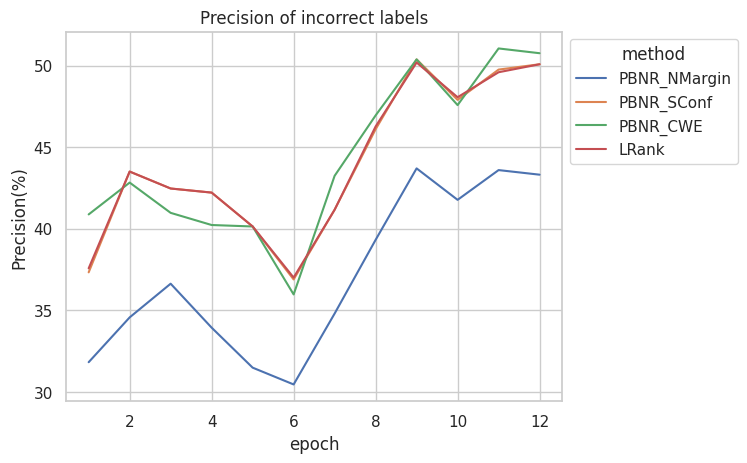

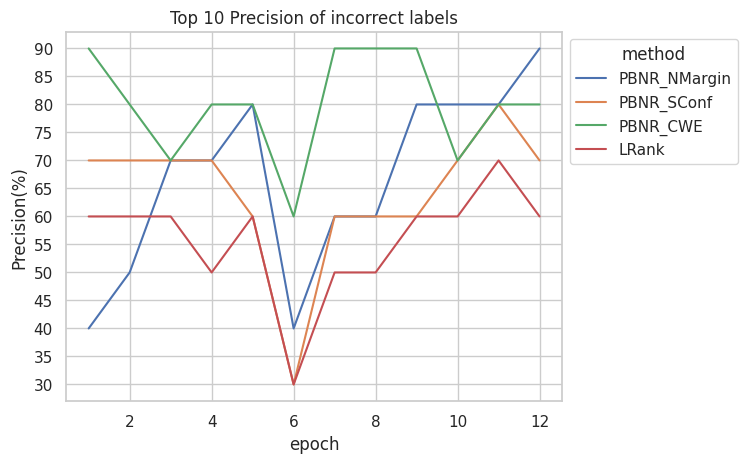

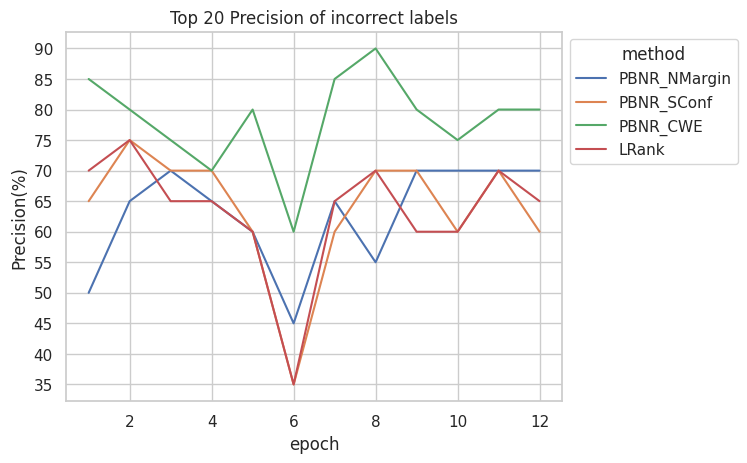

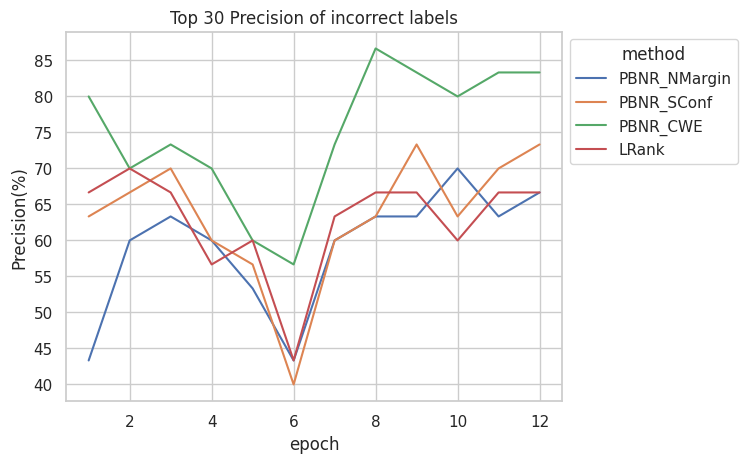

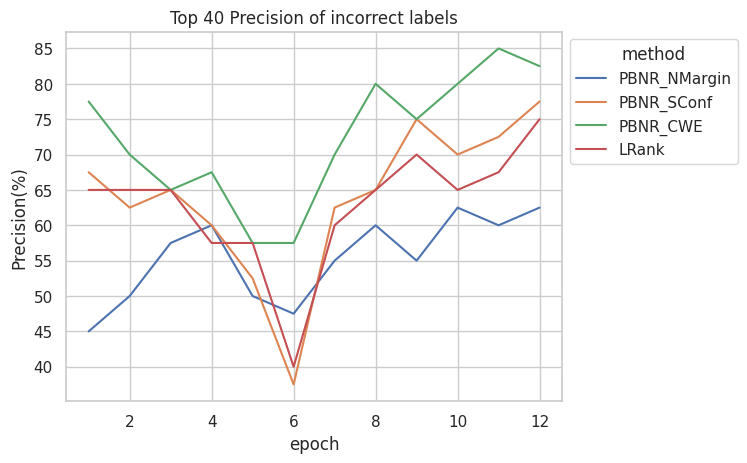

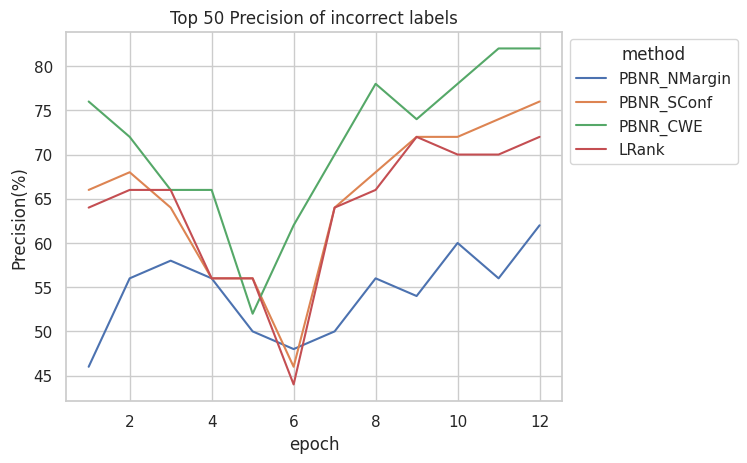

In [4]:
def draw(df, ftitle, xcol, ycol, huecol):
    sns.set_theme(style="whitegrid")
    ax = sns.lineplot(data=df, x=xcol, y=ycol, hue=huecol)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
#     plt.legend(loc='upper right', title=huecol, title_fontsize='small', fontsize='x-small')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(xlabel=xcol, ylabel='Precision(%)')
    ax.set(title=ftitle)
    plt.show()


fig_title = 'Precision'
ycol = 'precision_all'
draw(df_cal, f'{fig_title} of incorrect labels', 
     xcol='epoch', ycol=ycol, huecol='method')

topn = 10
fig_title = f'Top {topn} Precision'
ycol = f'precision_{topn}'
draw(df_cal, f'{fig_title} of incorrect labels', 
     xcol='epoch', ycol=ycol, huecol='method')

topn = 20
fig_title = f'Top {topn} Precision'
ycol = f'precision_{topn}'
draw(df_cal, f'{fig_title} of incorrect labels', 
     xcol='epoch', ycol=ycol, huecol='method')

topn = 30
fig_title = f'Top {topn} Precision'
ycol = f'precision_{topn}'
draw(df_cal, f'{fig_title} of incorrect labels', 
     xcol='epoch', ycol=ycol, huecol='method')

topn = 40
fig_title = f'Top {topn} Precision'
ycol = f'precision_{topn}'
draw(df_cal, f'{fig_title} of incorrect labels', 
     xcol='epoch', ycol=ycol, huecol='method')

topn = 50
fig_title = f'Top {topn} Precision'
ycol = f'precision_{topn}'
draw(df_cal, f'{fig_title} of incorrect labels', 
     xcol='epoch', ycol=ycol, huecol='method')




In [ ]:
df_cal.head()

# Per example graph

In [6]:
methods = ['PBNR_NMargin','PBNR_SConf', 'PBNR_CWE', 'LRank']

colnames = ['bbox_idx', 'epoch', 'loss', 'prob', 'bbox_gt', 'label_gt', 'label_gt_des', 'label_pred', 'label_pred_des'] + methods 

df_per = pd.DataFrame(columns=colnames)

default_df = pd.read_csv(f'{csv_dirpath}/{default_csv_filename}', index_col=0)
incorrects = default_df.loc[(default_df['c_incorrect'] == 'TRUE')]
incorrects_idxs = incorrects.index.tolist()

# incorrects_idxs = incorrects_idxs[40:60]

is_issue_types = ['c_incorrect', 'c_correct', 'ambiguous', 'bb_incorrect']

for epo in epochs:
    # print(f'Processing epoch {epo}')

    for nsplit in nsplits:
        # print(f'Processing split {nsplit}')

        csv_filename = f'e{epo}_val_s{nsplit}.csv'
        epo_df = pd.read_csv(f'{csv_dirpath}/e{epo}/{csv_filename}', index_col=0)
        epo_df['prob'] = epo_df['prob'].apply(lambda x: np.asarray(x.split(';'), dtype=float))
        epo_df['bbox_gt'] = epo_df['bbox_gt'].apply(lambda x: np.asarray(x.split(';'), dtype=float))
        
        epo_df['bbox_idx'] = epo_df.index.tolist()
        epo_df['epoch'] = epo

        df_per = pd.concat([df_per, epo_df.loc[incorrects_idxs, colnames]], ignore_index=True)



    print(f'-----------------End of Epoch {epo}-----------------')

-----------------End of Epoch 1-----------------
-----------------End of Epoch 2-----------------
-----------------End of Epoch 3-----------------
-----------------End of Epoch 4-----------------
-----------------End of Epoch 5-----------------
-----------------End of Epoch 6-----------------
-----------------End of Epoch 7-----------------
-----------------End of Epoch 8-----------------
-----------------End of Epoch 9-----------------
-----------------End of Epoch 10-----------------
-----------------End of Epoch 11-----------------
-----------------End of Epoch 12-----------------


# Loss Scatter Graph

In [ ]:
# def draw_scatterplot(df, ftitle, xcol, ycol, huecol, hue_thresh, sizecol, palette=None):

#     if huecol != 'loss':
#         df[f'{huecol}_bool'] = np.where(df[huecol] < hue_thresh, True, False)
#         huecol = f'{huecol}_bool'

#     g = sns.scatterplot(data=df, x=xcol, y=ycol, hue=huecol, size=sizecol,
#                         palette=palette)
#     g.set(title=ftitle)
#     sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    
#     g.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, p: f'img {int(y)}'))
#     # g.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'epoch {int(x)}'))
#     g.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     # g.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()

# draw_scatterplot(df_per, ftitle='Loss Values for each image in each epoch',
#                  xcol='epoch', ycol='bbox_idx', huecol='loss', hue_thresh=None, sizecol='loss')

# hue_thresh = 200
# draw_scatterplot(df_per, ftitle=f'Loss Ranking for Top {hue_thresh}',
#                  xcol='epoch', ycol='bbox_idx', huecol='LRank', hue_thresh=hue_thresh, sizecol='loss',
#                  palette={True:"#0061ac", False:"#dff7ff"})

# hue_thresh = 700
# draw_scatterplot(df_per, ftitle=f'Loss Ranking for Top {hue_thresh}',
#                  xcol='epoch', ycol='bbox_idx', huecol='LRank', hue_thresh=hue_thresh, sizecol='loss',
#                  palette={True:"#0061ac", False:"#dff7ff"})

/tmp/ipykernel_1632832/1912723569.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['TP'] = tmp_df['label_gt'].eq(tmp_df['label_pred'])


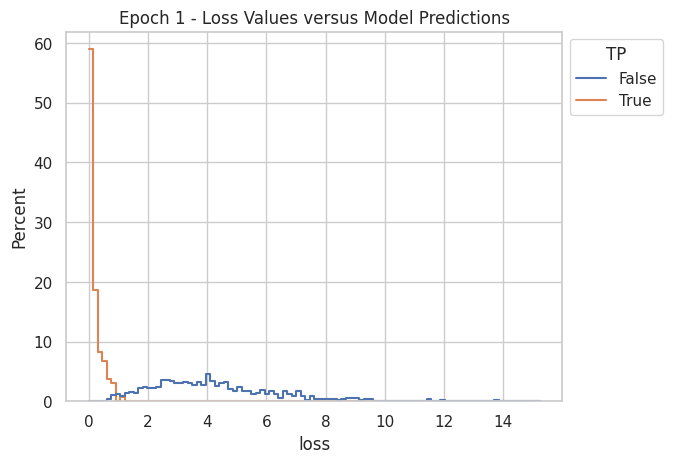

/tmp/ipykernel_1632832/1912723569.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['TP'] = tmp_df['label_gt'].eq(tmp_df['label_pred'])


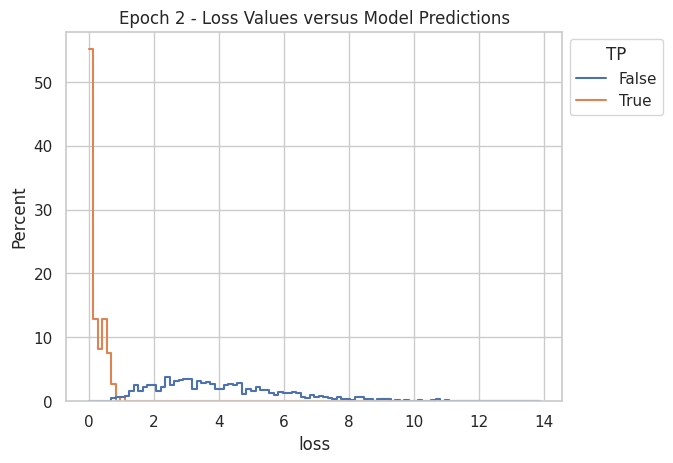

/tmp/ipykernel_1632832/1912723569.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['TP'] = tmp_df['label_gt'].eq(tmp_df['label_pred'])


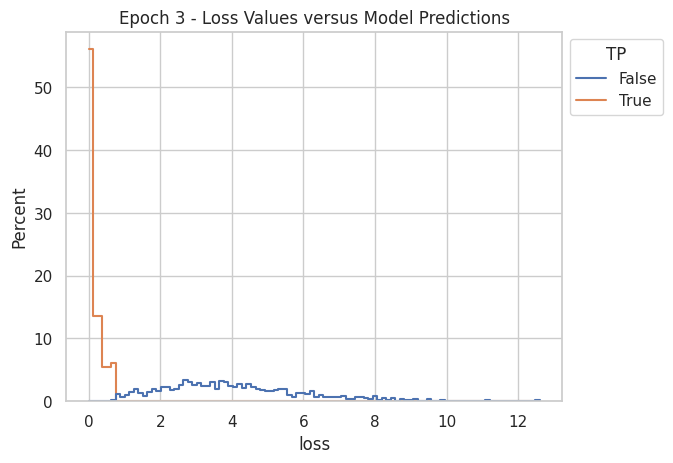

/tmp/ipykernel_1632832/1912723569.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['TP'] = tmp_df['label_gt'].eq(tmp_df['label_pred'])


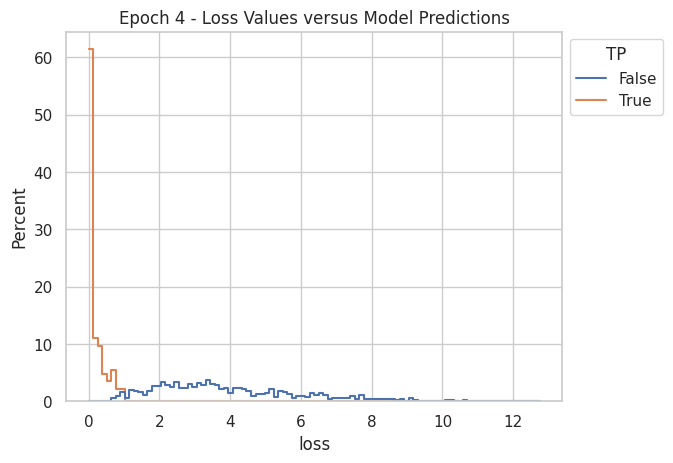

/tmp/ipykernel_1632832/1912723569.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['TP'] = tmp_df['label_gt'].eq(tmp_df['label_pred'])


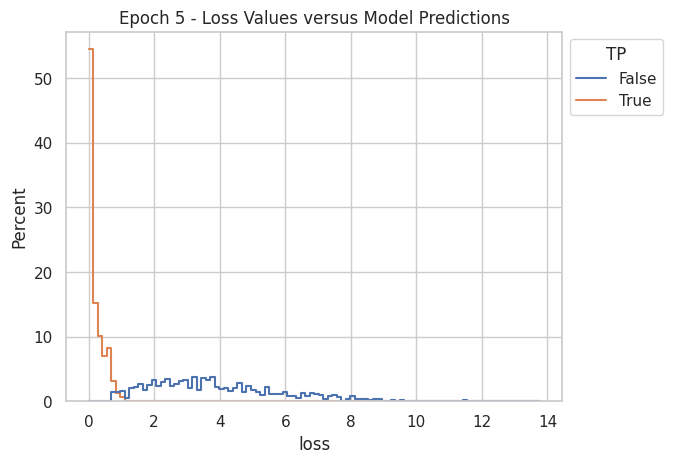

/tmp/ipykernel_1632832/1912723569.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['TP'] = tmp_df['label_gt'].eq(tmp_df['label_pred'])


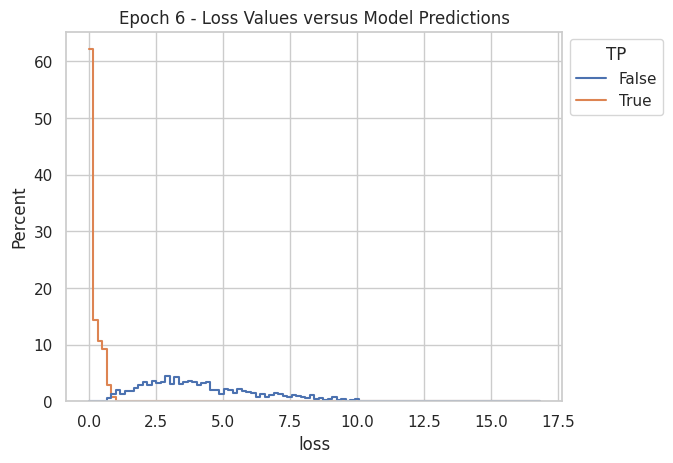

/tmp/ipykernel_1632832/1912723569.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['TP'] = tmp_df['label_gt'].eq(tmp_df['label_pred'])


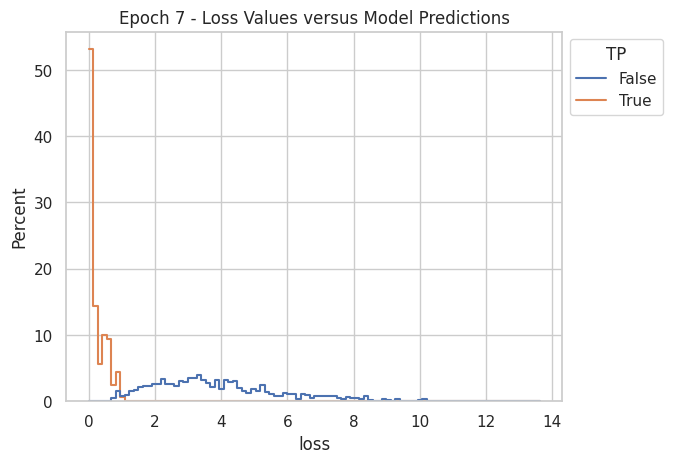

/tmp/ipykernel_1632832/1912723569.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['TP'] = tmp_df['label_gt'].eq(tmp_df['label_pred'])


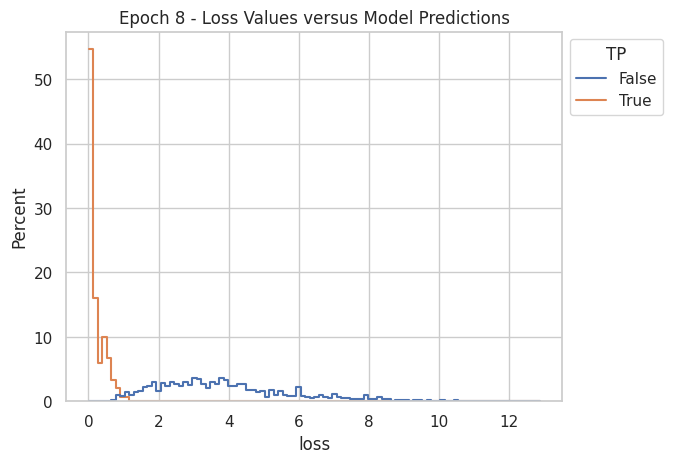

/tmp/ipykernel_1632832/1912723569.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['TP'] = tmp_df['label_gt'].eq(tmp_df['label_pred'])


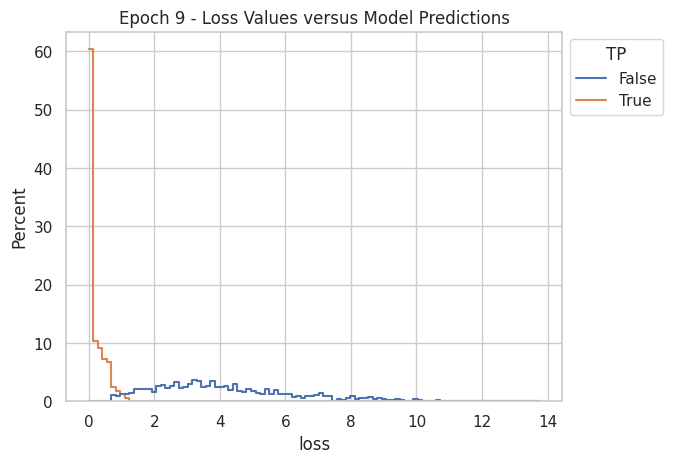

/tmp/ipykernel_1632832/1912723569.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['TP'] = tmp_df['label_gt'].eq(tmp_df['label_pred'])


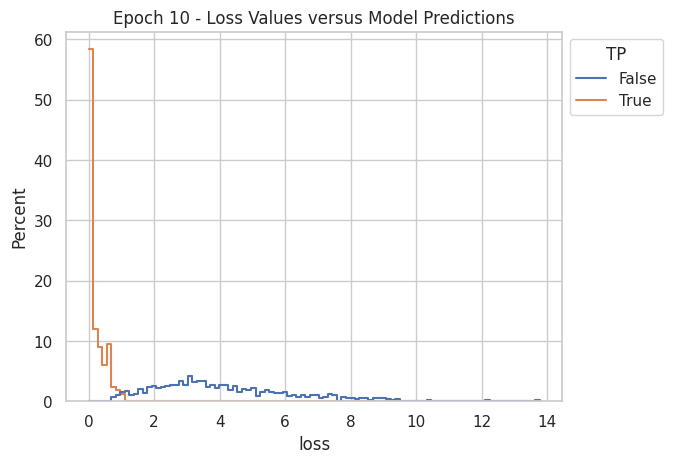

/tmp/ipykernel_1632832/1912723569.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['TP'] = tmp_df['label_gt'].eq(tmp_df['label_pred'])


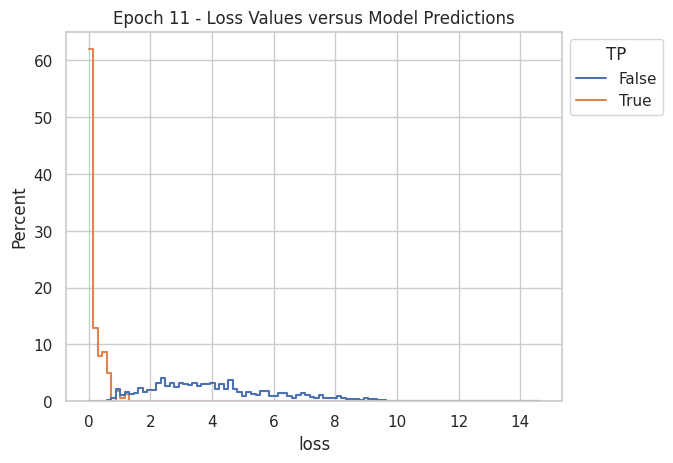

/tmp/ipykernel_1632832/1912723569.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['TP'] = tmp_df['label_gt'].eq(tmp_df['label_pred'])


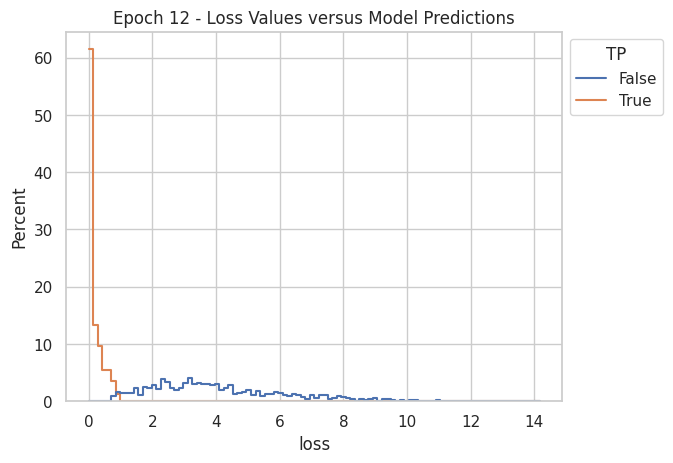

In [7]:
def draw_histplot(df, ftitle, xcol, huecol):

    # if huecol != 'loss':
    #     df[f'{huecol}_bool'] = np.where(df[huecol] < hue_thresh, True, False)
    #     huecol = f'{huecol}_bool'

    g = sns.histplot(
        data=df, x=xcol, hue=huecol, element="step", fill=False,
        cumulative=False, stat="percent", 
        bins=100, common_norm=False)
        # log_scale=True)
    
    g.set(title=ftitle)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    
    # g.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, p: f'img {y}'))
    # g.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'epoch {int(x)}'))
    # g.xaxis.set_major_locator(ticker.MultipleLocator(10))

    plt.show()

hist_df = df_per

for epo in epochs:
    tmp_df = hist_df.loc[hist_df['epoch'] == epo]
    tmp_df['TP'] = tmp_df['label_gt'].eq(tmp_df['label_pred'])
    draw_histplot(tmp_df,
                  ftitle=f'Epoch {epo} - Loss Values versus Model Predictions',
                  xcol='loss', huecol='TP')